<h1>Group Alpha Final Project: <h1>
<h2>Hotel Booking Demand<h2>

*Context*

Hotel adalah sebuah tempat untuk berlibur ataupun tempat untuk tinggal sementara disebuah kota karena adanya perjalanan bisnis atau mengunjungi keluarga. Oleh karena itu, hampir diseluruh kota disetiap negara pasti ada Hotel yang bisa tempati. Bisnis diindustri per-hotelan salah satu bisnis yang cukup menjanjikan, karena demand / permintaannya selalu ada. Tetapi banyak juga hotel yang bangkrut karena demandnya terlalu sedikit atau bahkan tidak ada, karena Hotel tersebut tidak memiliki cukup dana untuk menutupi biaya perawatan hotel, gaji karyawan, biaya operasional Hotel, dll. Demand yang sedikit bisa disebabkan karena jenis hotelnya, fasilitas hotel, pelayanan hotel, dll. Tidak sedikit juga orang yang sudah melakukan reservasi disebuah Hotel tapi akhirnya dibatalkan karena 1 dan lain hal

*Problem Statement*

Bagaimana hotel dapat memprediksi lebih awal apakah sebuah reservasi akan dibatalkan atau tidak, sehingga manajemen dapat:
1. Menetapkan strategi overbooking dan harga yang tepat
2. Melakukan intervensi (reminder, penawaran Non‑Refund, upsell) pada booking berisiko tinggi
3. Mengurangi kerugian pendapatan akibat pembatalan mendadak



*Goal*

Meningkatkan pendapatan bersih (net revenue) melalui:
1. Model prediksi pembatalan pemesanan menggunakan data historis dari 2015-2017
2. Mengetahui faktor apa saja yang memengaruhi customer dalam membatalkan bookingnya

*Pertanyaan untuk data analysis:*
1. Faktor apa (lead time, total nights, special requests, deposit_type, dll) yang paling memengaruhi probabilitas pembatalan?
2. Apakah tingkat pembatalan berbeda signifikan antar Resort Hotel dan City Hotel?
3. Berapa rata‑rata ADR per bulan dan per tahun (2015, 2016, 2017)?
4. Berapa jumlah pembatalan setiap bulan dan setiap tahun?

*Evaluasi Matriks*

Type I (False Positive) – model memprediksi bookingan “akan dibatalkan” padahal booking sebenarnya tidak batal. Pada bisnis hotel, ini dapat menyebabkan over‑booking lebih agresif dari yang semestinya.

Type II (False Negative) – model memprediksi “tidak batal” padahal booking akhirnya batal, berisiko menimbulkan kamar kosong mendadak

Matriks Utama untuk Klasifikasi Pembatalan:
1. Accuracy
2. Precision
3. Recall
4. F1-Score
5. ROC_AUC

<h2> Data Understanding <h2>

In [1]:
# Import library untuk membaca data dan melakukan visualisasi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import shapiro, normaltest, kstest, spearmanr, kruskal
from scipy.stats import(
    shapiro, normaltest, ttest_ind, mannwhitneyu,
    chi2_contingency, pointbiserialr, spearmanr, kruskal, kstest
)

In [2]:
# Membaca dan melihat data CSV

df_hotel_demand_bookings = pd.read_csv('hotel_bookings.csv')
df_hotel_demand_bookings.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

Deksripsi untuk setiap kolom

* **hotel**: Jenis hotel yang ada di dalam data -> Resort Hotel dan City Hotel

* **is_canceled**: Value yang menandakan apakah bookingnya canceled (1) atau tidak (0)

* **lead_time**: Selisih hari antara tanggal entri pemesanan di PMS dan tanggal kedatangan tamu
* **arrival_date_year**: Tahun kedatangan tamu
* **arrival_date_month**: Bulan kedatangan tamu: “January” sampai “December”
* **arrival_date_week_number**: Nomor minggu ISO (1-53) pada tahun kedatangan
* **arrival_date_day_of_month**: Tanggal kedatangan (1–31)
* **stays_in_weekend_nights**: Malam menginap pada akhir pekan (Sabtu + Minggu)
* **stays_in_week_nights**: Malam menginap pada hari kerja (Senin–Jumat)
* **adults**: Jumlah tamu dewasa dalam pemesanan
* **children**: Jumlah anak (< 18 th) dalam pemesanan. Nilai 0.0 jika tidak ada
* **babies**: Jumlah bayi (< 2 th) dalam pemesanan
* **meal**: Paket makan yang dibeli (contoh: BB = Bed & Breakfast, HB = Half-Board, SC = Self-Catering, Undefined)
* **country**: Negara asal pemesan
* **market_segment**: Penamaan segmentasi market, “TA” -> “Travel Agents” dan “TO” -> “Tour Operators”
* **distribution_channel**: Saluran distribusi utama, “TA” -> “Travel Agents” dan “TO” -> “Tour Operators”
* **is_repeated_guest**: (1) jika tamu sudah pernah menginap sebelumnya, (0) jika tamu baru
* **previous_cancellations**: Jumlah pemesanan terdahulu yang pernah dibatalkan oleh tamu sebelum pemesanan saat ini
* **previous_bookings_not_canceled**: Pemesanan terdahulu yang tidak dibatalkan oleh tamu ini
* **reserved_room_type**: Tipe kamar yang diminta saat pemesanan
* **assigned_room_type**: Tipe kamar yang akhirnya diberikan saat check-in, bisa berbeda karena upgrade / overbooking
* **booking_changes**: Berapa kali pemesanan diubah oleh tamu / hotel (tanggal, jumlah tamu, dll.)
* **deposit_type**: No Deposit – tidak ada deposit yang dilakukan; Non Refund – deposit dilakukan sebesar nilai total biaya menginap; Refundable – deposit dilakukan dengan nilai di bawah total biaya menginap.
* **agent**: Kode agen perjalanan yang memproses pemesanan
* **company**: Kode perusahaan (kontrak corporate) yang memesan
* **days_in_waiting_list**: Jumlah hari dari tamu melakukan reservasi sampai dikonfirmasi
* **customer_type**: Jenis-jenis Tamu
* **adr**: Pendapatan rata-rata per kamar per malam
* **required_car_parking_spaces**: Jumlah slot parkir mobil yang diminta oleh tamu
* **total_of_special_requests**: Jumlah permintaan tambahan dari tamu
* **reservation_status**: Check-Out – Tamu sudah keluar dari Hotel; No-Show – Tamu tidak datang ke Hotel tanpa memberikan alasan (Canceled); Canceled - Tamu melakukan pembatalan reservasi
* **reservation_status_date**: Tanggal saat status di atas dicatat

<h2>Exploratory Data Analysis (EDA) <h2>

In [3]:
# Melihat jumlah baris dan kolom pada dataset

df_hotel_demand_bookings.shape

(119390, 32)

In [4]:
df_hotel_demand_bookings.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [5]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

- Jumlah data pada dataset sebanyak 119390 dengan jumlah kolom sebanyak 32
- Diantara 32 kolom 20 kolom merupakan kolom numerikal sedangkan 12 lainnya kolom kategorikal
- Kolom numerikal antara lain :
    - is_canceled
    - lead_time
    - arrival_date_year
    - arrival_date_week_number
    - arrival_date_day_of_month
    - stays_in_weekend_nights
    - stays_in_week_nights
    - adults
    - children
    - babies
    - is_repeated_guest
    - previous_cancellations
    - previous_bookings_not_canceled
    - booking_changes
    - agent
    - days_in_waiting_list
    - adr
    - required_car_parking_spaces
    - total_of_special_requests
- Kolom kategorikal antara lain :
    - hotel
    - arrival_date_month
    - meal
    - country
    - market_segment
    - distribution_channel
    - reserved_room_type
    - assigned_room_type
    - deposit_type
    - customer_type
    - reservation_status

<h3>DESCRIPTIVE ANALYTICS<h3>

In [6]:
df_hotel_demand_bookings.describe()

is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            119390.000000         119390.000000  119390.000000   
mean                  0.927599              2.500302       1.856403   
std                   0.998613              1.908286       0.579261   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  119386.000000  119390.000000      119390.000000   
mean        0.103890       0.007949           0.031912   
std         0.398561       0.097436           0.175767   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           119390.000000                   119390.000000   
mean                 0.087118                        0.137097   
std                  0.844336                        1.497437   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    119390.000000  103050.000000  6797.000000         119390.000000   
mean          0.221124      86.693382   189.266735              2.321149   
std           0.652306     110.774548   131.655015             17.594721   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   179.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          21.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  119390.000000                119390.000000              119390.000000  
mean      101.831122                     0.062518                   0.571363  
std        50.535790                     0.245291                   0.792798  
min        -6.380000                     0.000000                   0.000000  
25%        69.290000                     0.000000                   0.000000  
50%        94.57500

In [7]:
df_hotel_demand_bookings.describe(include='object')

hotel arrival_date_month    meal country market_segment  \
count       119390             119390  119390  118902         119390   
unique           2                 12       5     177              8   
top     City Hotel             August      BB     PRT      Online TA   
freq         79330              13877   92310   48590          56477   

       distribution_channel reserved_room_type assigned_room_type  \
count                119390             119390             119390   
unique                    5                 10                 12   
top                   TA/TO                  A                  A   
freq                  97870              85994              74053   

       deposit_type customer_type reservation_status reservation_status_date  
count        119390        119390             119390                  119390  
unique            3             4                  3                     926  
top      No Deposit     Transient          Check-Out              2015-10-21  
freq         104641         89613              75166                    1461

- Kolom seperti children dan babies di dominasi oleh value bernilai 0, yang dimana berarti adults kurang sering membawa anak atau belum punya anak
- Value pada Kolom agent dan company merupakan ID dari agent atau company yang mengurus pemesanan. Yang dimana hal ini kurang relevan dengan data numerik yang dapat dilakukan analisa

In [8]:
# Display unique items from each column
def display_unique(df):
  listUniqueItem = []
  for col in df.columns :
      listUniqueItem.append( [col, df[col].nunique(), df[col].isna().sum(), df[col].unique()])

  tableDesc = pd.DataFrame(columns=['Column Name', 'Total of Unique', 'null', 'Unique Sample'],
                      data=listUniqueItem)
  return tableDesc

display_unique(df_hotel_demand_bookings)

Column Name  Total of Unique    null  \
0                            hotel                2       0   
1                      is_canceled                2       0   
2                        lead_time              479       0   
3                arrival_date_year                3       0   
4               arrival_date_month               12       0   
5         arrival_date_week_number               53       0   
6        arrival_date_day_of_month               31       0   
7          stays_in_weekend_nights               17       0   
8             stays_in_week_nights               35       0   
9                           adults               14       0   
10                        children                5       4   
11                          babies                5       0   
12                            meal                5       0   
13                         country              177     488   
14                  market_segment                8       0   
15            distribution_channel                5       0   
16               is_repeated_guest                2       0   
17          previous_cancellations               15       0   
18  previous_bookings_not_canceled               73       0   
19              reserved_room_type               10       0   
20              assigned_room_type               12       0   
21                 booking_changes               21       0   
22                    deposit_type                3       0   
23                           agent              333   16340   
24                         company              352  112593   
25            days_in_waiting_list              128       0   
26                   customer_type                4       0   
27                             adr             8879       0   
28     required_car_parking_spaces                5       0   
29       total_of_special_requests                6       0   
30              reservation_status                3       0   
31         reservation_status_date              926       0   

                                        Unique Sample  
0                          [Resort Hotel, City Hotel]  
1                                              [0, 1]  
2   [342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68...  
3                                  [2015, 2016, 2017]  
4   [July, August, September, October, November, D...  
5   [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...  
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
7   [0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,...  
8   [0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,...  
9   [2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]  
10                    [0.0, 1.0, 2.0, 10.0, 3.0, nan]  
11                                   [0, 1, 2, 10, 9]  
12                        [BB, FB, HB, SC, Undefined]  
13  [PRT, GBR, USA, ESP, IRL, FRA, nan, ROU, NOR, ...  
14  [Direct, Corporate, Online TA, Offline TA/TO, ...  
15         [Direct, Corporate, TA/TO, Undefined, GDS]  
16                                             [0, 1]  
17  [0, 1, 2, 3, 26, 25, 14, 4, 24, 19, 5, 21, 6, ...  
18  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
19                     [C, A, D, E, G, F, H, L, P, B]  
20               [C, A, D, E, G, F, I, B, H, P, L, K]  
21  [3, 4, 0, 1, 2, 5, 17, 6, 8, 7, 10, 16, 9, 13,...  
22               [No Deposit, Refundable, Non Refund]  
23  [nan, 304.0, 240.0, 303.0, 15.0, 241.0, 8.0, 2...  
24  [nan, 110.0, 113.0, 270.0, 178.0, 240.0, 154.0...  
25  [0, 50, 47, 65, 122, 75, 101, 150, 125, 14, 60...  
26      [Transient, Contract, Transient-Party, Group]  
27  [0.0, 75.0, 98.0, 107.0, 103.0, 82.0, 105.5, 1...  
28                                    [0, 1, 2, 8, 3]  
29                                 [0, 1, 3, 2, 4, 5]  
30                     [Check-Out, Canceled, No-Show]  
31  [2015-07-01, 2015-07-02, 2015-07-03, 2015-05-0...

- Banyaknya nilai kosong pada kolom agent, country, dan terutama kolom company yang nantinya akan di handle pada data preprocessing

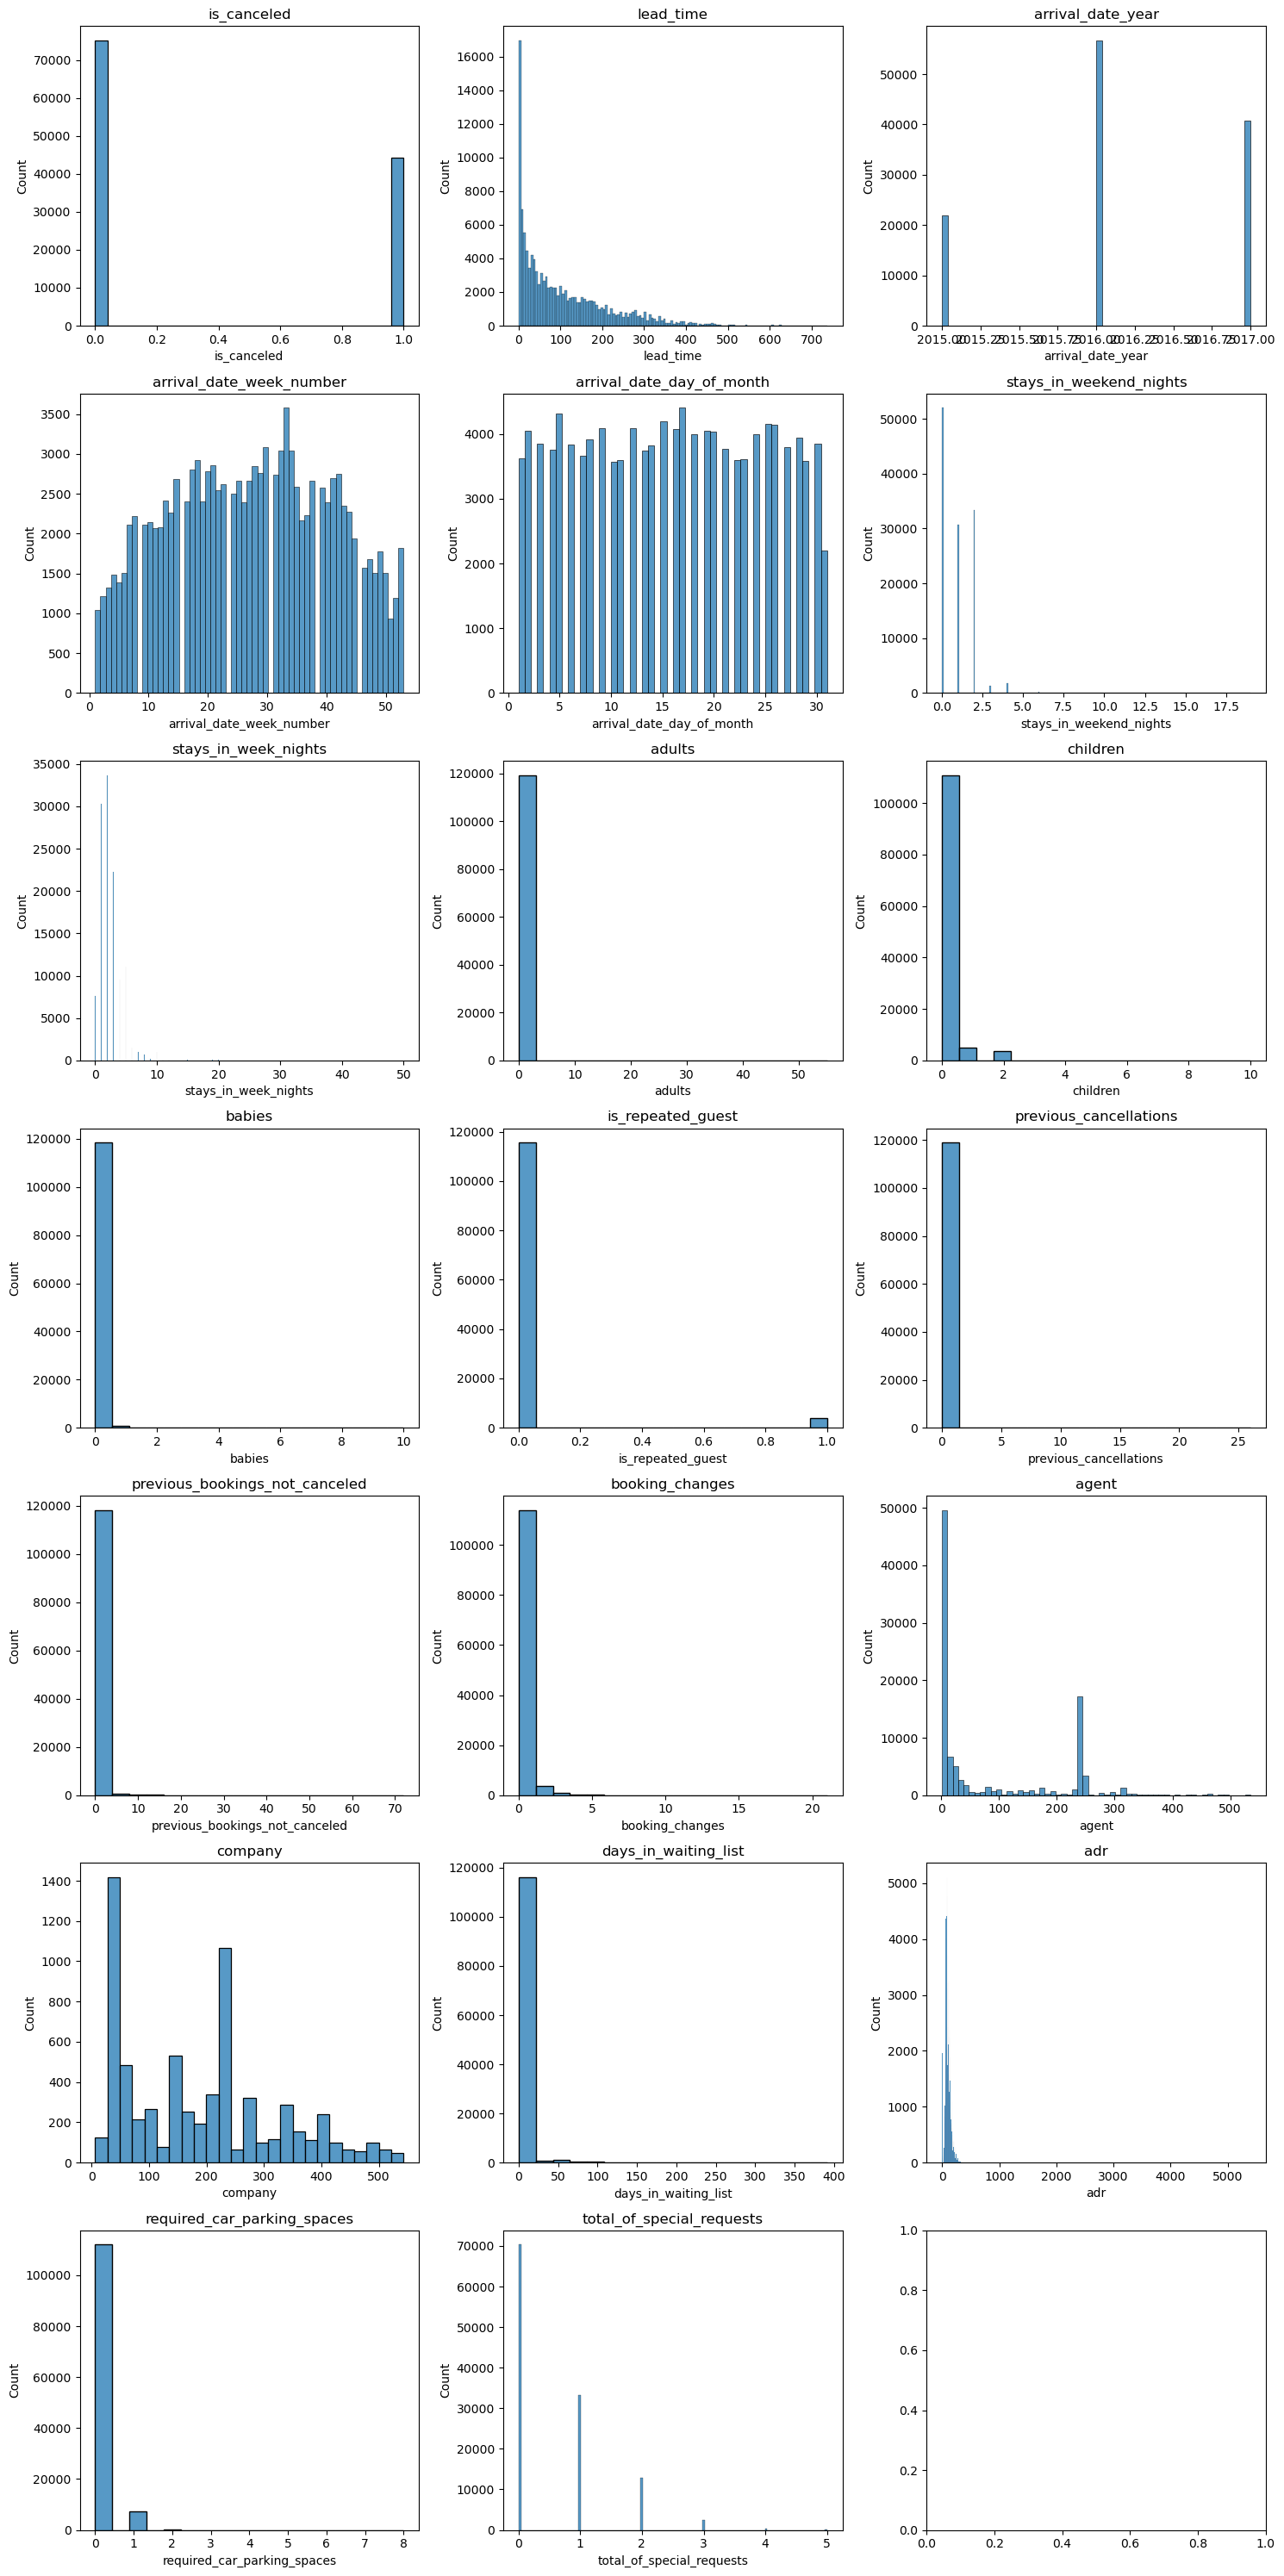

In [9]:
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols):
    row, col = divmod(i, 3)  
    sns.histplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

- Jika dilihat secara sekilas, data numerikal pada dataset ini tidak berdistribusi normal, terlebih banyaknya data numerikal yang discrete, seperti total_of_special_requests, required_car_parking_spaces, adults, dan lain-lain.

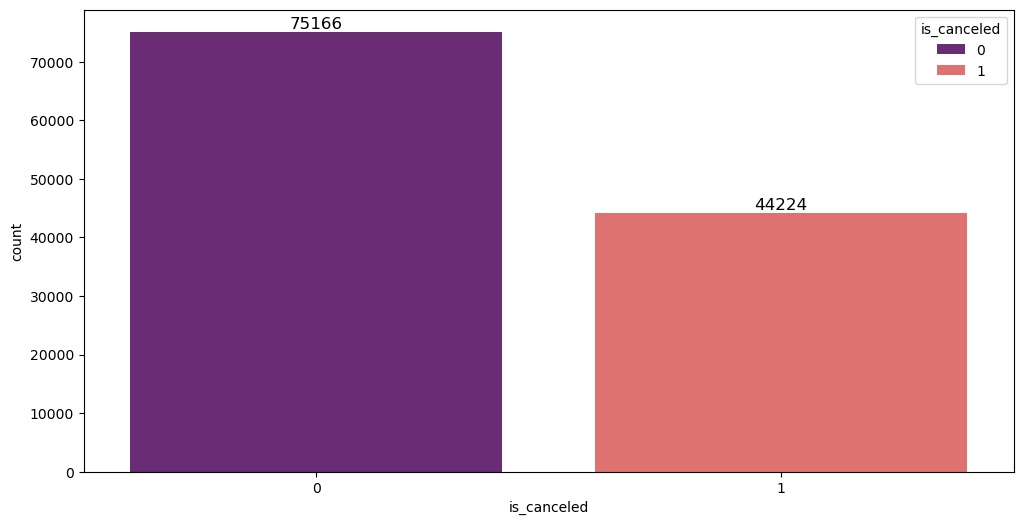

In [10]:
plt.figure(figsize=(12,6))
plot = sns.countplot(x=df_hotel_demand_bookings['is_canceled'], hue=df_hotel_demand_bookings['is_canceled'],
                     palette='magma')

for container in plot.containers:
        plot.bar_label(container, label_type='edge', fontsize=12)
plt.show()

Berdasarkan jumlah data, pemesanan yang berhasil ada sebanyak 75166 dan yang berakhir di-cancel ada sebanyak 44224, hal ini juga menunjukkan adanya imbalance pada target feature untuk kebutuhan model machine learning nantinya

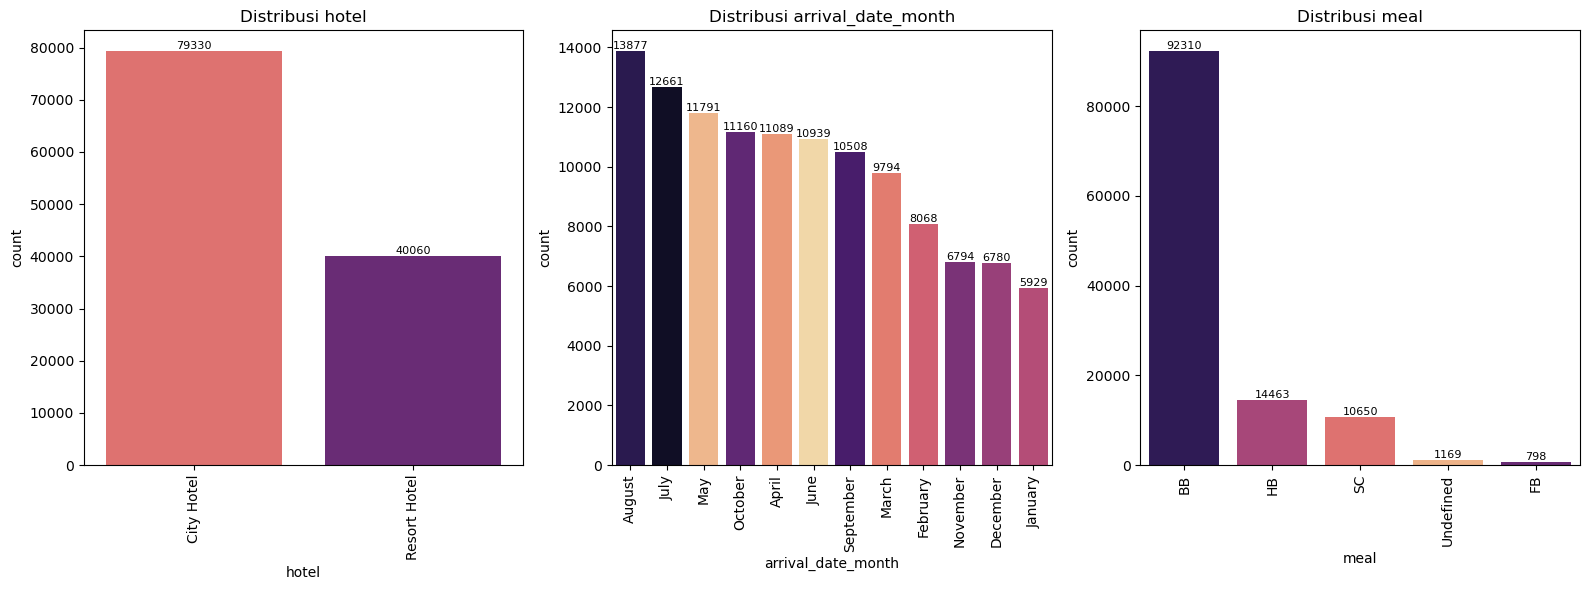

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['hotel', 'arrival_date_month', 'meal']].columns.tolist()):
    ax = axes[i]
    plot = sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings[feature], 
                         palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:].index, ax=ax)
    
    ax.set_title(f'Distribusi {feature}')
    ax.tick_params(axis='x', rotation=90)
    
    # Add value labels on top of each bar
    for container in plot.containers:
        plot.bar_label(container, label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

- Pemesanan paling banyak di hotel tipe City dengan jumlah 79330, hampir 100% lebih banyak dari resort hotel
- Kedatangan tamu atau check-in paling banyak ada di bulan Agustus, diikuti bulan Juli. Bulan Mei, April, Maret, June memiliki jumlah perbedaan yang tidak banyak, dan bulan januari menjadi bulan yang paling sedikit.
- Tipe makanan BB menjadi yang paling banyak dibeli oleh tamu, 80% dari total pemesanan. Tipe FB menjadi yang paling sedikit dengan jumah 798

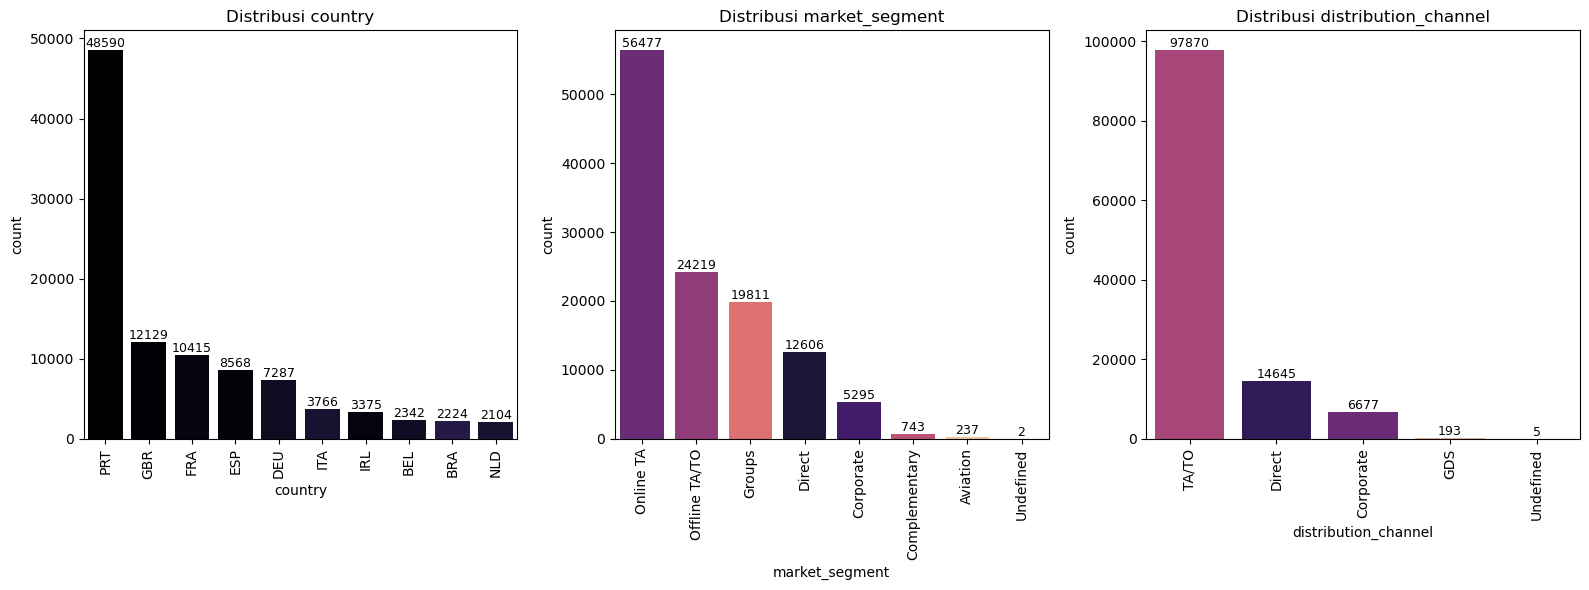

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['country', 'market_segment', 'distribution_channel']].columns.tolist()):
    ax = axes[i]
    plot = sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings[feature], 
                         palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, legend=False, ax=ax)
    
    ax.set_title(f'Distribusi {feature}')
    ax.tick_params(axis='x', rotation=90)
    
    # Add value labels on top of each bar
    for container in plot.containers:
        plot.bar_label(container, label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()

- Negara Portugal menjadi negara yang paling banyak melakukan pemesanan, yaitu sebanyak 48590, 40% dari total pemesanan
- Online TA menjadi segmentasi market paling banyak, yaitu sebanyak 56477, hampir 50% dari total pemesanan
- TA/TO menjadi distribusi channel paling tinggi dengan total 97870 pemesaan, 82% dari total pemesanan

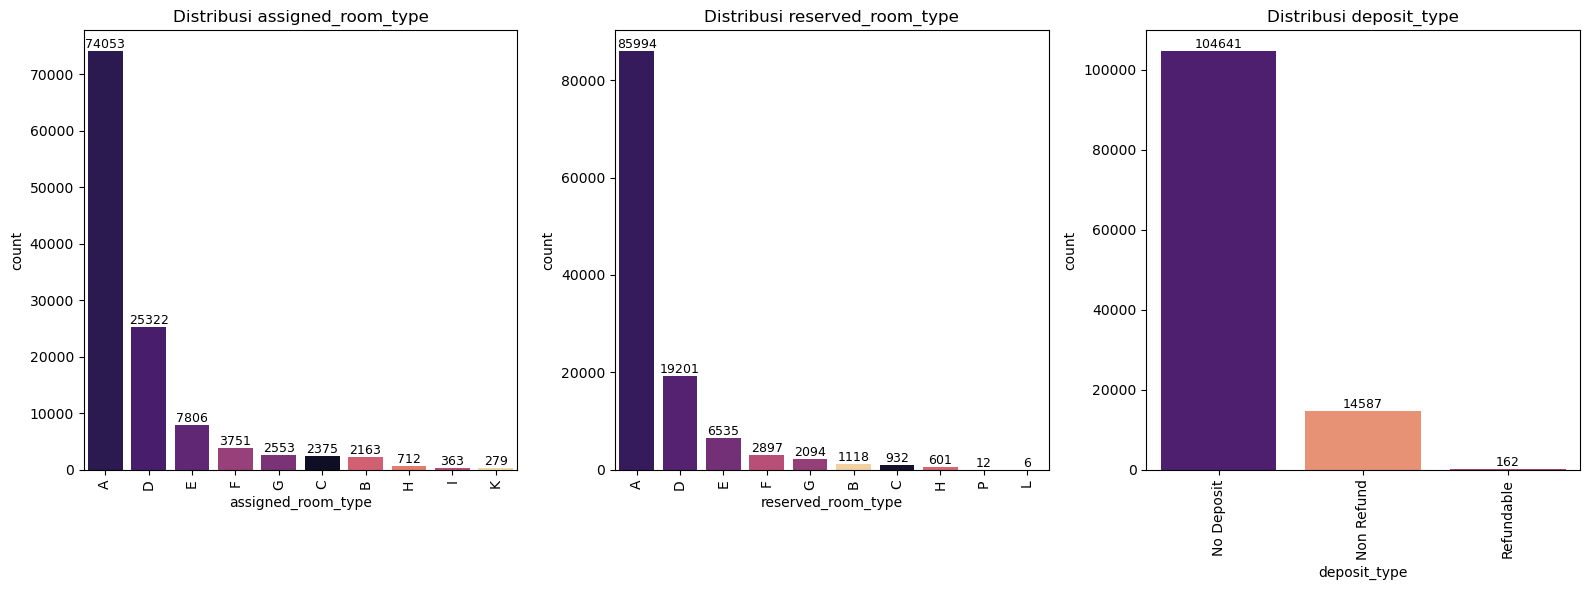

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['assigned_room_type','reserved_room_type', 'deposit_type']].columns.tolist()):
    ax = axes[i]
    plot = sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings[feature], palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=ax)
    ax.set_title(f'Distribusi {feature}')
    ax.tick_params(axis='x', rotation=90)

    # Add value labels on top of each bar
    for container in plot.containers:
        plot.bar_label(container, label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()

- Tipe ruangan yang paling banyak dipilih oleh tamu adalah ruangan A, D, dan E. Begitu juga dengan ruangan yang paling banyak diberi oleh hotel
- Hampir 90% dari total pemesanan, dilakukan tanpa melakukan deposit.

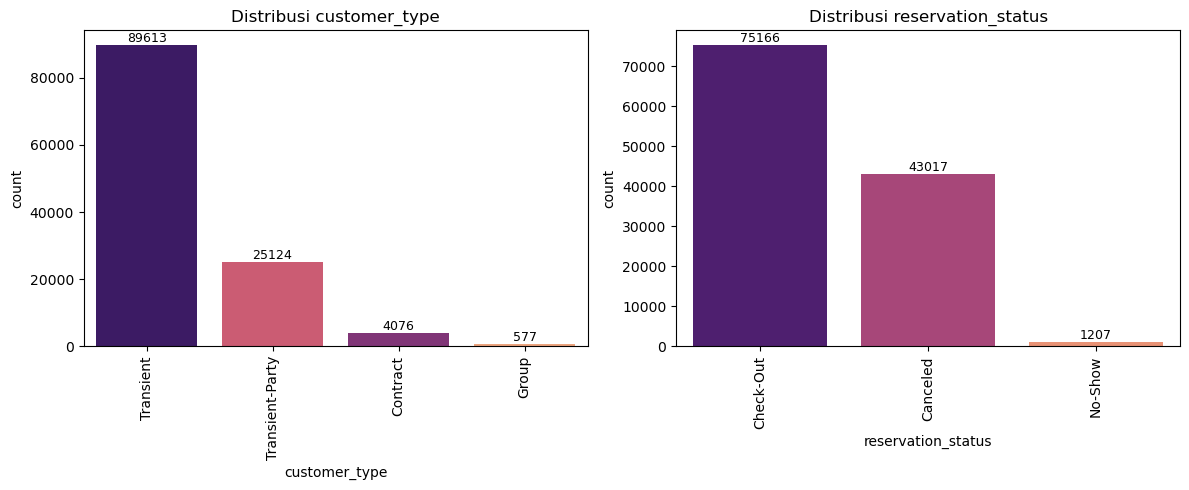

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['customer_type', 'reservation_status']].columns.tolist()):
    ax = axes[i]
    plot = sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings[feature], palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:].index, ax=ax)
    ax.set_title(f'Distribusi {feature}')
    ax.tick_params(axis='x', rotation=90)

    # Add value labels on top of each bar
    for container in plot.containers:
        plot.bar_label(container, label_type='edge', fontsize=9)
        
plt.tight_layout()
plt.show()

- Tipe tamu paling banyak adalah adalah Transient
- 75166 pemesanann berakhir Checkout, sedangkan 43017 data lainnya berakhir di-cancel dan 1207 data berakhir tidak ada kedatangan

<h3>Correlation Data Numerikal<h3>

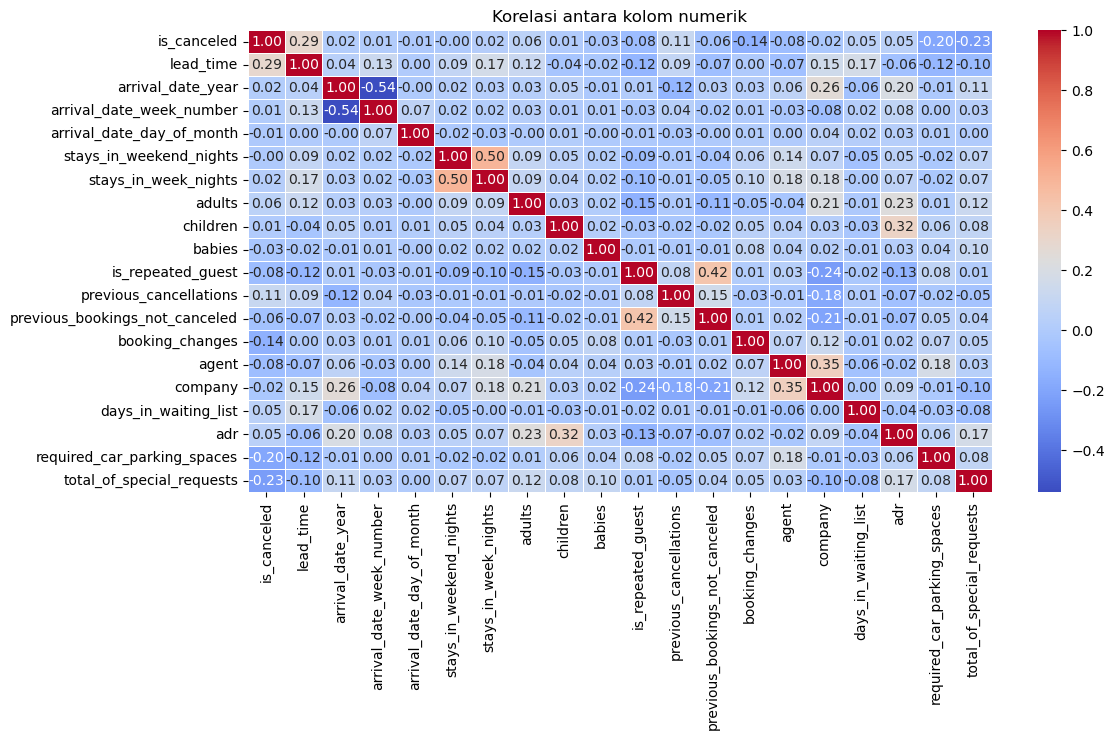

In [15]:
# Melihat korelasi antar kolom numerik

num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number])
correlation_matrix = num_cols.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korelasi antara kolom numerik")
plt.show()

In [16]:
# Melihat pasangan kolom yang memiliki korelasi (positif maupun negatif) tertinggi

corr_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
         .stack()
         .reset_index()
         .rename(columns={"level_0":"Variable 1","level_1":"Variable 2",0:"r value"})
         .sort_values("r value", ascending=False)
)


print("\nPasangan kolom dengan korelasi tertinggi:")

df_corr_pairs = pd.DataFrame(corr_pairs)
display(df_corr_pairs)



Pasangan kolom dengan korelasi tertinggi:


Variable 1                      Variable 2   r value
85          stays_in_weekend_nights            stays_in_week_nights  0.498969
146               is_repeated_guest  previous_bookings_not_canceled  0.418056
175                           agent                         company  0.350746
132                        children                             adr  0.324854
0                       is_canceled                       lead_time  0.293123
..                              ...                             ...       ...
17                      is_canceled     required_car_parking_spaces -0.195498
164  previous_bookings_not_canceled                         company -0.208557
18                      is_canceled       total_of_special_requests -0.234658
149               is_repeated_guest                         company -0.244586
37                arrival_date_year        arrival_date_week_number -0.540561

[190 rows x 3 columns]

In [17]:
# Melihat korelasi antara kolom is_canceled dengan kolom numerik lainnya
# Diurutkan dari yang paling besar korelasinya

target = "is_canceled"
corr_to_target = (
    correlation_matrix[target]
    .drop(target)
    .sort_values(ascending=False)
)

print("\nKorelasi kolom lain terhadap:", target)
display(corr_to_target)


Korelasi kolom lain terhadap: is_canceled


lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
agent                            -0.083114
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

<h3>Uji Correlation Data Kategorikal<h3>

In [18]:
cat_cols_names = df_hotel_demand_bookings.select_dtypes('object').columns.tolist()
df_cat = df_hotel_demand_bookings[cat_cols_names + ['is_canceled']]
for col in cat_cols_names:
    table = pd.crosstab(df_cat[col], df_cat['is_canceled'])
    if table.shape[0] < 2 or table.shape[1] != 2:
        continue
    chi2, pval, dof, expected = chi2_contingency(table)
    print(f"{col:<25} | p-value: {pval:.4f} | Signifikan: {'Yes' if pval < 0.05 else 'No'}")

hotel                     | p-value: 0.0000 | Signifikan: Yes
arrival_date_month        | p-value: 0.0000 | Signifikan: Yes
meal                      | p-value: 0.0000 | Signifikan: Yes
country                   | p-value: 0.0000 | Signifikan: Yes
market_segment            | p-value: 0.0000 | Signifikan: Yes
distribution_channel      | p-value: 0.0000 | Signifikan: Yes
reserved_room_type        | p-value: 0.0000 | Signifikan: Yes
assigned_room_type        | p-value: 0.0000 | Signifikan: Yes
deposit_type              | p-value: 0.0000 | Signifikan: Yes
customer_type             | p-value: 0.0000 | Signifikan: Yes
reservation_status        | p-value: 0.0000 | Signifikan: Yes
reservation_status_date   | p-value: 0.0000 | Signifikan: Yes


In [19]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))    
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for col in df_hotel_demand_bookings.select_dtypes(['object']):
    confusion_mat = pd.crosstab(df_hotel_demand_bookings[col], df_hotel_demand_bookings['is_canceled'])
    print(f"Cramér's V for {col}: {cramers_v(confusion_mat):.4f}")

Cramér's V for hotel: 0.1365
Cramér's V for arrival_date_month: 0.0696
Cramér's V for meal: 0.0501
Cramér's V for country: 0.3582
Cramér's V for market_segment: 0.2667
Cramér's V for distribution_channel: 0.1770
Cramér's V for reserved_room_type: 0.0731
Cramér's V for assigned_room_type: 0.2027
Cramér's V for deposit_type: 0.4815
Cramér's V for customer_type: 0.1363
Cramér's V for reservation_status: 1.0000
Cramér's V for reservation_status_date: 0.4799


- Bisa dilihat berdasarkan chi-square, semua data kategorikal memiliki korelasi yang signifikan
- Namun berdasarkan Cramer's V :
    - Kolom arrival_date_month, meal, hotel, customer_type, deposit_type, reserved_room_type memiliki pengaruh yang tidak berarti.
    - Kolom assigned_room_type, distribution_channel, hotel memiliki pengaruh yang lemah.
    - Kolom country, deposit_type, dan reservation_status_date memiliki pengaruh yang sedang.
    - Kolom reservation_status memiliki pengaruh yang sangat tinggi, namun dengan nilai 1 pada cramer's V dapat dikatakan bahwa kolom reservation_status akan membuat multikolinearitas dengan kolom target

<h2>Data Pre - Processing<h2>

<h3>Data Duplikasi<h3>

In [20]:
# Check for duplicated rows
print('Number of duplicated rows = ', df_hotel_demand_bookings.duplicated().sum())

Number of duplicated rows =  31994


In [21]:
df_hotel_demand_bookings.drop_duplicates(inplace=True)

In [22]:
len(df_hotel_demand_bookings)

87396

Terdapat 31994 data duplikat yang dibuang dari dataset

<h3>Menangani Missing Value<h3>

In [23]:
# Check null values
df_null = pd.DataFrame({'Null Values' : df_hotel_demand_bookings.isnull().sum(),
                        'Percentage Null Values' :
                         (df_hotel_demand_bookings.isna().sum()) / (df_hotel_demand_bookings.shape[0]) * (100)})
df_null = df_null[df_null['Null Values']>0]
df_null.sort_values('Percentage Null Values', ascending=False)

Null Values  Percentage Null Values
company         82137               93.982562
agent           12193               13.951439
country           452                0.517186
children            4                0.004577

In [24]:
df_hotel_demand_bookings.drop(['company'], axis=1, inplace=True)

In [25]:
df_hotel_demand_bookings = df_hotel_demand_bookings.fillna({'country': 'unknown', 'children': 0.0,'agent' : 0.0})

In [26]:
# Melihat kembali apakah masih ada data yang hilang

df_hotel_demand_bookings.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

- Dengan 94% besarnya data company yang hilang, maka kolom tersebut akan dibuang dari dataset
- Kolom country hanya akan diisi dengan 'unknown', children dengan 0, dan agent dengan 0 untuk mengasumsi bahwa pada data tersebut tidak ada anak kecil dan juga tidak menggunakan jasa agen

<h3>Data Formatting<h3>

In [27]:
# Mengubah tipe data kolom reservation_status_date menjadi datetime

df_hotel_demand_bookings['reservation_status_date'] = pd.to_datetime(df_hotel_demand_bookings['reservation_status_date'])

df_hotel_demand_bookings['agent'] = np.where(df_hotel_demand_bookings['agent']>0.0,1,0)
df_hotel_demand_bookings['agent'] = df_hotel_demand_bookings['agent'].astype('int64')

- kolom reservation_status_date akan diubah tipe datanya menjadi tipe data datetime yang semestinya
- nilai pada kolom agent akan diubah menjadi 1 atau 0 untuk memisahkan pemesanan mana yang menggunakan jasa agen atau tidak. Nilai ini lebih relevan dibanding dengan ID agen

<h3>ANOMALI DATA<h3>

In [28]:
df_hotel_demand_bookings[
    (df_hotel_demand_bookings['adults'] == 0) &
    (df_hotel_demand_bookings['children'] == 0) &
    (df_hotel_demand_bookings['babies'] == 0)
].head()

hotel  is_canceled  lead_time  arrival_date_year  \
2224  Resort Hotel            0          1               2015   
2409  Resort Hotel            0          0               2015   
3181  Resort Hotel            0         36               2015   
3684  Resort Hotel            0        165               2015   
3708  Resort Hotel            0        165               2015   

     arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
2224            October                        41                          6   
2409            October                        42                         12   
3181           November                        47                         20   
3684           December                        53                         30   
3708           December                        53                         30   

      stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
2224                        0                     3       0  ...   
2409                        0                     0       0  ...   
3181                        1                     2       0  ...   
3684                        1                     4       0  ...   
3708                        2                     4       0  ...   

      booking_changes  deposit_type agent days_in_waiting_list  \
2224                1    No Deposit     0                    0   
2409                0    No Deposit     0                    0   
3181                0    No Deposit     1                    0   
3684                1    No Deposit     1                  122   
3708                1    No Deposit     1                  122   

        customer_type  adr  required_car_parking_spaces  \
2224  Transient-Party  0.0                            0   
2409        Transient  0.0                            0   
3181  Transient-Party  0.0                            0   
3684  Transient-Party  0.0                            0   
3708  Transient-Party  0.0                            0   

      total_of_special_requests  reservation_status reservation_status_date  
2224                          0           Check-Out              2015-10-06  
2409                          0           Check-Out              2015-10-12  
3181                          0           Check-Out              2015-11-23  
3684                          0           Check-Out              2016-01-04  
3708                          0           Check-Out              2016-01-05  

[5 rows x 31 columns]

In [29]:
df_hotel_demand_bookings = df_hotel_demand_bookings[
    ~(
        (df_hotel_demand_bookings['adults'] == 0) &
        (df_hotel_demand_bookings['children'] == 0) &
        (df_hotel_demand_bookings['babies'] == 0)
    )
]

len(df_hotel_demand_bookings)

87230

In [30]:
# Menghapus baris yang memiliki nilai 0 pada kolom adults
# Karena tidak mungkin ada pemesanan hotel tanpa orang dewasa

df_hotel_demand_bookings = df_hotel_demand_bookings[df_hotel_demand_bookings['adults'] != 0]

- Disini data pemesanan dengan adults, children, babies bernilai 0 akan dihapus karena tidak mungkin ada pemesanan tanpa ada jumlah tamu yang akan datang
- Menghapus data yang memiliki nilai 0 pada kolom adults Karena tidak mungkin ada pemesanan hotel tanpa orang dewasa

<h3>Uji Normalitas<h3>

Data numerikal yang dipilih untuk uji normalitas dan statistik adalah data yang memiliki karakteristik data kontinu seperti lead_time, adr, days_in_waiting_list, total_special_request, booking_changes, previous_cancellations, dan previous_bookings_not_canceled.

In [31]:
num_cols_names = [
    'lead_time', 
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr',
     'total_of_special_requests'
]

df_num = df_hotel_demand_bookings[num_cols_names + ['is_canceled']]

cat_cols_names = [
    'hotel', 'arrival_date_month', 'meal', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]

df_cat = df_hotel_demand_bookings[cat_cols_names + ['is_canceled']]

In [32]:
normality_results = []

for col in num_cols_names:
    data = df_num[col].sample(5000, random_state=42) if df_num.shape[0] > 5000 else df_num[col]
    stat, pval = normaltest(data)
    normal = pval > 0.05
    normality_results.append((col, pval, normal))
    print(f"{col:<35} | p-value: {pval:.4f} | Normal: {'Yes' if normal else 'No'}")

lead_time                           | p-value: 0.0000 | Normal: No
previous_cancellations              | p-value: 0.0000 | Normal: No
previous_bookings_not_canceled      | p-value: 0.0000 | Normal: No
booking_changes                     | p-value: 0.0000 | Normal: No
days_in_waiting_list                | p-value: 0.0000 | Normal: No
adr                                 | p-value: 0.0000 | Normal: No
total_of_special_requests           | p-value: 0.0000 | Normal: No


<h3>Data Outlier<h3>

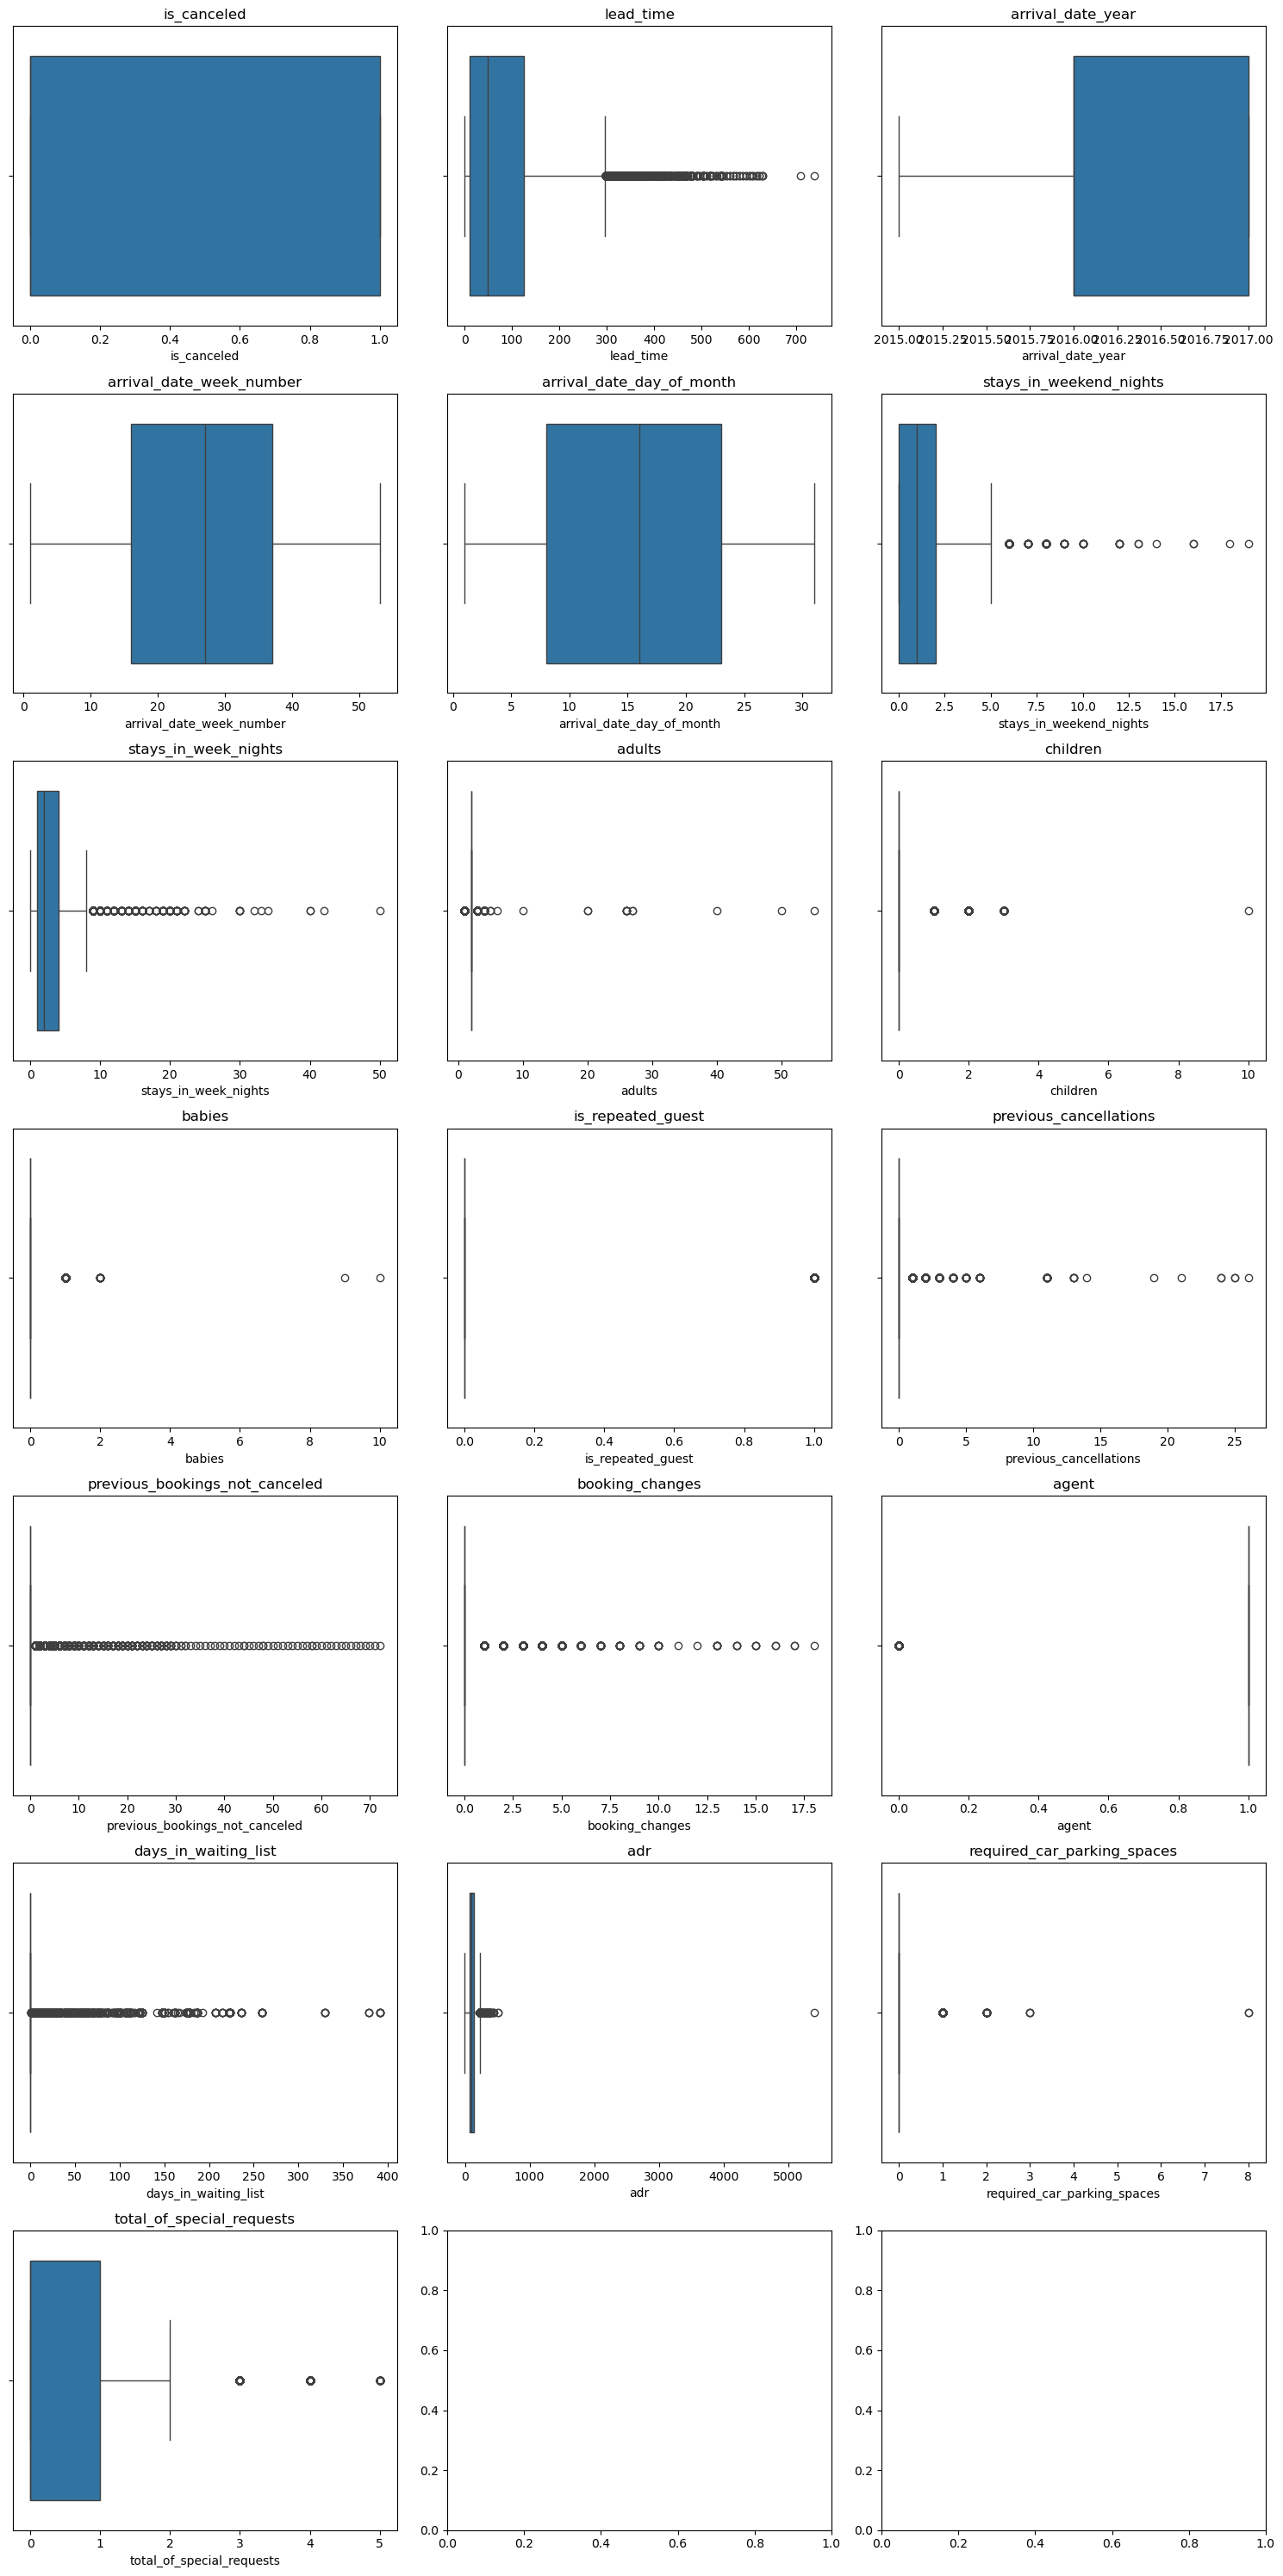

In [33]:
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols):
    row, col = divmod(i, 3)  
    sns.boxplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

- Hampir semua data numerikal ini memiliki outlier yang cukup signifikan, terutama pada lead_time

In [34]:
from scipy.stats import median_abs_deviation

df_cleaned = df_hotel_demand_bookings.copy()
numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

data_outlier = []
mask = pd.Series([True] * len(df_cleaned), index=df_cleaned.index)

for col in numeric_cols:
    col_values = df_cleaned[col].values
    median = np.median(col_values)
    mad = median_abs_deviation(col_values)
    if mad == 0:
        continue  # Skip constant column
    modified_z = 0.6745 * (col_values - median) / mad
    col_mask = np.abs(modified_z) < 3.5
    num_outliers = (~col_mask).sum()

    mask = mask & col_mask

    data_outlier.append([col, median, mad, num_outliers])

df_hotel_demand_bookings = df_cleaned[mask]

df_outlier = pd.DataFrame(
    data_outlier,
    columns=['Nama Kolom', 'Median', 'MAD', 'Jumlah Outliers']
).sort_values('Jumlah Outliers', ascending=False).reset_index(drop=True)

print("Data setelah menghapus outlier:", df_hotel_demand_bookings.shape)
df_outlier

Data setelah menghapus outlier: (80920, 31)


Nama Kolom   Median    MAD  Jumlah Outliers
0                  lead_time    49.00  44.00             3194
1       stays_in_week_nights     2.00   1.00             2122
2                        adr    98.33  30.37             1059
3    stays_in_weekend_nights     1.00   1.00              101
4          arrival_date_year  2016.00   1.00                0
5   arrival_date_week_number    27.00  11.00                0
6  arrival_date_day_of_month    16.00   8.00                0

- Data outlier pada dataset akan dibuang dengan menggunakan metode modified Z-Score. Hal ini dikarenakan data yang tidak berdistribusi normal, dan metode modified Z-score yang lebih robust terhadap data outlier dan mampu menghandle nilai ekstrem pada suatu kolom tanpa mendistorsi data natural yang skew. Sehingga lebih baik pada data yang banyak terkumpul atau terpusat pada suatu nilai.

In [35]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80920 entries, 2 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           80920 non-null  object        
 1   is_canceled                     80920 non-null  int64         
 2   lead_time                       80920 non-null  int64         
 3   arrival_date_year               80920 non-null  int64         
 4   arrival_date_month              80920 non-null  object        
 5   arrival_date_week_number        80920 non-null  int64         
 6   arrival_date_day_of_month       80920 non-null  int64         
 7   stays_in_weekend_nights         80920 non-null  int64         
 8   stays_in_week_nights            80920 non-null  int64         
 9   adults                          80920 non-null  int64         
 10  children                        80920 non-null  float64       
 11  b

In [36]:
len(df_hotel_demand_bookings)

80920

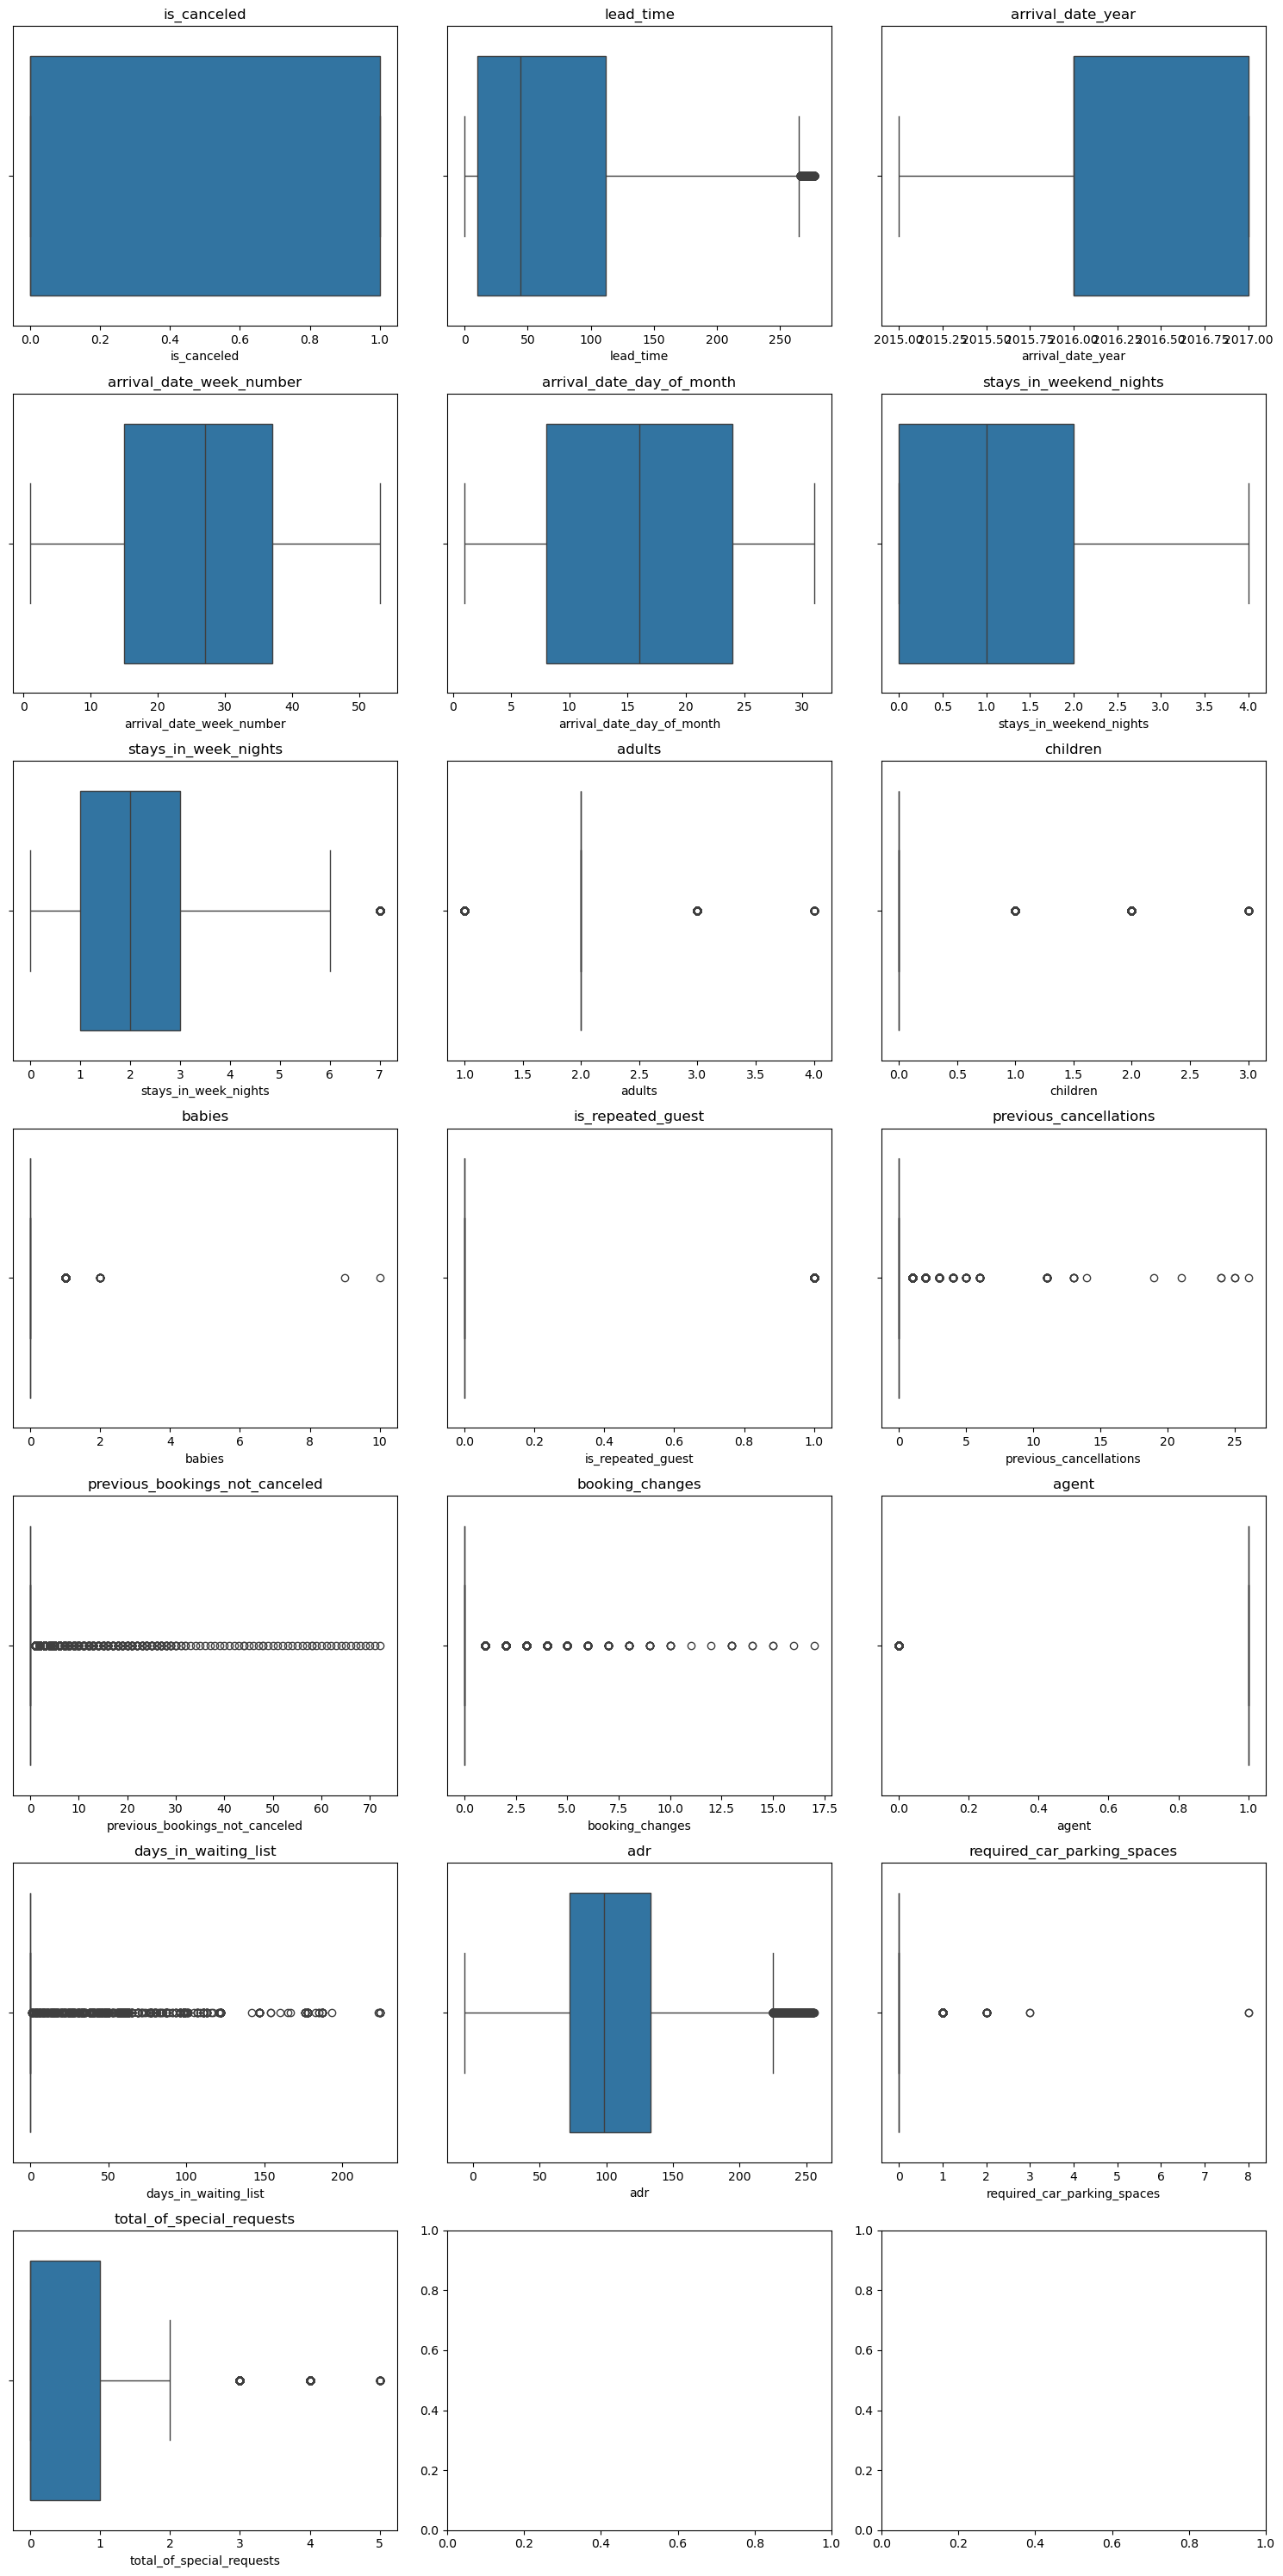

In [37]:
num_cols_cleaned = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols_cleaned):
    row, col = divmod(i, 3)  
    sns.boxplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

Setelah dilakukan cleaning, dapat terlihat seperti pada kolom lead time dan adr, boxplot menunjukkan visualisasi yang lebih baik dibanding sebelumnya dimana outlier yang sudah dibuang.

Feature Engineering

In [38]:
# Count the frequency of each country
country_counts = df_hotel_demand_bookings['country'].value_counts()

# Create a mask for countries with fewer than 50 occurrences
rare_countries = country_counts[country_counts < 50].index

# Replace rare countries with 'Other'
df_hotel_demand_bookings['country'] = df_hotel_demand_bookings['country'].replace(rare_countries, 'Other')

df_hotel_demand_bookings['total_stay'] = df_hotel_demand_bookings['stays_in_week_nights'] + df_hotel_demand_bookings['stays_in_weekend_nights']
df_hotel_demand_bookings['total_spending'] = df_hotel_demand_bookings['adr'] * df_hotel_demand_bookings['total_stay']
df_hotel_demand_bookings['room_type_change'] = (
    df_hotel_demand_bookings['reserved_room_type'] != df_hotel_demand_bookings['assigned_room_type']
).astype(int)

/var/folders/0p/gz75bm_j7j51bzy0pfj6dtdm0000gn/T/ipykernel_8153/644824381.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotel_demand_bookings['country'] = df_hotel_demand_bookings['country'].replace(rare_countries, 'Other')
/var/folders/0p/gz75bm_j7j51bzy0pfj6dtdm0000gn/T/ipykernel_8153/644824381.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotel_demand_bookings['total_stay'] = df_hotel_demand_bookings['stays_in_week_nights'] + df_hotel_demand_bookings['stays_in_weekend_nights']
/var/fol

- Country dengan jumlah dibawah 50 akan dikategorikan sebagai 'Other' untuk mengurangi kardinalitas
- Membuat kolom baru seperti :
    - Total_stay yang merupakan lamanya tamu menginap baik dari weekdays dan weekend
    - Total_spend yang merupakan banyaknya tarif yang dikeluarkan berdasarkan adr dan total_stay
    - room_type_change yang merupakan apakah ruangan yang dipilih tamu diawal diganti oleh pihak hotel

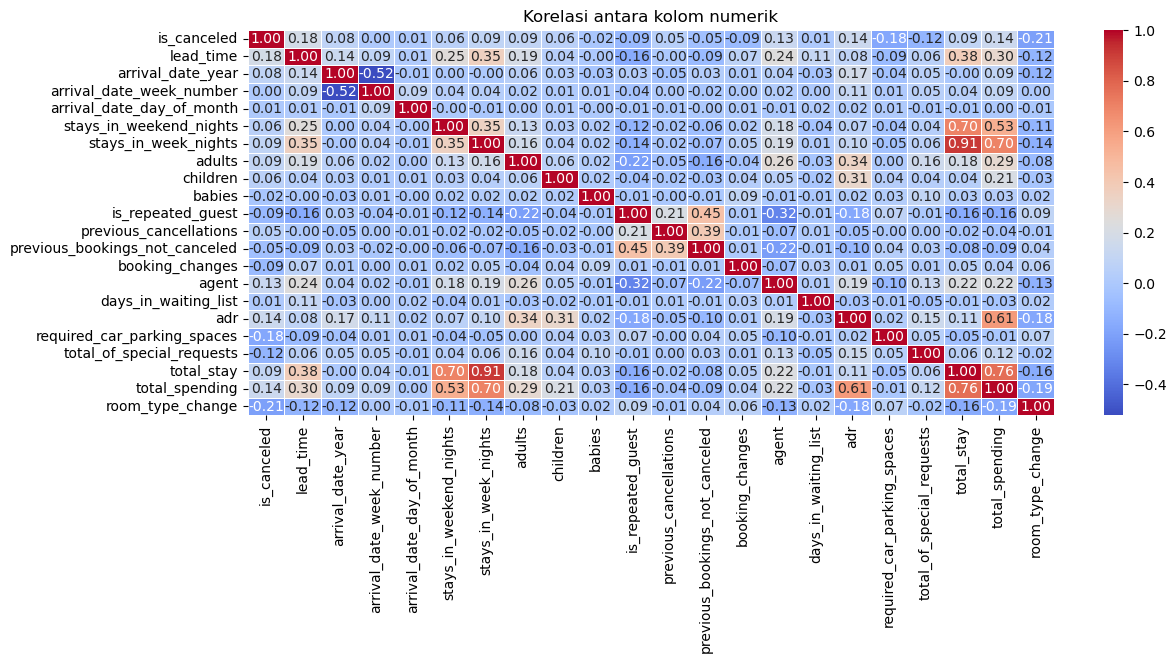

In [39]:
# Melihat korelasi antar kolom numerik
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number])
correlation_matrix = num_cols.corr()

plt.figure(figsize=(13, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korelasi antara kolom numerik")
plt.show()

Setelah adanya feature engineering, dapat dilihat kolom total_stay memiliki korelasi yang tinggi terhadap kolom stays_in_weekend_nights, stays_in_week_nights, dan total spending. Oleh karena itu, kolom total_stay nantinya akan didrop untuk menghindari adanya multikolinearitas pada model machine learning yang akan dibuat.

<h2>Data Analysis<h2>

Uji Statistik Numerik

-- lead_time --
H0 : Tidak ada perbedaan rata-rata lead_time antara pemesanan yang dibatalkan dan tidak

H1 : Ada perbedaan rata-rata lead_time antara pemesanan yang dibatalkan dan tidak

-- previous_cancellations --
H0 : Tidak ada perbedaan rata-rata jumlah pembatalan sebelumnya antara dua kelompok

H1 : Ada perbedaan rata-rata jumlah pembatalan sebelumnya antara kedua kelompok

-- booking_changes --
H0 : Tidak ada perbedaan rata-rata jumlah perubahan pemesanan antara kedua kelompok

H1 : Ada perbedaan rata-rata jumlah perubahan pemesanan antara kedua kelompok

-- days_in_waiting_list --
H0: Tidak ada perbedaaan rata-rata hari dalam daftar tunggu antara kedua kelompok

H1 : Ada perbedaan rata-rata hari dalam daftar tunggu antara kedua kelompok

-- days_in_waiting_list --
H0 : Tidak ada perbedaan rata-rata hari dalam daftar tunggu antara kedua kelompok

H1 : Ada perbedaan rata-rata hari dalam daftar tunggu antara kedua kelompok

-- adr --
H0 : Tidak ada perbedaan rata-rata tarif harian antara pemesanan yang dibatalkan dan tidak

H1 : Ada perbedaan rata-rata tarif harian antara pemesanan yang dibatalkan dan tidak

-- total_of_special_requests --
H0 : Tidak ada perbedaan rata-rata jumlah permintaan khusus antara kedua kelompok

H1 : Ada perbedaan rata-rata jumlah permintaan khusus antara kedua kelompok



In [40]:
print("\nUji Statistik Numerik berdasarkan Normalitas:\n")

for col, _, is_normal in normality_results:
    data_0 = df_num[df_num['is_canceled'] == 0][col]
    data_1 = df_num[df_num['is_canceled'] == 1][col]

    if is_normal:
        stat, pval = ttest_ind(data_0, data_1, equal_var=False)
        test_name = 'T-Test'
    else:
        stat, pval = mannwhitneyu(data_0, data_1, alternative='two-sided')
        test_name = 'Mann-Whitney U'

    mean_0 = data_0.mean()
    mean_1 = data_1.mean()

    print(f"{col:<35} | Test: {test_name:<15} | p-value: {pval:.4f} | Mean[0]: {mean_0:.2f} | Mean[1]: {mean_1:.2f} | Signifikan: {'Yes' if pval < 0.05 else 'No'}")



Uji Statistik Numerik berdasarkan Normalitas:

lead_time                           | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 70.10 | Mean[1]: 105.59 | Signifikan: Yes
previous_cancellations              | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.02 | Mean[1]: 0.06 | Signifikan: Yes
previous_bookings_not_canceled      | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.24 | Mean[1]: 0.04 | Signifikan: Yes
booking_changes                     | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.31 | Mean[1]: 0.16 | Signifikan: Yes
days_in_waiting_list                | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.72 | Mean[1]: 0.83 | Signifikan: Yes
adr                                 | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 102.27 | Mean[1]: 117.96 | Signifikan: Yes
total_of_special_requests           | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.76 | Mean[1]: 0.53 | Signifikan: Yes


Berdasarkan uji statistik, kolom-kolom yang sudah diuji normalitasnya memiliki pengaruh yang signifikan terhadap kolom target

<h3>Numerical Columns<h3>

<h4>ADR to Cancellation Status<h4>

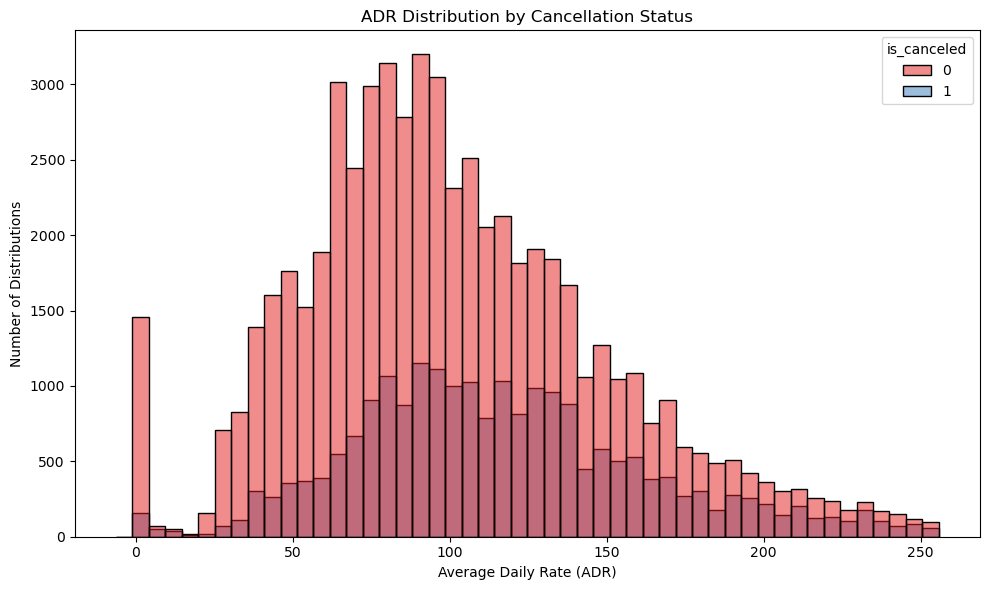

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure your DataFrame (e.g., df) contains 'adr' and 'is_canceled'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='adr', hue='is_canceled', bins=50, palette='Set1')

plt.title('ADR Distribution by Cancellation Status')
plt.xlabel('Average Daily Rate (ADR)')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


Kamar yang berakhir dibatalkan oleh tamu memuncak di harga 80-140, sedangkan kamar yang tidak dibatalkan para tamu memuncak di harga 70-100. Namun, kamar dengan tarif dibawah 50 didominasi oleh kamar yang tidak dibatalkan tamu.

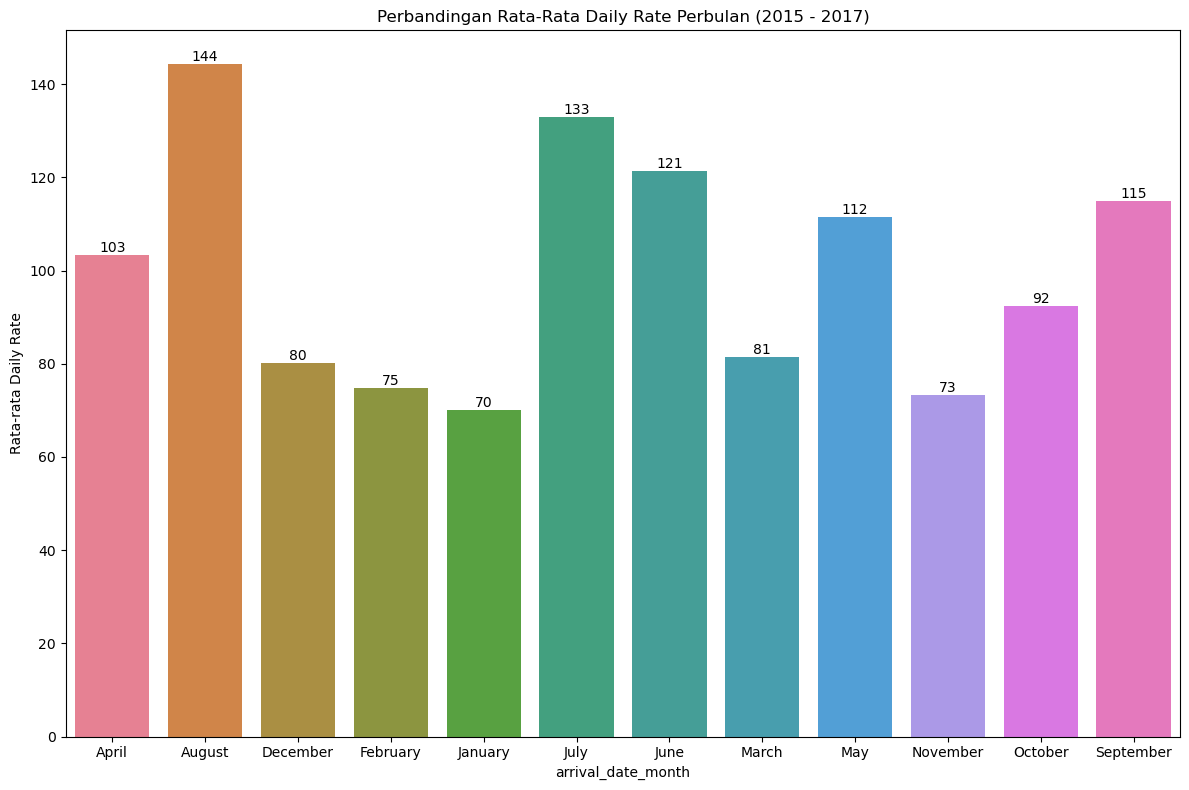

In [42]:
plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby('arrival_date_month')['adr']
      .mean()
      .reset_index()
      .rename(columns={'adr':'avg_adr'})
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='arrival_date_month', y='avg_adr', hue='arrival_date_month'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Rata-Rata Daily Rate Perbulan (2015 - 2017)')
plt.ylabel('Rata-rata Daily Rate')
plt.tight_layout()
plt.show()

- Bulan Agustus menjadi bulan dengan adr tertinggi, diikuti bulan Juli, Juni dan juga September.
- Hal ini bisa dikaitkan dengan season berdasarkan negara tempat hotel berada.

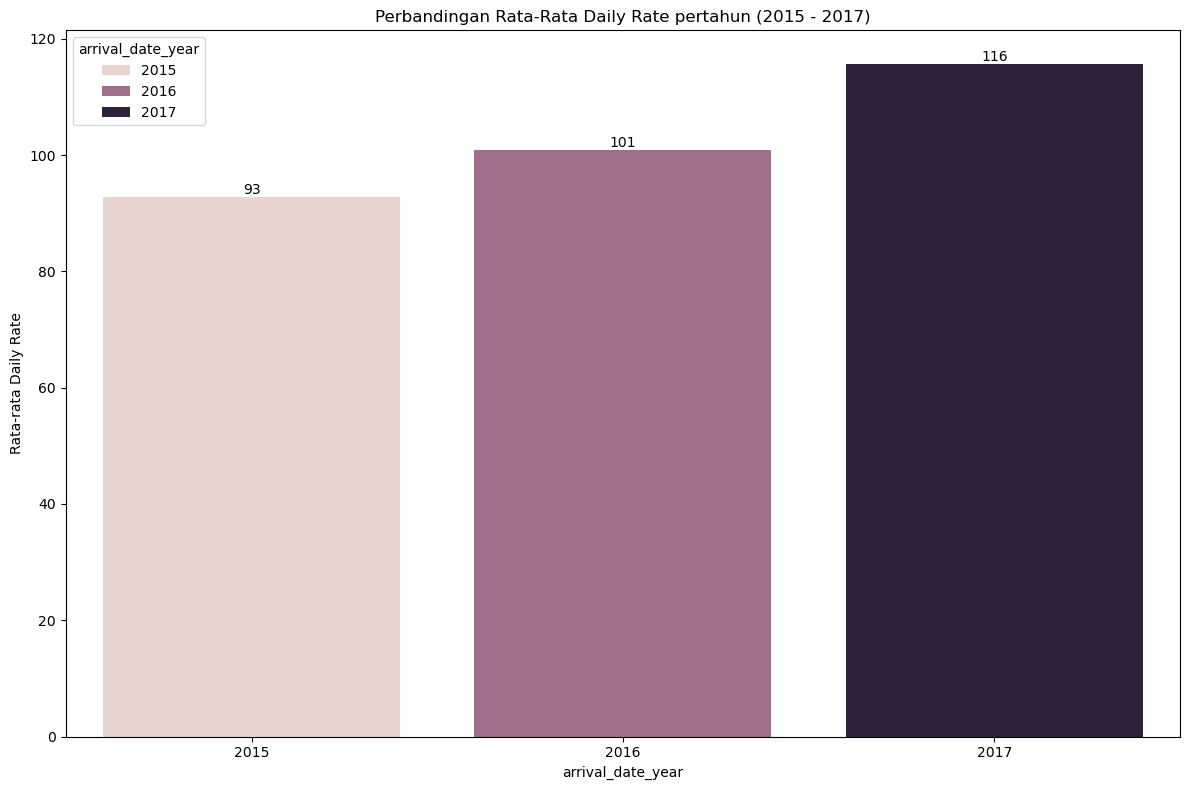

In [43]:
plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby('arrival_date_year')['adr']
      .mean()
      .reset_index()
      .rename(columns={'adr':'avg_adr'})
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='arrival_date_year', y='avg_adr', hue='arrival_date_year'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Rata-Rata Daily Rate pertahun (2015 - 2017)')
plt.ylabel('Rata-rata Daily Rate')
plt.tight_layout()
plt.show()

Riwayat pemesanan juga menunjukkan peningkatan tiap tahunnya dimana pada tahun 2015 mempunyai adr sebesar 93 kemudian pada tahun 2017 mempunyai adr sebesar 116.

<h4>Lead Time to Cancellation Status<h4>

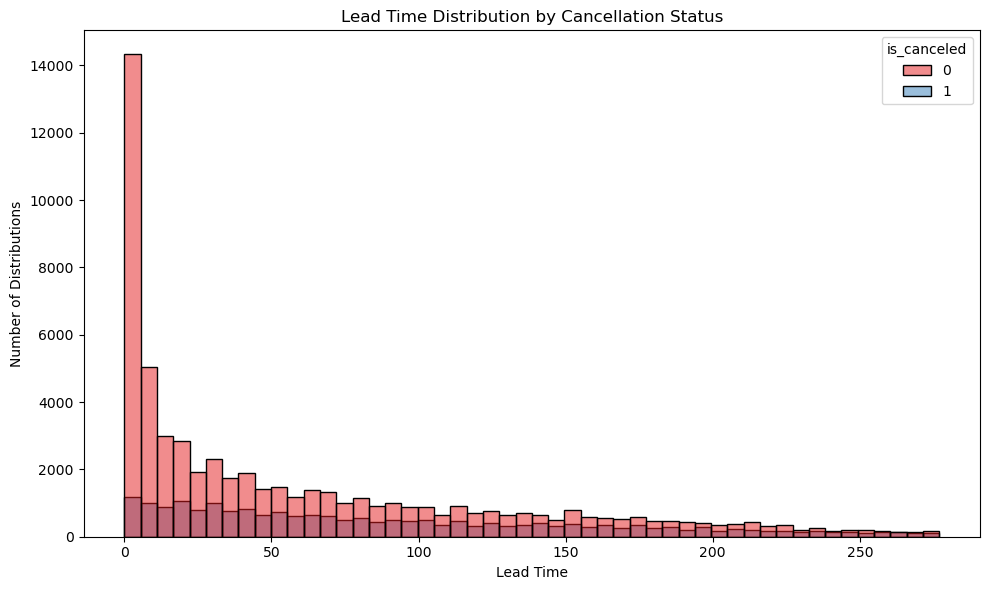

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='lead_time', hue='is_canceled', bins=50, palette='Set1')

plt.title('Lead Time Distribution by Cancellation Status')
plt.xlabel('Lead Time')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


Tamu yang lebih sedikit selisih waktu memesan dan check-in, lebih banyak tidak membatalkan pemesanan, memuncak di bawah 30 hari. Sedangkan, tamu yang membatalkan pemesanan cenderung stagnan namun semakin lama lead time proporsi tamu yang membatalkan jadi lebih banyak.

<h4>Stays in Weekend to Cancellation Status<h4>

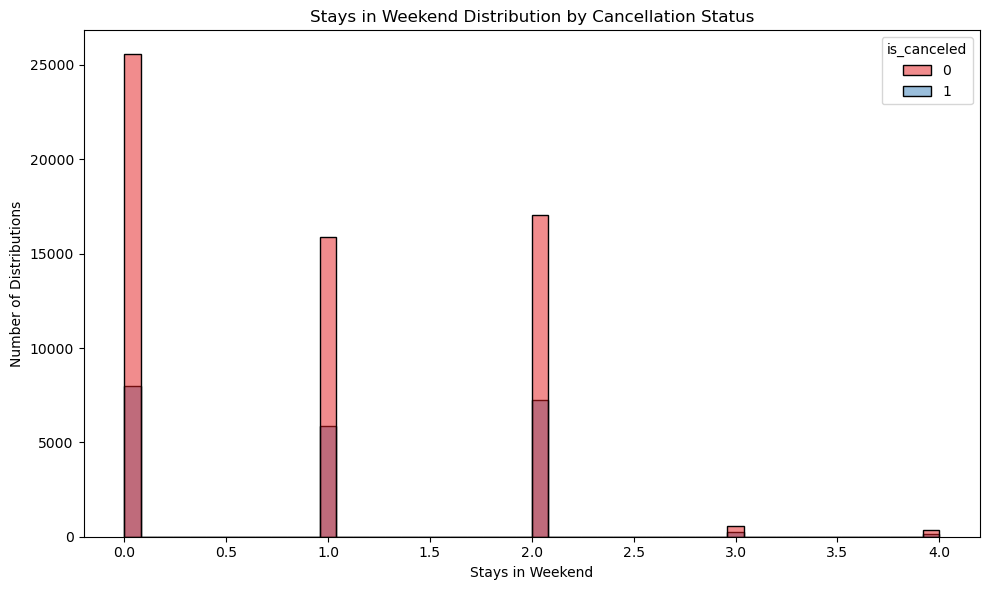

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='stays_in_weekend_nights', hue='is_canceled', bins=50, palette='Set1')

plt.title('Stays in Weekend Distribution by Cancellation Status')
plt.xlabel('Stays in Weekend')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


- Mayoritas tamu menginap tanpa weekend, diikuti dengan jumlah menginap 2 malam pada weekend
- Secara jumlah pemesanan, pemesanan tanpa di hari weekend menjadi yang paling banyak tidak dicancel maupun dicancel dibanding jumlah hari lainnya

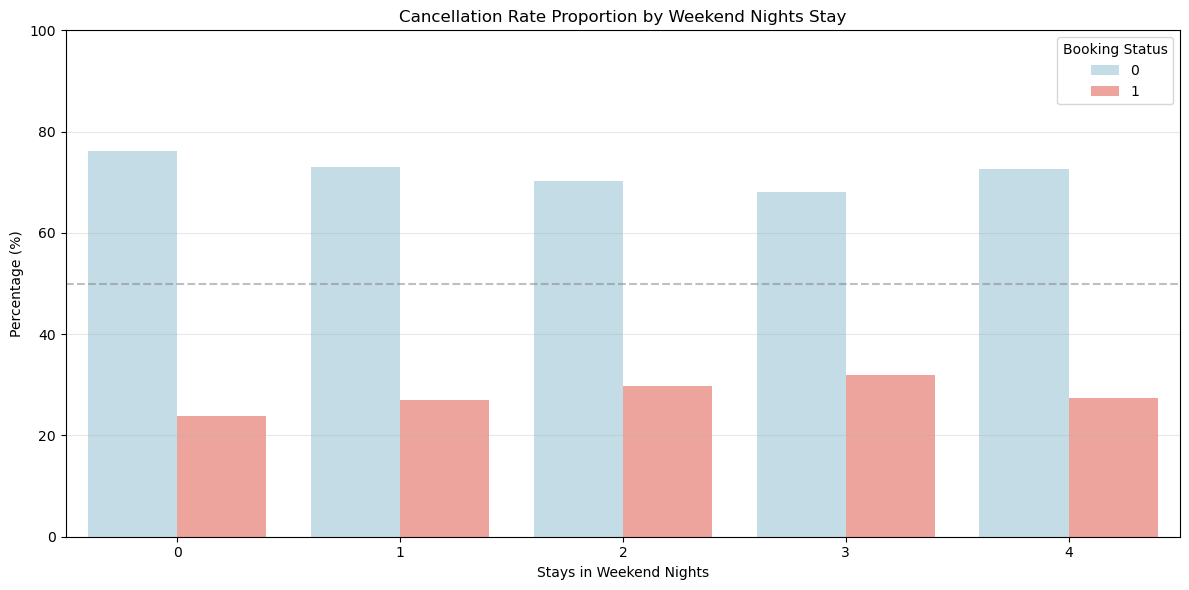

In [46]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('stays_in_weekend_nights')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='stays_in_weekend_nights',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='stays_in_weekend_nights', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Weekend Nights Stay')
plt.xlabel('Stays in Weekend Nights')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Secara Proporsi jumlah malam menginap, tamu yang memesan jumlah menginap 3 malam pada weekend memiliki tingkat pembatalan yang lebih tinggi.

<h4>Stays in Week to Cancellation Status<h4>

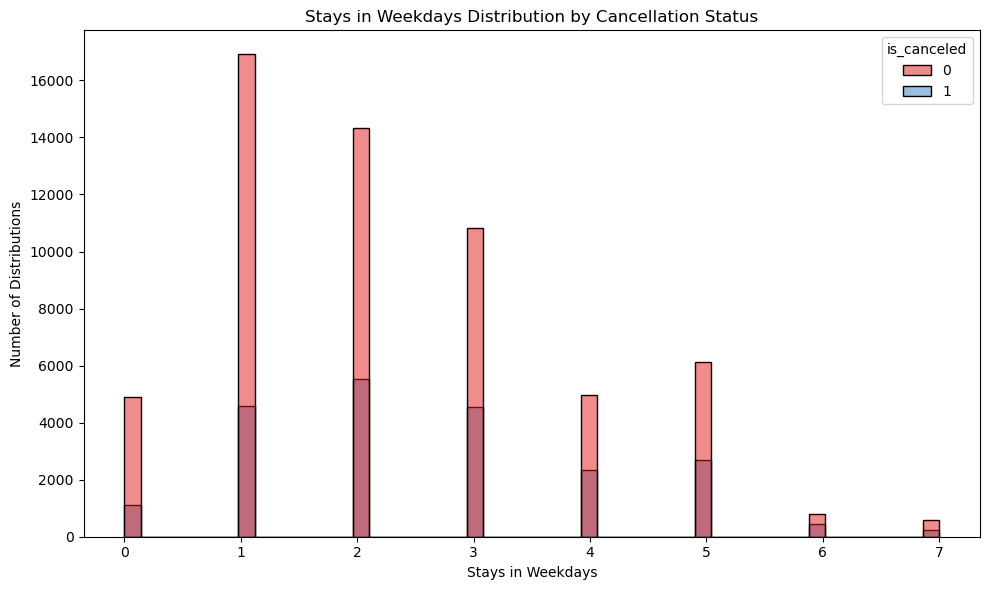

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='stays_in_week_nights', hue='is_canceled', bins=50, palette='Set1')

plt.title('Stays in Weekdays Distribution by Cancellation Status')
plt.xlabel('Stays in Weekdays')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


- Tamu paling banyak tidak membatalkan pemesanan terdapat di memesan 1 malam di weekdays, dengan 1-3 malam menjadi yang paling banyak dipesan oleh para tamu
- Tamu paling banyak yang membatalkan pemesanan terdapat di memesan 2 malam di weekdays.

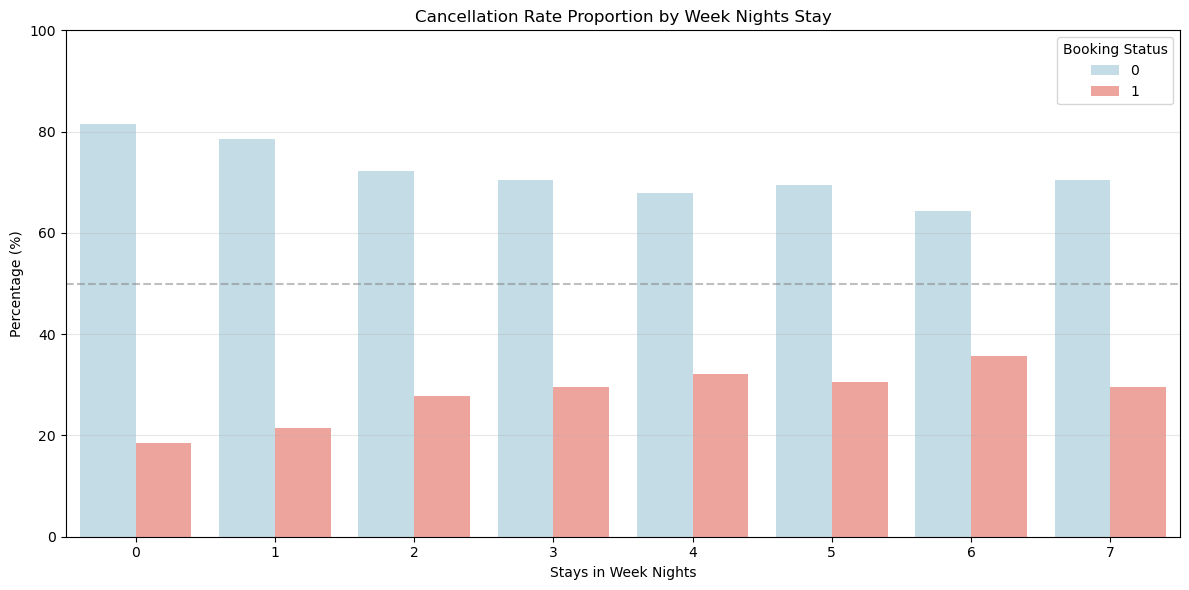

In [48]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('stays_in_week_nights')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='stays_in_week_nights',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='stays_in_week_nights', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Week Nights Stay')
plt.xlabel('Stays in Week Nights')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Secara proporsi jumlah malah menginap, tamu yang menginap 1-3 hari memiliki tingkat cancel yang lebih sedikit dibanding dengan tamu yang menginap lebih dari 4 hari

<h4>Total Stay to Cancellation Status<h4>

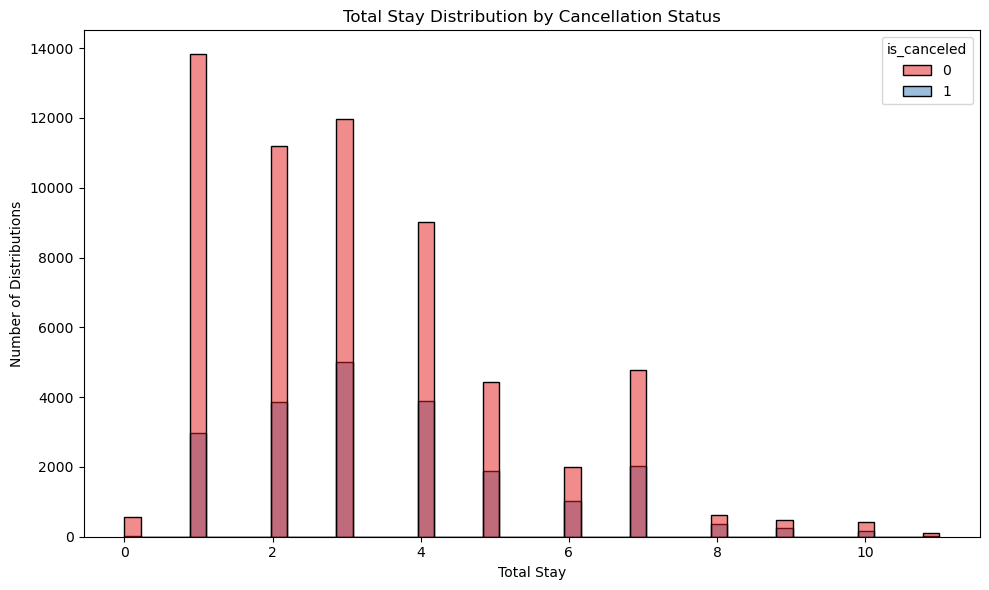

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='total_stay', hue='is_canceled', bins=50, palette='Set1')

plt.title('Total Stay Distribution by Cancellation Status')
plt.xlabel('Total Stay')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


- Tamu paling banyak tidak membatalkan pemesanan terdapat di memesan 1 malam pada jumlah menginap tamu, dengan jumlah menginap 1-4 hari total menginap yang paling banyak dipesan oleh para tamu
- Tamu paling banyak membatalkan pemesanan terdapat di memesan 3 malam pada jumlah menginap tamu dan secara proporsi terlihat jumlah cancel meningkat setelah total menginap lebih dari 4 hari

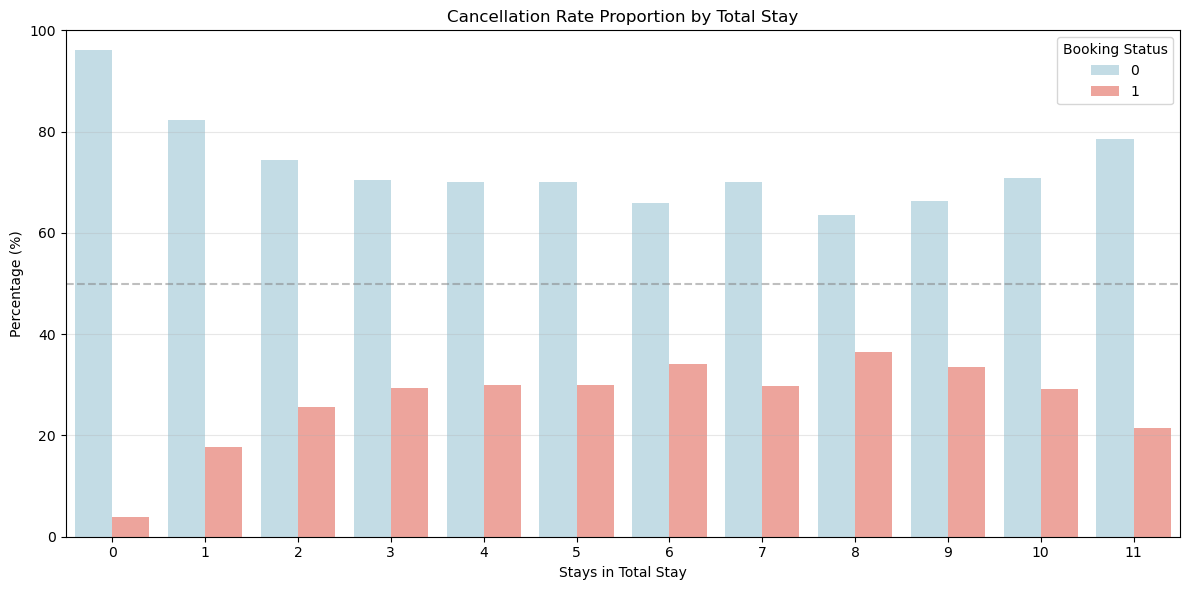

In [50]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('total_stay')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='total_stay',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='total_stay', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Total Stay')
plt.xlabel('Stays in Total Stay')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Secara proporsi total jumlah menginap weekday dan weekend, tamu yang memesan selama 8 malam memiliki tingkat cancel lebih tinggi dibanding jumlah malam lainnya 

<h4>Adults to Cancellation Status<h4>

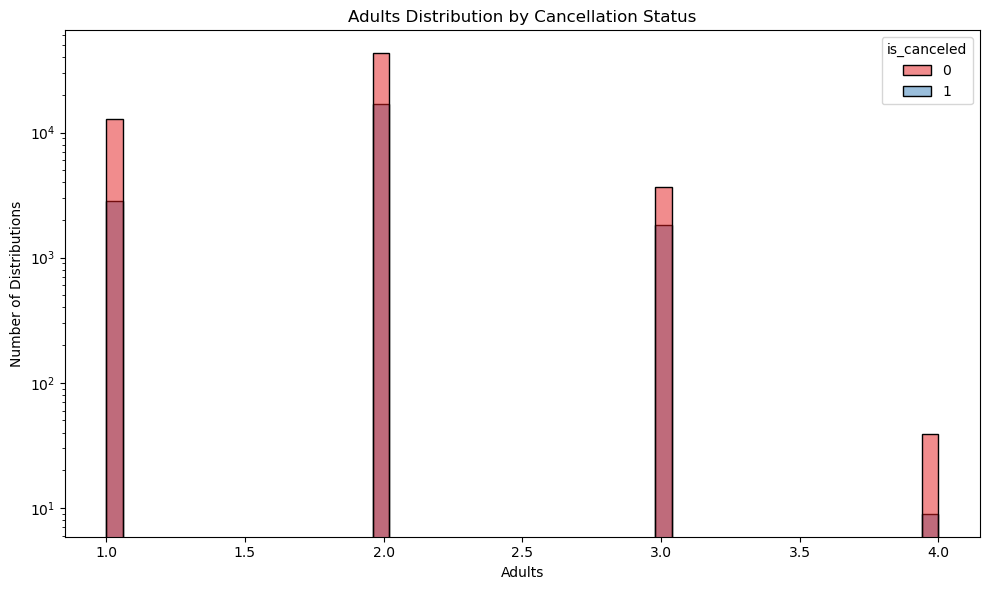

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='adults', hue='is_canceled', bins=50, palette='Set1')

plt.title('Adults Distribution by Cancellation Status')
plt.xlabel('Adults')
plt.ylabel('Number of Distributions')
plt.yscale('log')
plt.tight_layout()
plt.show()


- Mayoritas pemesanan dilakukan oleh adults berjumlah 2 orang, dengan perbandingan tidak cancel jauh lebih banyak dibanding yang cancel
- Namun disisi lain, tingkat cancel pada adults berjumlah 2 orang ini juga cukup tinggi dibanding dengan yang lainnya.

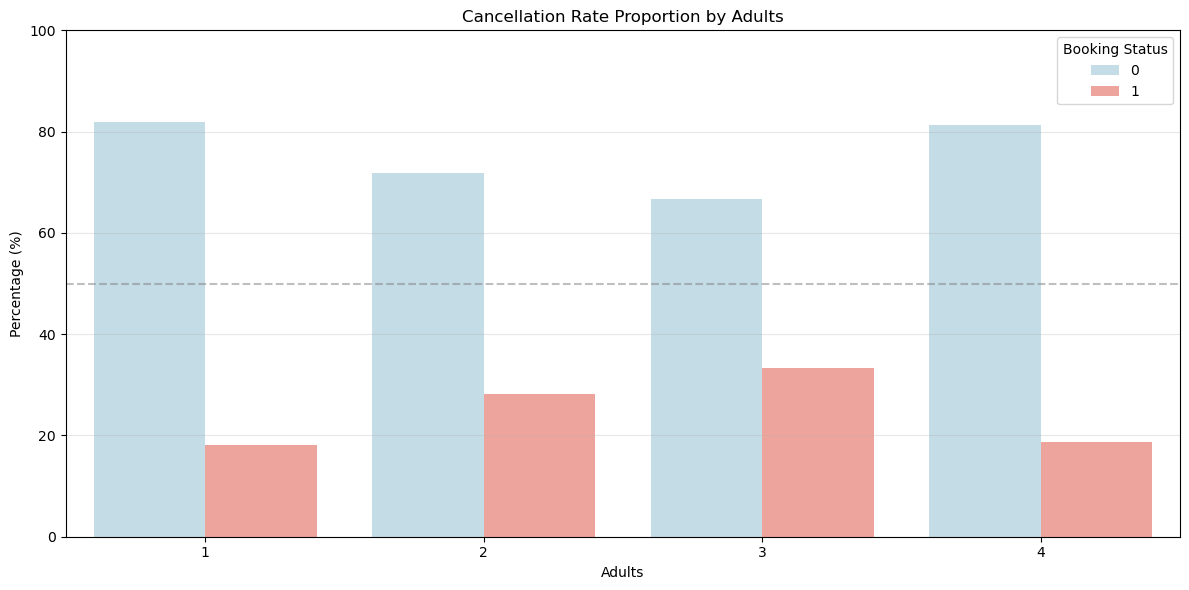

In [52]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('adults')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='adults',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='adults', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Adults')
plt.xlabel('Adults')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Secara persentase, jumlah adults 2-3 orang memiliki tingkat cancel yang tinggi dibanding jumlah adults lainnya, bahkan adults yang berjumlah 4 memiliki persentase yang hampir sama dengan yang berjumlah 1 orang

<h4>Children to Cancellation Status<h4>

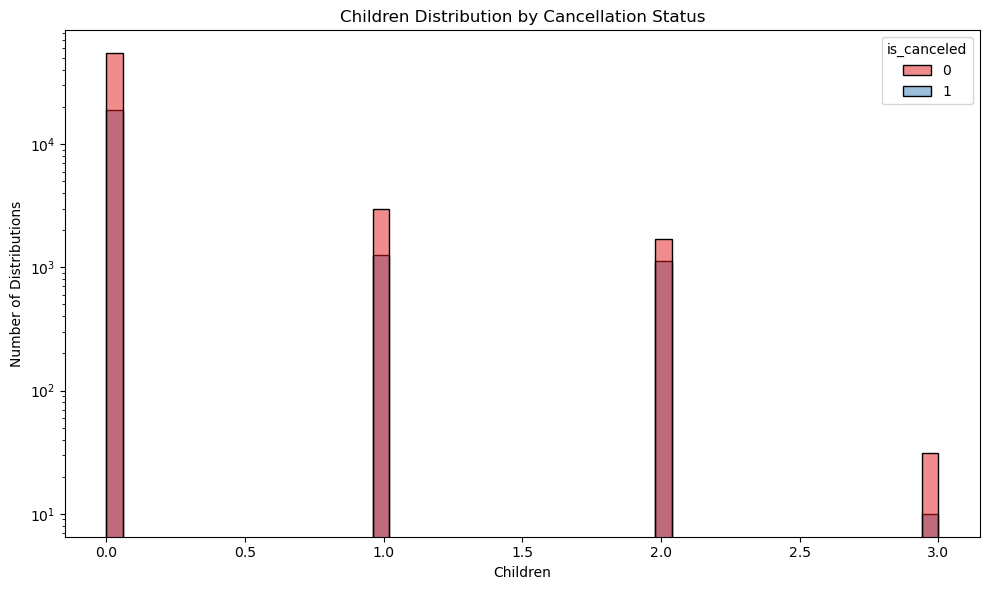

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='children', hue='is_canceled', bins=50, palette='Set1')

plt.title('Children Distribution by Cancellation Status')
plt.xlabel('Children')
plt.ylabel('Number of Distributions')
plt.yscale('log')
plt.tight_layout()
plt.show()


- Kebanyakan pemesanaan dilakukan tanpa membawa anak kecil, dengan jumlah perbandingan yang cukup jauh dengan jumlah membawa anak kecil lainnya
- Sementara keluarga/adults dengan anak-anak mewakili volume pemesanan yang jauh lebih kecil, perilaku pembatalan mereka tampaknya tidak jauh berbeda dari tamu tanpa anak

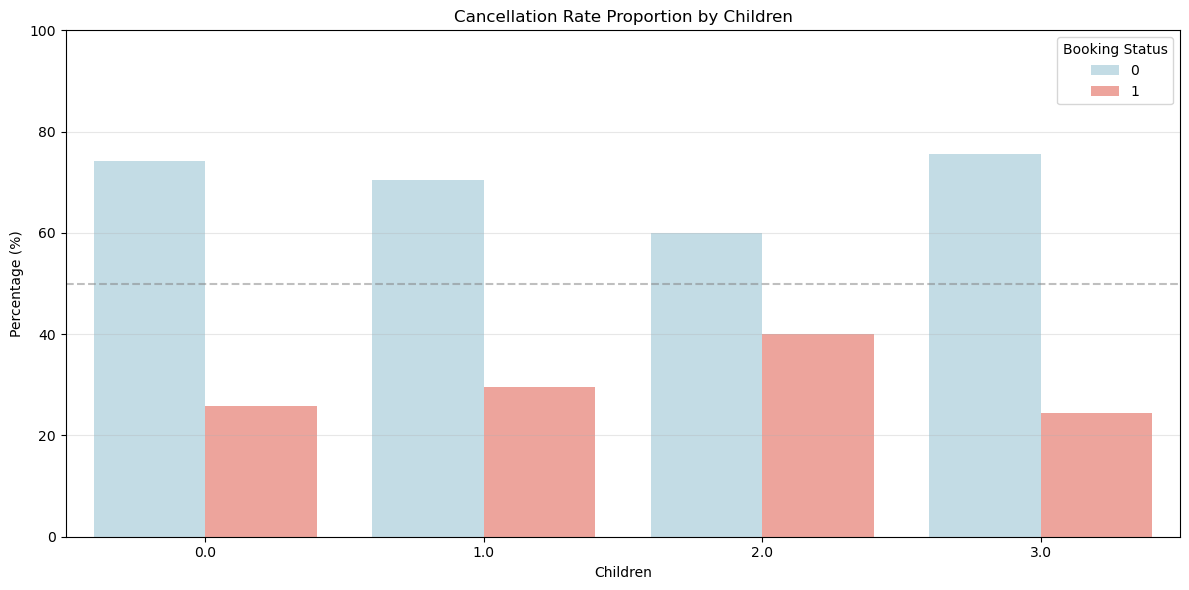

In [54]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('children')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='children',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='children', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Children')
plt.xlabel('Children')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Secara persentase, adults yang membawa 2 anak kecil memiliki tingkat cancel yang lebih tinggi dibanding dengan yang membawa anak kecil kurang dari 2 ataupun 3.

<h4>Required Car Parking to Cancellation Status<h4>

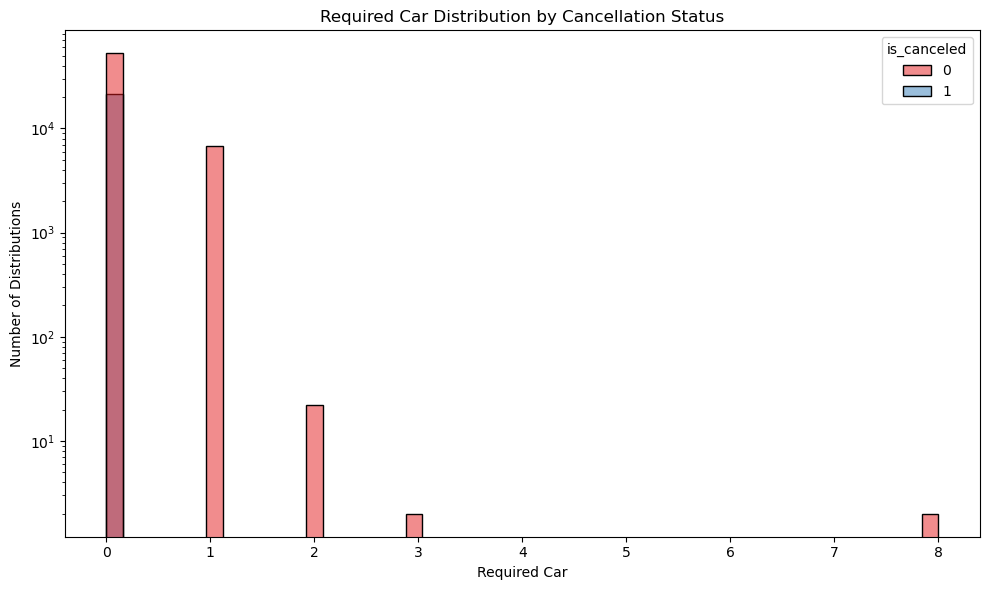

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='required_car_parking_spaces', hue='is_canceled', bins=50, palette='Set1')

plt.title('Required Car Distribution by Cancellation Status')
plt.xlabel('Required Car')
plt.ylabel('Number of Distributions')
plt.yscale('log')

plt.tight_layout()
plt.show()


- Pemesanan tanpa adanya permintaan slot parkir menjadi yang paling banyak dengan perbandingan yang cukup berbeda dengan jumlah permintaan lainnya
- Namun, tingkat cancel pada 0 permintaan slot parkir menjadi yang paling banyak, tidak ada pembatalan pemesanan pada permintaan slot parkir lebih dari 0

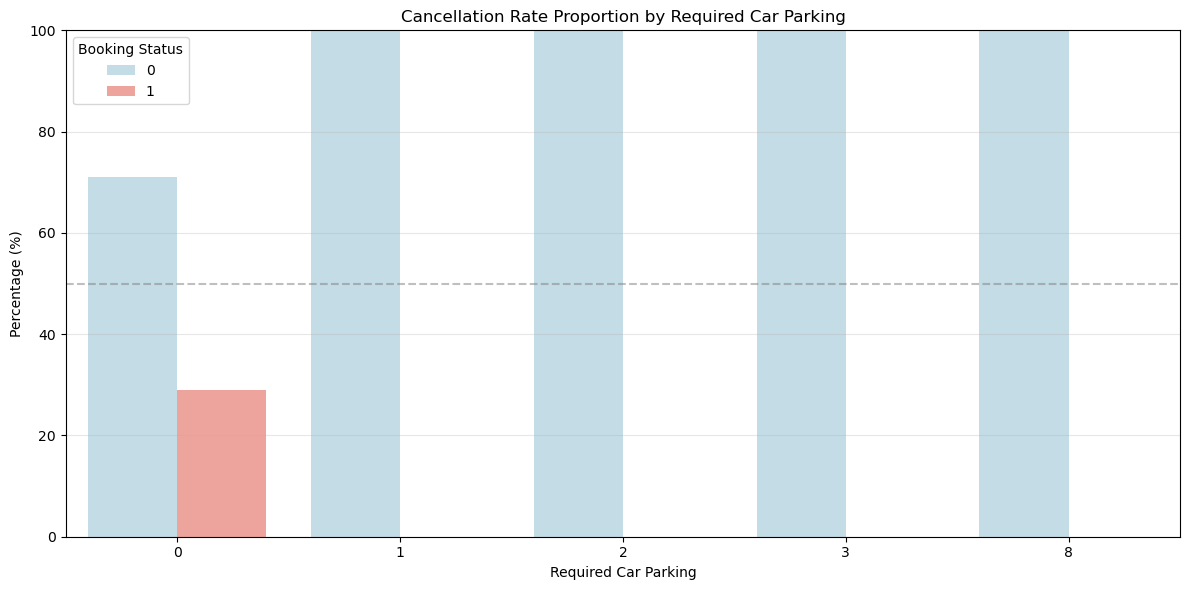

In [56]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('required_car_parking_spaces')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='required_car_parking_spaces',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='required_car_parking_spaces', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Required Car Parking')
plt.xlabel('Required Car Parking')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Seperti yang sudah dijelaskan sebelumnya, pemesanan dengan permintaan slot parkir lebih dari 0 tidak ditemukan adanya pembatalan pemesanan

<h4>Total Special Request to Cancellation Status<h4>

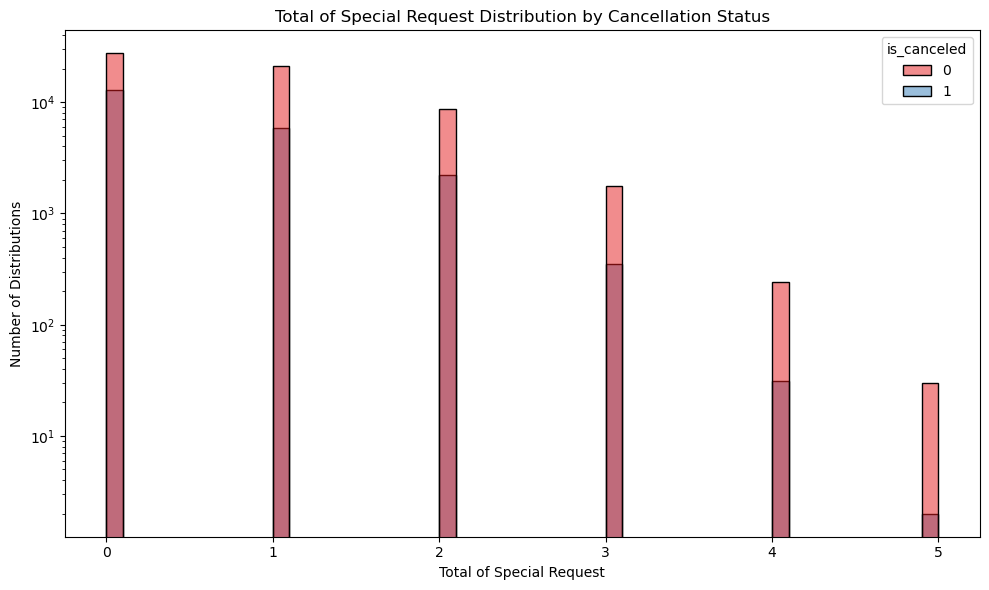

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='total_of_special_requests', hue='is_canceled', bins=50, palette='Set1')

plt.title('Total of Special Request Distribution by Cancellation Status')
plt.xlabel('Total of Special Request')
plt.ylabel('Number of Distributions')
plt.yscale('log')
plt.tight_layout()
plt.show()


- Terlihat bahwa semakin banyak permintaan spesial semakin berkurang juga jumlah pemesanan
- Pemesanan tanpa permintaan spesial menjadi pemesanan paling banyak dengan jumlah cancel yang lebih banyak juga dibanding jumlah permintaan spesial lainnya

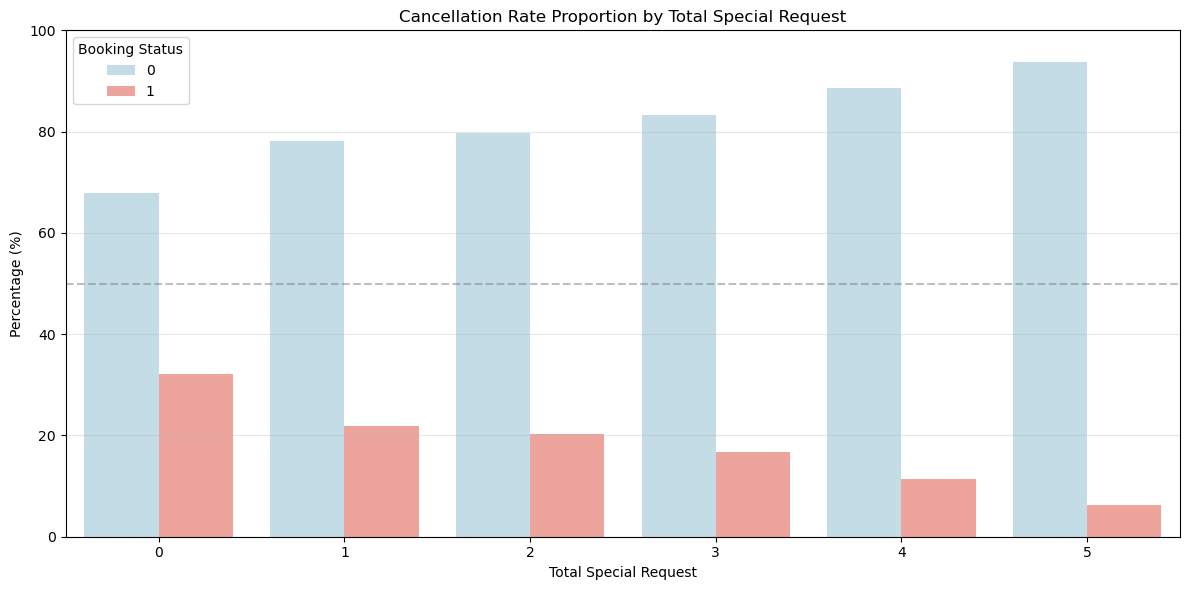

In [58]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('total_of_special_requests')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='total_of_special_requests',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='total_of_special_requests', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Total Special Request')
plt.xlabel('Total Special Request')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Terlihat jelas juga secara persentasi semakin berkurang jumlah permintaan spesialnya semakin berkurang persentase permintaan yang dibatalkan

<h4>Booking Changes to Cancellation Status<h4>

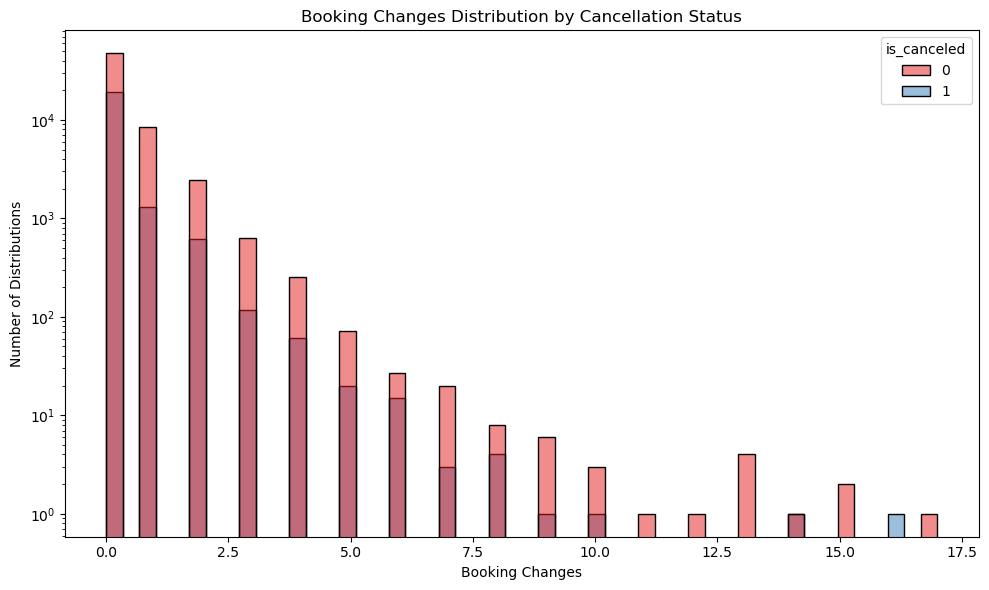

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='booking_changes', hue='is_canceled', bins=50, palette='Set1')

plt.title('Booking Changes Distribution by Cancellation Status')
plt.xlabel('Booking Changes')
plt.ylabel('Number of Distributions')
plt.yscale('log')
plt.tight_layout()
plt.show()


- Kebanyakan pemesanan dilakukan tanpa adanya perubahan oleh para tamu menunjukkan tamu lebih berkomitmen dengan pilihan hotel mereka.
- Namun, jumlah pemesanan yang dibatalkan tanpa adanya perubahan menunjukkan jumlah pembatalan yang tinggi dibanding dengan yang lainnya

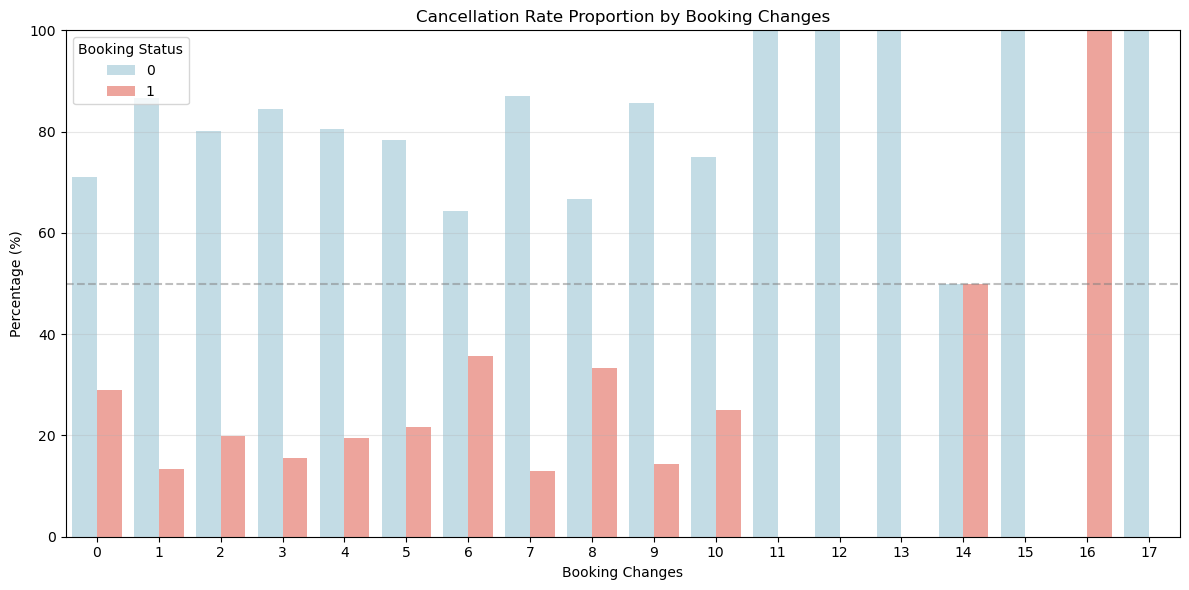

In [60]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('booking_changes')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='booking_changes',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='booking_changes', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Booking Changes')
plt.xlabel('Booking Changes')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Terlihat pada pemesanan tanpa perubahan, memiliki persentase sedikit lebih tinggi dibanding 1-5 perubahan yang diminta oleh tamu. Kemudian persentase naik pada 6 dan 8 perubahan. Hal ini menunjukkan keabstrakan pada pembatalan atau tidaknya sebuah pemesanan.

<h4>Previous Cancellations to Cancellation Status<h4>

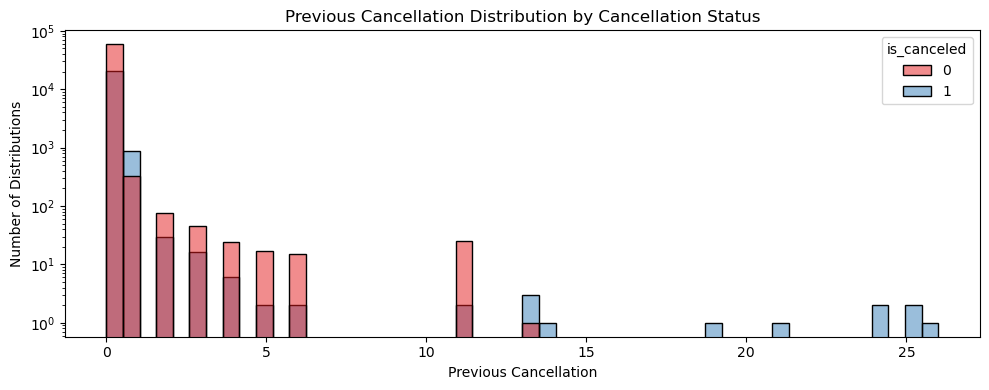

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
sns.histplot(data=df_hotel_demand_bookings, x='previous_cancellations', hue='is_canceled', bins=50, palette='Set1')

plt.title('Previous Cancellation Distribution by Cancellation Status')
plt.xlabel('Previous Cancellation')
plt.ylabel('Number of Distributions')
plt.yscale('log')
plt.tight_layout()
plt.show()


- Tamu-tamu yang tidak memiliki riwayat melakukan pembatalan menjadi pemesan yang paling banyak
- Namun, faktor pertama kali ini yang membuat tingkat cancel juga cukup tinggi
- Untuk tamu yang pernah membatalkan 1 kali memiliki jumlah pembatalan lebih tinggi dibanding yang tidak membatalkan pada pemesanan mereka untuk yang kedua kalinya.

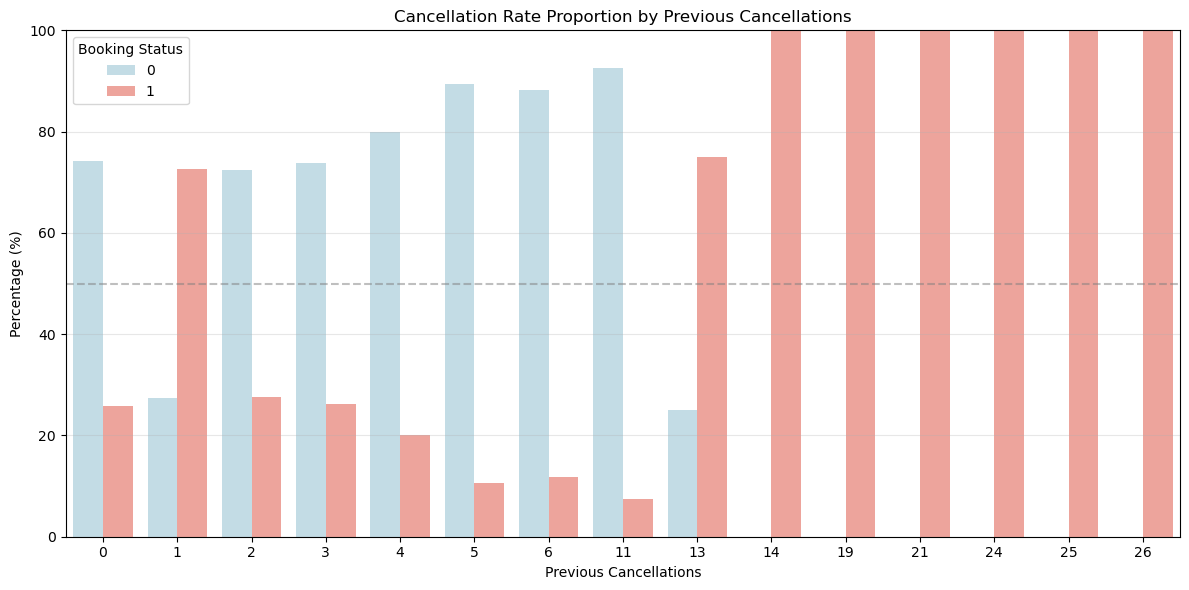

In [62]:
plt.figure(figsize=(12, 6))

# Hitung proporsi untuk setiap durasi menginap
prop_data = df_hotel_demand_bookings.groupby('previous_cancellations')['is_canceled'].value_counts(normalize=True).unstack() * 100

# Melt data untuk seaborn
melted_prop = prop_data.reset_index().melt(
id_vars='previous_cancellations',
var_name='status',
value_name='percentage'
)

# Plot
sns.barplot(data=melted_prop, x='previous_cancellations', y='percentage', hue='status',
        palette=['lightblue', 'salmon'], alpha=0.8)

plt.title('Cancellation Rate Proportion by Previous Cancellations')
plt.xlabel('Previous Cancellations')
plt.ylabel('Percentage (%)')
plt.legend(title='Booking Status')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 100)

# Tambahkan garis referensi di 50%
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Secara persentasi, dapat dilihat tamu yang pernah membatalkan antara 2-11 kali ternyata memiliki persentase pembatalan yang jauh lebih rendah dibanding dengan tamu yang baru sekali melakukan pembatalan.
- Disisi lain, tamu yang sudah pernah membatalkan pemesanan sebelumya lebih dari 13 kali belum pernah berhasil dalam pemesanannya.

<h4>Total Spending to Cancellation Status<h4>

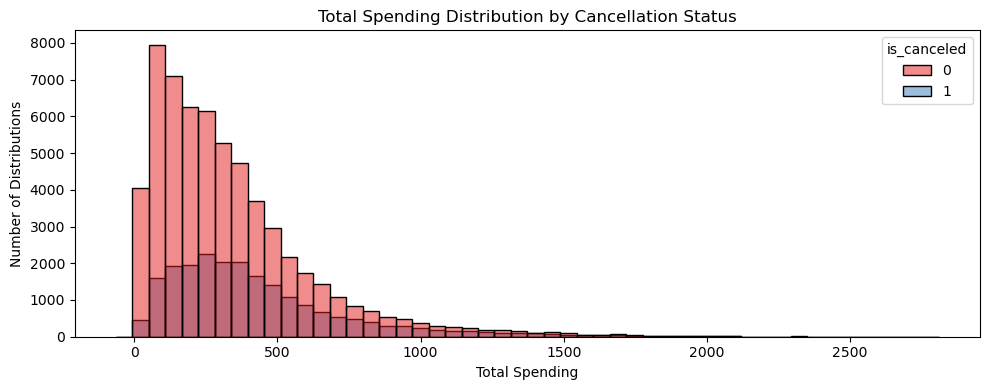

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
sns.histplot(data=df_hotel_demand_bookings, x='total_spending', hue='is_canceled', bins=50, palette='Set1')

plt.title('Total Spending Distribution by Cancellation Status')
plt.xlabel('Total Spending')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


- Puncak pemesaan yang berhasil berada di range 100-300
- secara proporsi, semakin besar tarif yang dikeluarkan tamu pada sekali menginap ini cenderung melakukan pembatalan yang lebih tinggi

<h4>Room Type Change to Cancellation Status<h4>

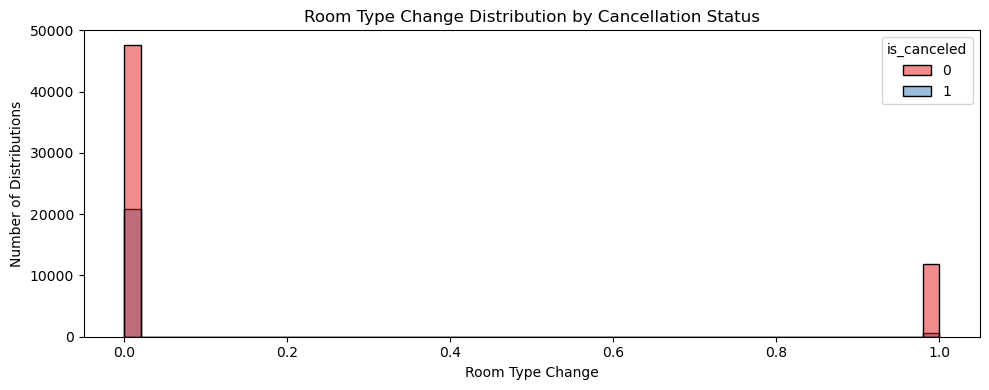

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
sns.histplot(data=df_hotel_demand_bookings, x='room_type_change', hue='is_canceled', bins=50, palette='Set1')

plt.title('Room Type Change Distribution by Cancellation Status')
plt.xlabel('Room Type Change')
plt.ylabel('Number of Distributions')

plt.tight_layout()
plt.show()


- Proporsi pemesanan yang dibatalkan terlihat lebih tinggi untuk tamu yang mengubah tipe kamar dibandingkan dengan mereka yang tidak mengubah apapun 
- Tamu yang tidak mengubah tipe kamar menunjukkan tingkat pembatalan yang lebih rendah, yang menunjukkan bahwa mereka berkomitmen terhadap pemesanan mereka

<h3> Categorical Columns <h3>

In [65]:
def plot_default(feature) :
        plt.figure(figsize=(12,6))
        if feature == "arrival_date_month" or "reserved_room_type" or "assigned_room_type":
                plot = sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'],
                        palette='magma', order=df_hotel_demand_bookings[feature].value_counts(ascending=False).index)
        else :
                plot = sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'],
                        palette='magma', order=df_hotel_demand_bookings[feature].value_counts(ascending=False).iloc[:10].index)
        for container in plot.containers:
                plot.bar_label(container, label_type='edge', fontsize=12)
        plt.title("Counts of Booking Cancellation by {}".format(feature))
        plt.show()

In [66]:

def plot_percentage(feature) :
    # Step 1: Focus on Top 10 Countries
    if feature == "arrival_date_month" or "reserved_room_type" or "assigned_room_type":
        top_feature = df_hotel_demand_bookings[feature].value_counts().iloc[:12].index
        df_top = df_hotel_demand_bookings[df_hotel_demand_bookings[feature].isin(top_feature)]
    else :
        top_feature = df_hotel_demand_bookings[feature].value_counts().iloc[:10].index
        df_top = df_hotel_demand_bookings[df_hotel_demand_bookings[feature].isin(top_feature)]

    # Step 2: Group and calculate percentage within each hotel
    group_counts = df_top.groupby([feature, 'is_canceled']).size().rename('count').reset_index()
    total_counts = group_counts.groupby(feature)['count'].transform('sum')
    group_counts['percent'] = (group_counts['count'] / total_counts) * 100

    # Step 3: Optional - map is_canceled to label
    group_counts['is_canceled'] = group_counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

    # Step 4: Plot
    plt.figure(figsize=(12, 6))
    plot = sns.barplot(
        data=group_counts,
        x=feature, y='percent', hue='is_canceled',
        palette='Set2'
    )

    # Step 5: Label the bars
    for container in plot.containers:
        plot.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9)

    plt.title('Percentage of Booking Cancellations by {}'.format(feature))
    plt.ylabel('Percentage (%)')
    plt.xlabel(feature)
    plt.legend(title='Booking Status')
    plt.tight_layout()
    plt.show()

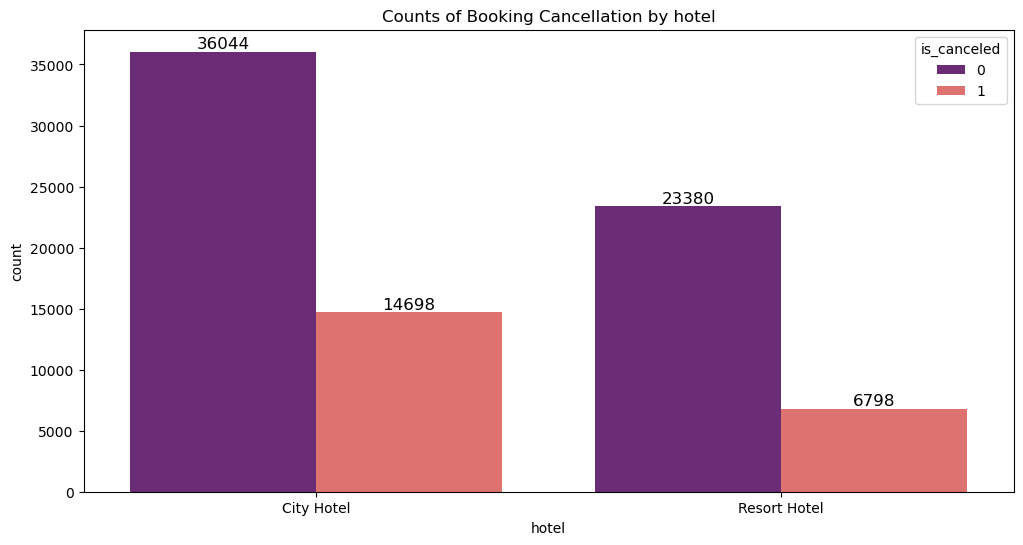

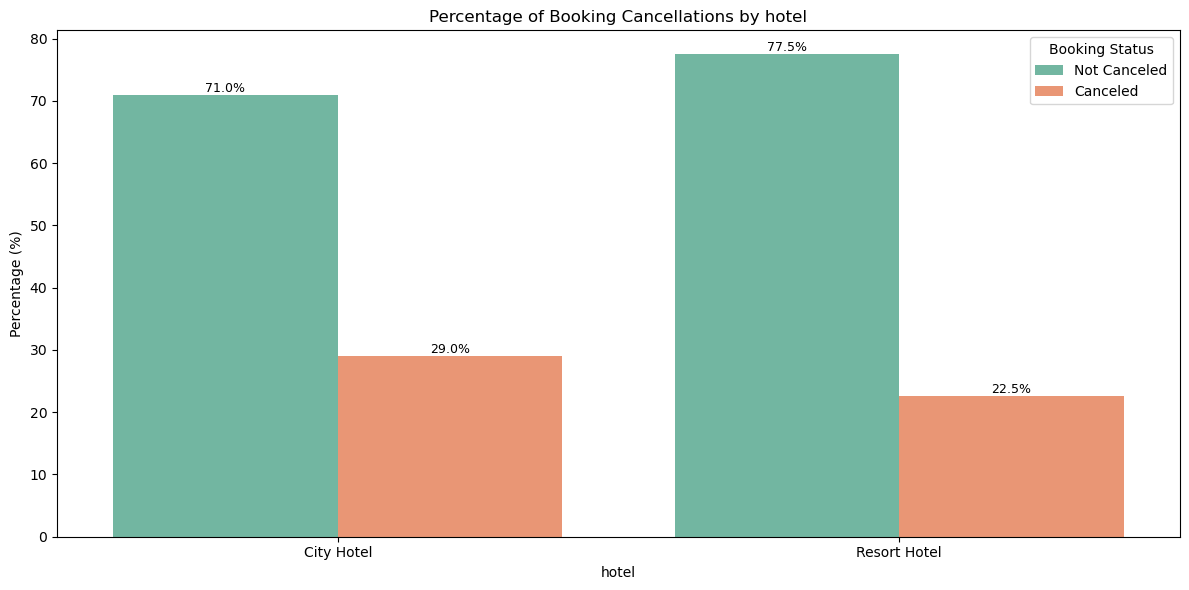

In [67]:
plot_default('hotel')
plot_percentage('hotel')

- Meskipun jumlah pemesanan terbanyak terdapat pada city hotel, namun secara persentasi tingkat keberhasilan pemesanan dimiliki oleh resort hotel
- Persentase pembatalan pemesenan pun lebih tinggi city hotel dibandingkan resort hotel

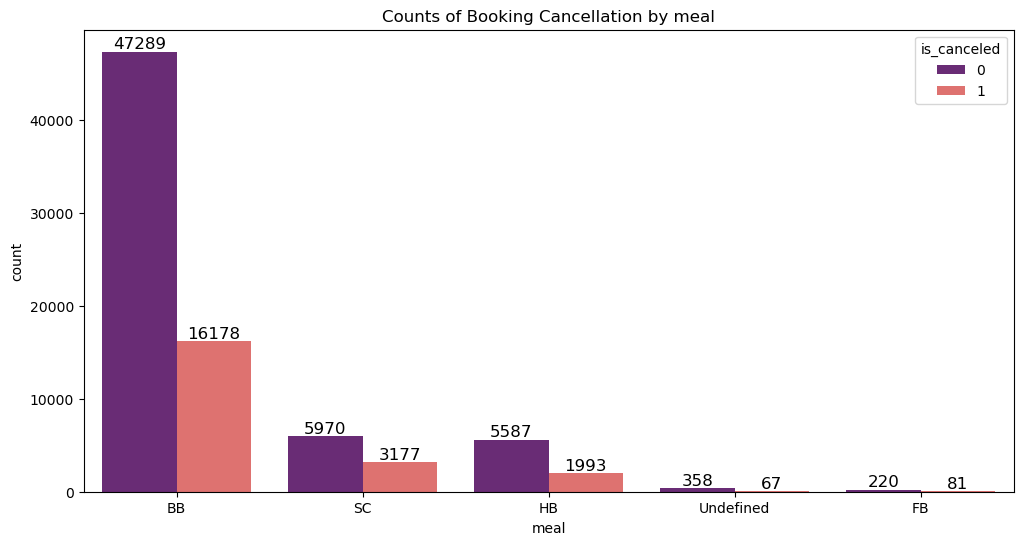

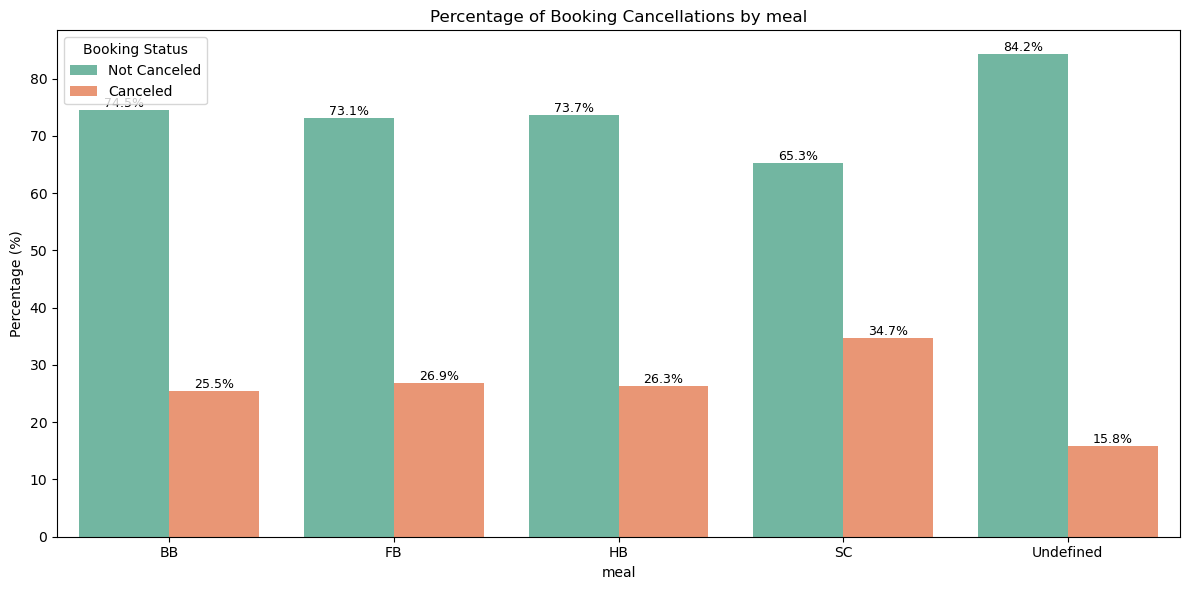

In [68]:
plot_default('meal')
plot_percentage('meal')

- Tipe makanan BB menjadi yang paling banyak dipilih oleh tamu dengan tingkat keberhasilan pemesanan yang sedikit lebih tinggi dibanding tipe makanan lainnya.
- Tipe SC, tipe makanan terbanyak kedua yang dipilih ternyata memiliki persentase pembatalan pemesanan yang cukup lebih tinggi dibanding tipe makanan lainnya.

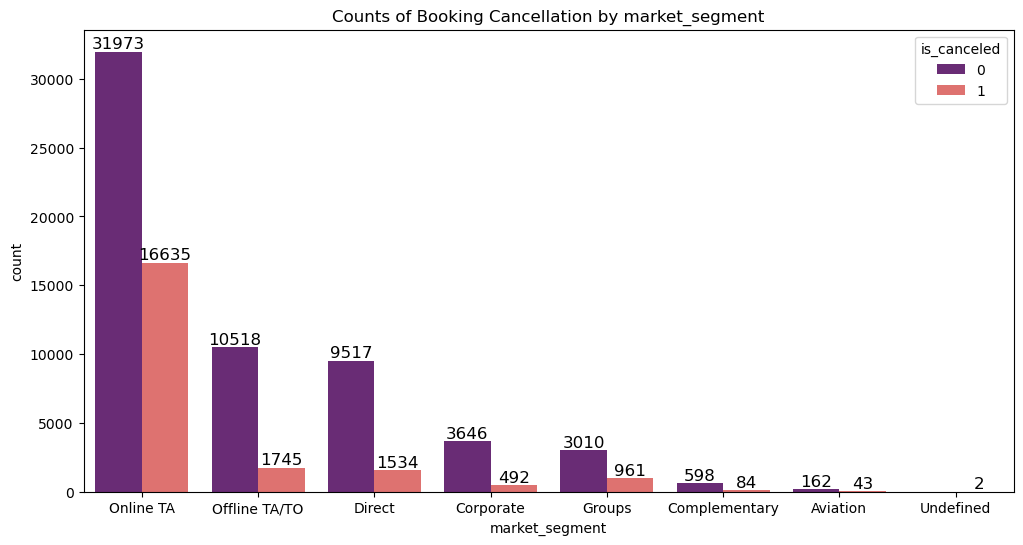

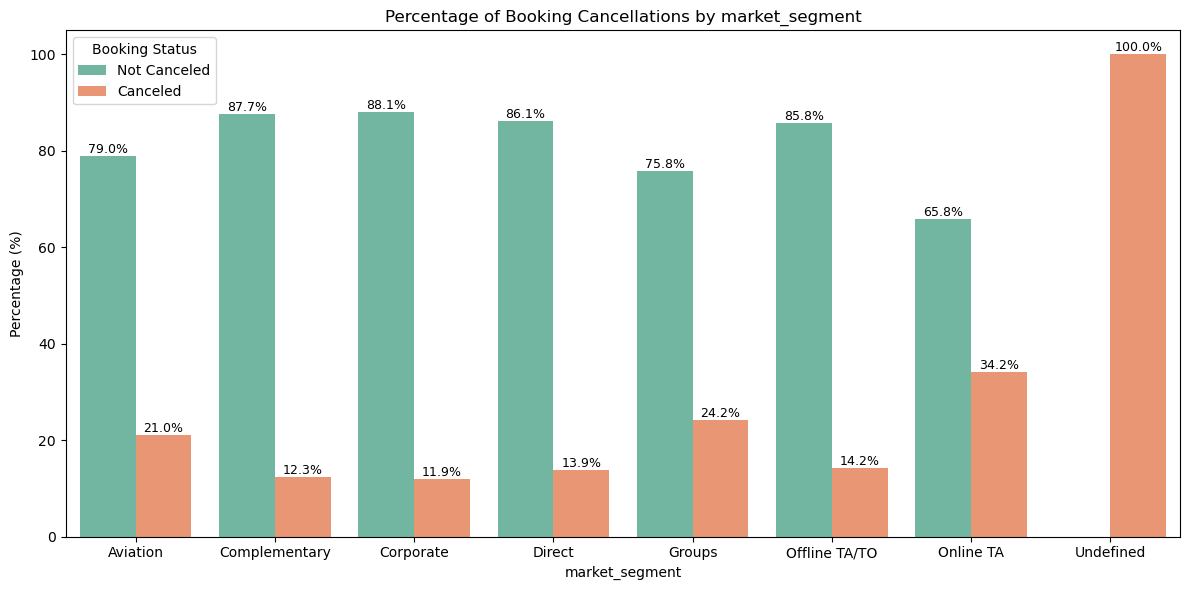

In [69]:
plot_default('market_segment')
plot_percentage('market_segment')

- Online TA merupakan market segment yang melakukan pemesanan terbanyak namun menjadi tingkat pembatalan pemesanan paling tinggi diantara market segment lainnya.
- Market Segment Complementary, Corporate, Direct, dan Offline TA/TO, walaupun jumlah pemesanan jauh dibawah Online TA, mereka menunjukkan keberhasilan pemesanan yang sangat tinggi. Dapat dikatakan bahwa market segmen ini cukup pontensial

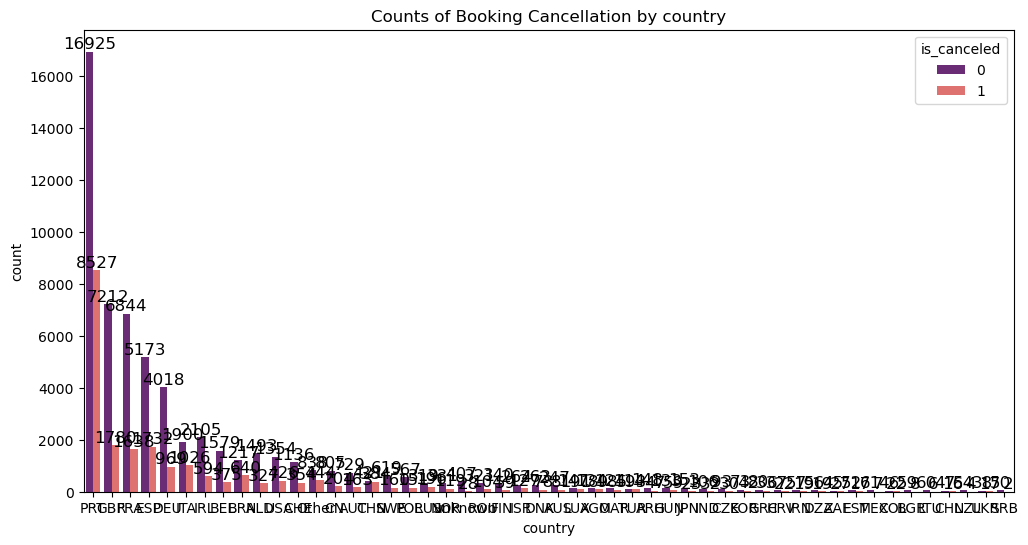

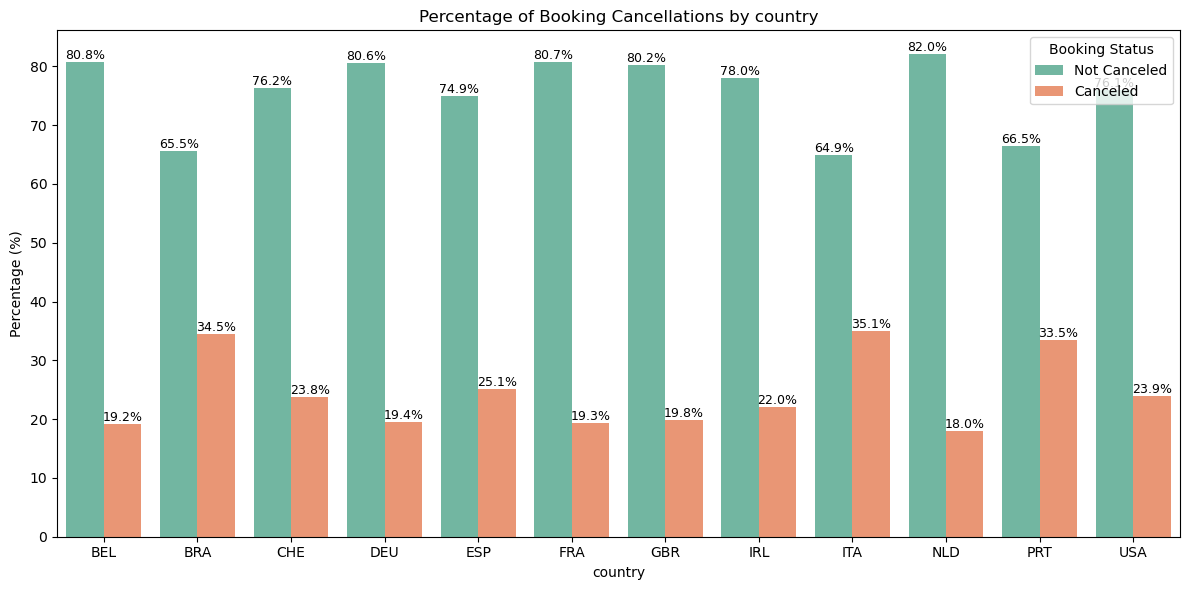

In [70]:
plot_default('country')
plot_percentage('country')

- Negara Portugal, dengan jumlah pemesanan terbanyak ternyata memiliki tingkat pembatalan pemesanan kedua tertinggi
- Negara-negara seperti Belgia, Prancis, Jerman, Britania raya, Belanda menunjukkan tingkat keberhasilan pemesanan yang cukup tinggi meskipun jumlah pemesanan yang jauh dibawah negara Portugal.

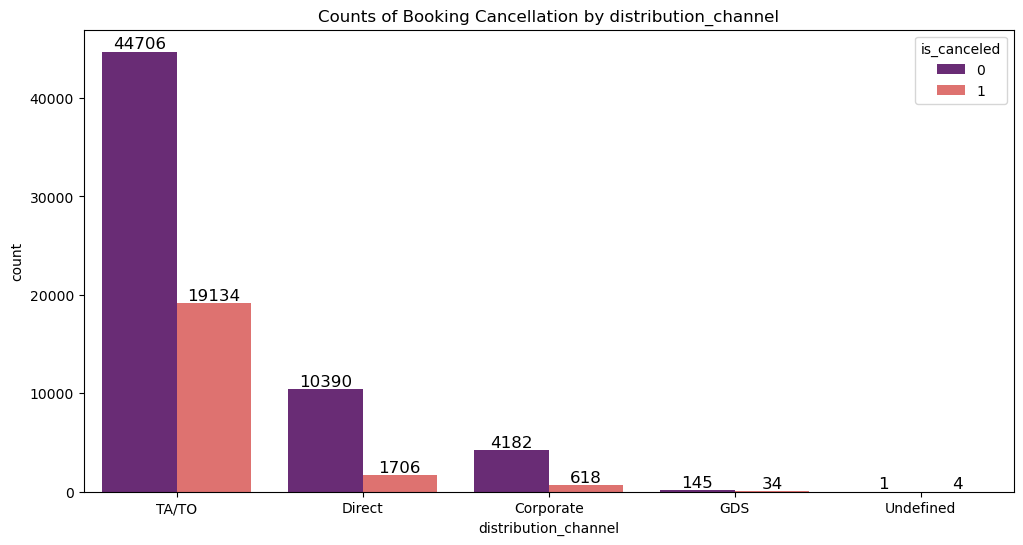

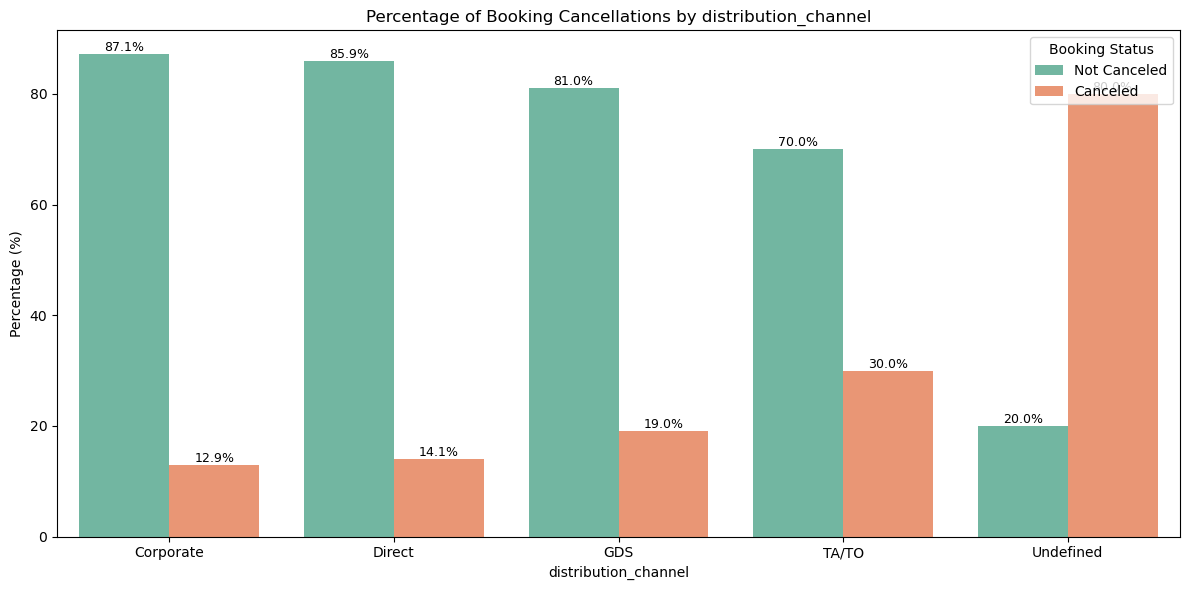

In [71]:
plot_default('distribution_channel')
plot_percentage('distribution_channel')

- Distribusi TA/TO, dengan jumlah pemesanan terbanyak ternyata memiliki tingkat pembatalan pemesanan tertinggi
- Distribusi secara direct atau corporate bisa menjadi sebuah target segmen melihat tingkat keberhasilan pemesanan yang cukup tinggi walaupun jumlah pemesanan yang jauh dibawah distribusi TA/TO.

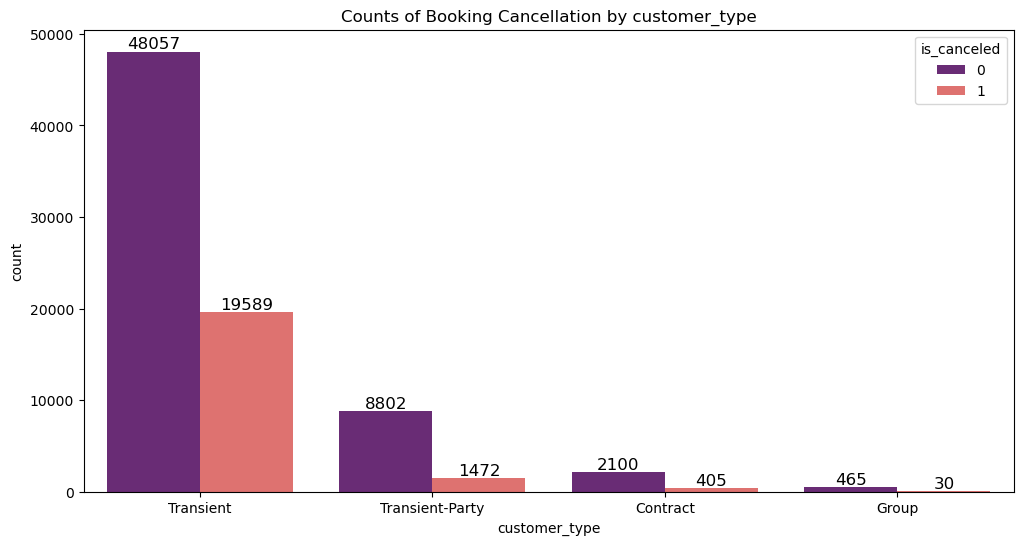

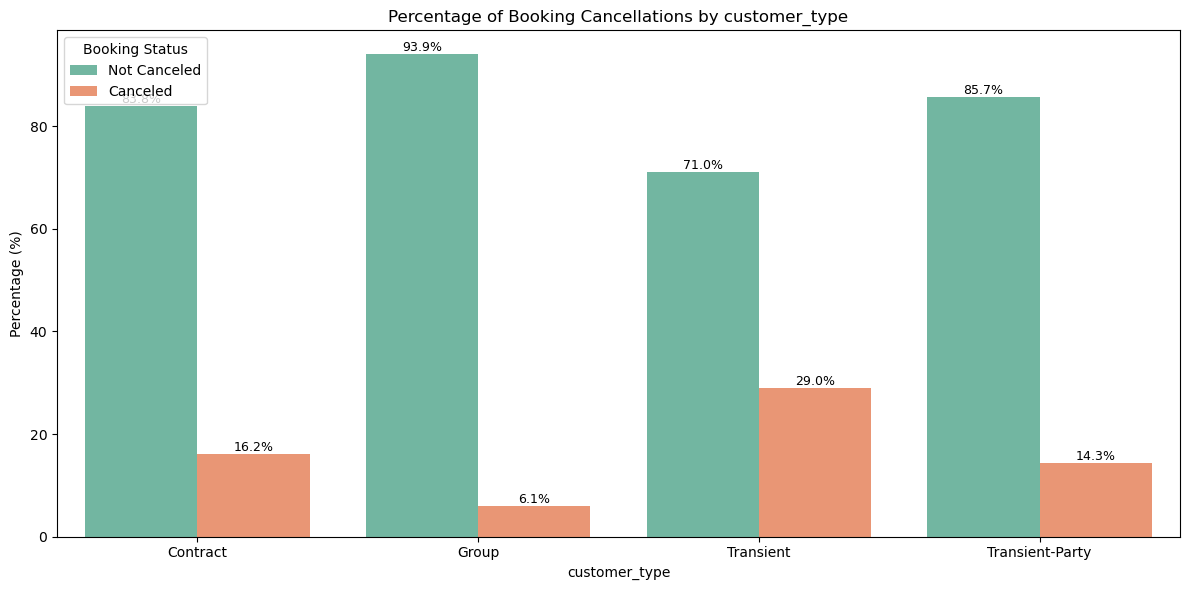

In [72]:
plot_default('customer_type')
plot_percentage('customer_type')

- Transient memiliki persentase tingkat pembatalan cukup tinggi dibanding tipe pelanggan lainnya.
- Namun begitu, tingkat keberhasilan yang dimiliki transient tidak rendah juga. Tetapi dibanding dengan tipe pelanggan lainnya, tipe pelanggan lain menunjukkan tingkat keberhasilan yang sangat tinggi walaupun berdasarkan jumlah pemesanan yang jauh dibawah transient

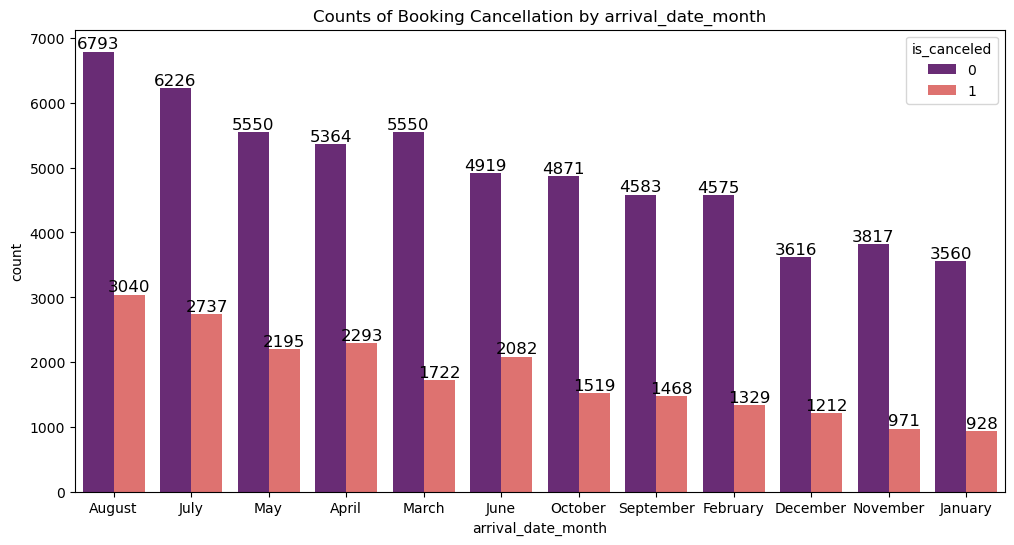

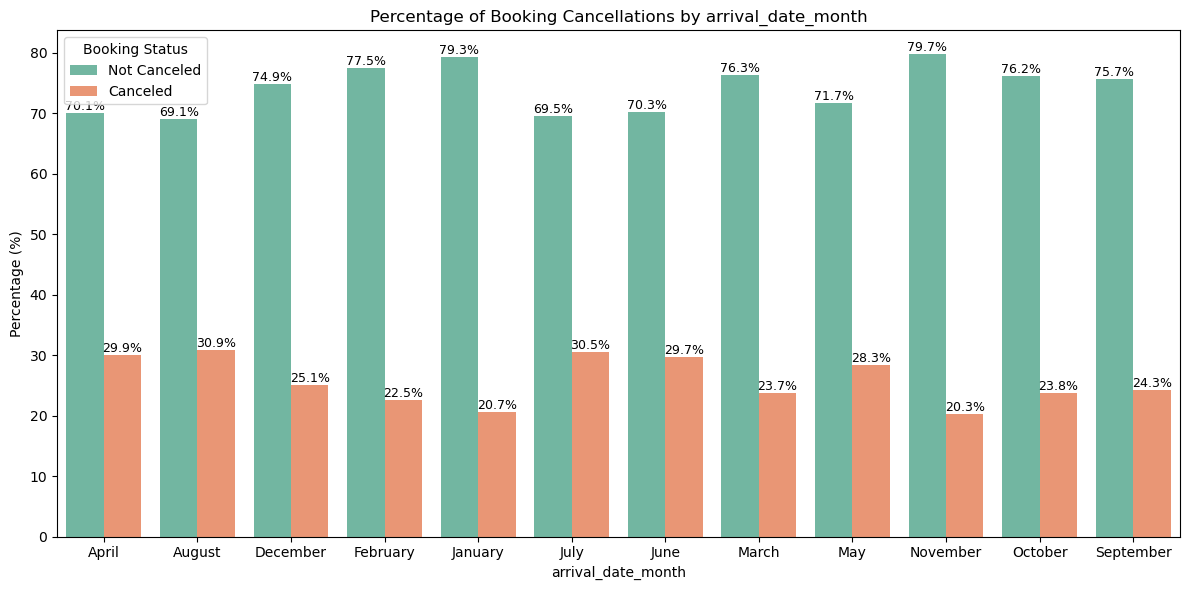

In [73]:
plot_default('arrival_date_month')
plot_percentage('arrival_date_month')

- Jika dilihat secara persentasse, tingkat keberhasilan maupun tingkat pembatalan pemesanan antar masing-masing bulan tidak menunjukkan perbedaan yang cukup jauh.
- Namun berdasarkan jumlah pemesanan, bulan januari dan november menjadi kedua paling sedikit, namun memiliki tingkat keberhasilan pemesanan tertinggi secara persentase.

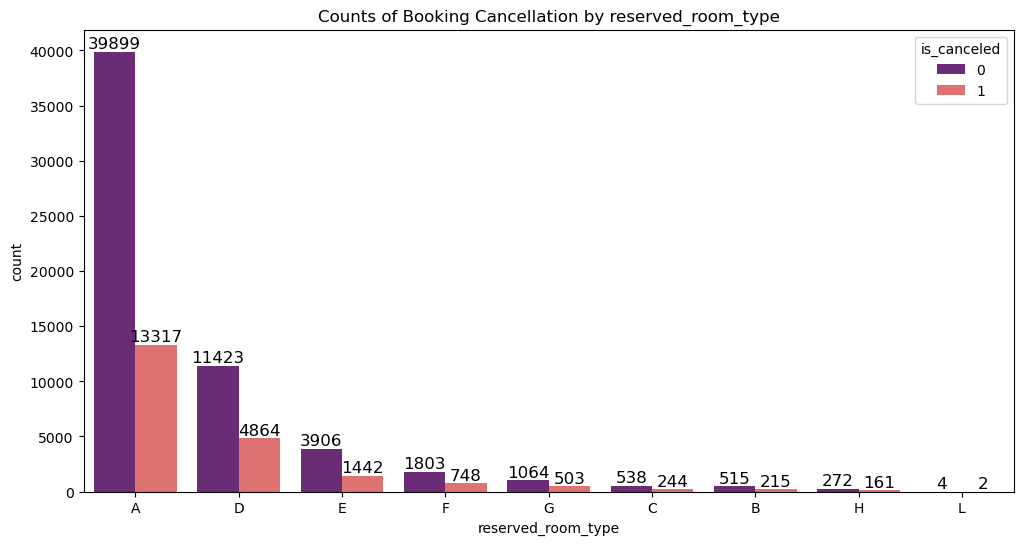

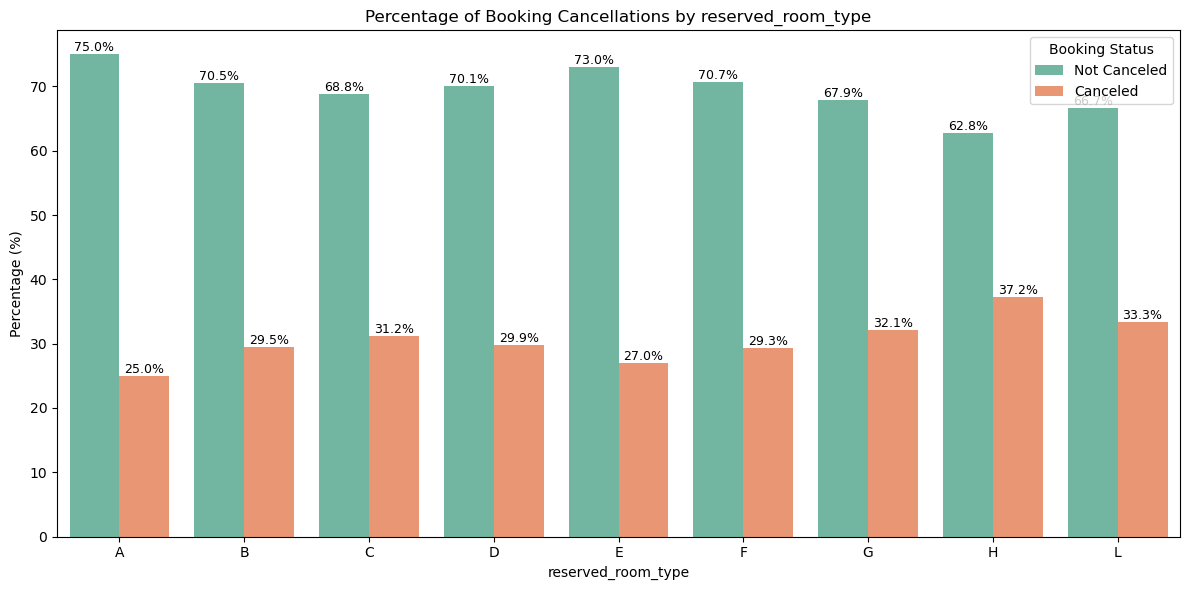

In [74]:
plot_default('reserved_room_type')
plot_percentage('reserved_room_type')

- Tipe ruangan A, menjadi yang paling banyak dipesan oleh para tamu ternyata juga menjadi tipe ruangan dengan persentase paling tinggi tingat keberhasilan pemesanan.
- Tipe H menjadi tipe ruangan dengan tingkat pembatalan pemesanan yang tinggi dibanding tipe ruangan lainnya, melihat tipe ruangan H juga merupakan tipe ruangan dengan jumlah pemesenan kedua paling sedikit.

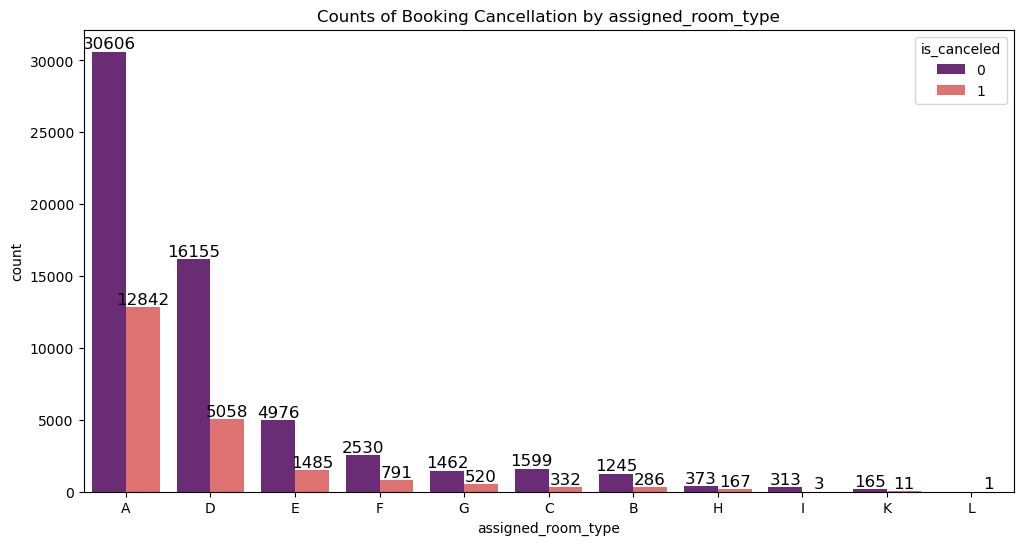

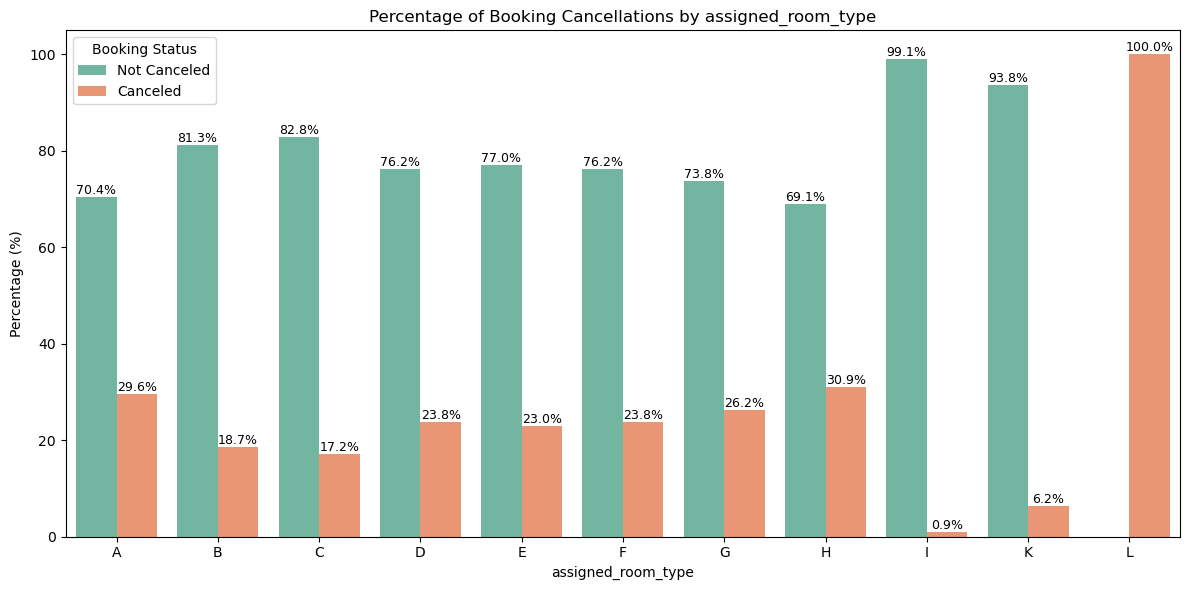

In [75]:
plot_default('assigned_room_type')
plot_percentage('assigned_room_type')

- Sama halnya dengan tipe ruangan yang dipilih diawal oleh para tamu, tipe ruangan A, D, E, F, G masih menjadi tipe ruangan yang paling banyak diberikan hotel kepada para tamu.
- Tipe ruangan I dan K menjadi tipe ruangan dengan persentase tingkat keberhasilan pemesanan yang sangat tinggi, walaupun jumlah pemesanan yang sangat sedikit.
- Secara keseluruhan selain tipe I dan K, tingkat pembatalan pemesanan untuk tipe kamar lainnya tidak terlalu berbeda.

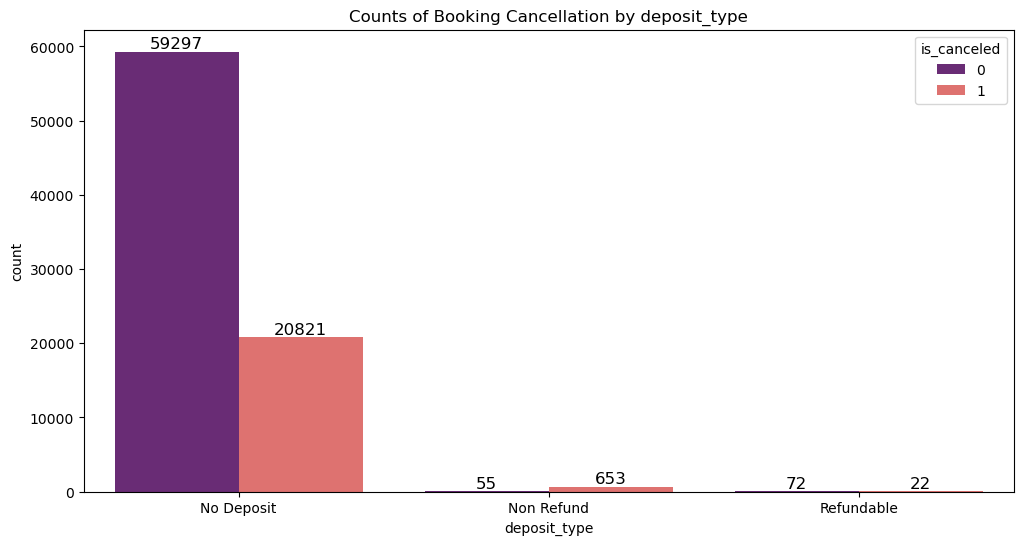

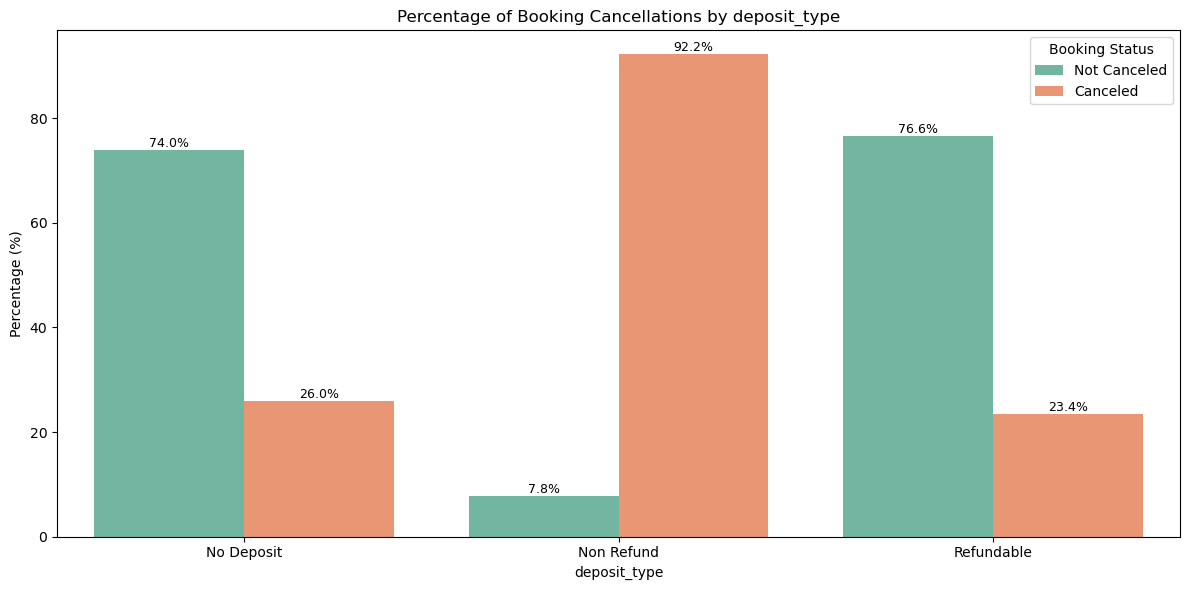

In [76]:
plot_default('deposit_type')
plot_percentage('deposit_type')

- Pemesanan tanpa deposit menjadi pilihan terbanyak para tamu dalam memesan sebuah hotel
- Namun, tingkat keberhasilan pemesanan terlihat lebih tinggi pada sebuah hotel yang menawarkan sistem refundable, sedangkan hotel dengan sistem no refund menunjukkan tingkat pembatalan yang sangat dominan.

MODELLING

In [77]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NeighbourhoodCleaningRule, NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import category_encoders as ce
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


In [78]:
new_df = df_hotel_demand_bookings.copy()
new_df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   
6  Resort Hotel            0          0               2015               July   
7  Resort Hotel            0          9               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
2                        27                          1   
3                        27                          1   
4                        27                          1   
6                        27                          1   
7                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
2                        0                     1       1  ...   
3                        0                     1       1  ...   
4                        0                     2       2  ...   
6                        0                     2       2  ...   
7                        0                     2       2  ...   

   days_in_waiting_list  customer_type    adr required_car_parking_spaces  \
2                     0      Transient   75.0                           0   
3                     0      Transient   75.0                           0   
4                     0      Transient   98.0                           0   
6                     0      Transient  107.0                           0   
7                     0      Transient  103.0                           0   

  total_of_special_requests reservation_status  reservation_status_date  \
2                         0          Check-Out               2015-07-02   
3                         0          Check-Out               2015-07-02   
4                         1          Check-Out               2015-07-03   
6                         0          Check-Out               2015-07-03   
7                         1          Check-Out               2015-07-03   

   total_stay  total_spending room_type_change  
2           1            75.0                1  
3           1            75.0                0  
4           2           196.0                0  
6           2           214.0                0  
7           2           206.0                0  

[5 rows x 34 columns]

In [79]:
print(len(new_df[new_df['is_canceled']==0]))
print(len(new_df[new_df['is_canceled']==1]))


59424
21496


In [80]:
# Prepare features and target
X = new_df.drop(['is_canceled', 'reservation_status_date'], axis=1)
y = new_df['is_canceled']
leakage_cols = [
                'arrival_date_week_number', 'arrival_date_day_of_month',
                'days_in_waiting_list',
                'babies',
                'reservation_status',
                'arrival_date_year',  
                'assigned_room_type',
                'hotel', 'meal', 'reserved_room_type',
                'arrival_date_month', 'total_stay'
]
X = X.drop(columns=leakage_cols)
categorical_cols = X.select_dtypes(include='object').columns.tolist()
num_cols_names = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Train-test split (safe, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
object_pipeline = Pipeline([('encode', ce.BinaryEncoder())])
numerical_pipeline = Pipeline([('scaling', RobustScaler())])

transformer = ColumnTransformer([
    ('cat_preprocessing', object_pipeline, categorical_cols),
    ('num_preprocessing', numerical_pipeline, num_cols_names)
], remainder='passthrough')

# ImbalanceSampler
sampler =  [
    SMOTEENN(),
    SMOTE(),
    NeighbourhoodCleaningRule(),
    NearMiss() ] 

# Models
models = {
    'KNN': KNeighborsClassifier(),  
    'LogReg': LogisticRegression(random_state=42, max_iter=1000),
    'RF': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),  
    'GB': GradientBoostingClassifier(random_state=42),  
    'LightGBM': LGBMClassifier(random_state=42) 
}

# Pipeline
pipeline = Pipeline([
    ('preprocess', transformer),
    ('sampler', NearMiss()),
    ('model', LogisticRegression())  # placeholder
], memory=None)

# Grid for models only
param_grid = {
    'model': list(models.values()),
    'sampler' : sampler
}

# Cross-validation
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

# Grid search
search_model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # ← use the custom weighted scorer
    cv=skfold,
    n_jobs=-1,
    error_score='raise'
)

# Fit
search_model.fit(X_train, y_train)

# Predict
y_pred = search_model.predict(X_test)
y_proba = search_model.predict_proba(X_test)[:, 1]


# CV Results DataFrame
import pandas as pd
results_df = pd.DataFrame(search_model.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
results_df.head()

# # Evaluate
# print("Best Params:", search_model.best_params_)
# print("Best CV Recall:", search_model.best_score_)
# print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))

# print("ROC AUC:", roc_auc_score(y_test, y_proba))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning:

[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5748
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5585
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 31115, number of neg

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5591
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 31111, number of negative: 25351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 56462, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551008 -> initscore=0.2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5747
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 31128, number of negative: 25345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5099
[LightGBM] [Info] Number of data points in the train set: 56473, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551201 -> initscore=0.2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5561
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5596
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5529
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` 

[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5582
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 42785, number of negative: 42785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5778
[LightGBM] [Info] Number of data points in the train set: 85570, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 15477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 30954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15477, number of negative: 15477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 30954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15477, number of negat

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340004 -> initscore=-0.663277
[LightGBM] [Info] Start training from score -0.663277


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Info] Number of positive: 15478, number of negative: 30159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45637, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339155 -> initscore=-0.667064
[LightGBM] [Info] Start training from score -0.667064


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 15477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 30954, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15477, number of negative: 15477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 30954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 15477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 30954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15477, number of negative: 15477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 30954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 15478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 30956, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 15478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 30956, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15478, number of negative: 15478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 30956, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/

[LightGBM] [Info] Number of positive: 17197, number of negative: 33538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 50735, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338957 -> initscore=-0.667944
[LightGBM] [Info] Start training from score -0.667944


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
rank_test_score                                                                 
1                    25.513308      0.893148         0.024583        0.003469   
2                    15.144555      6.272688         0.036177        0.008316   
3                    22.647886      0.901388         0.148951        0.020393   
4                    41.998667      4.038483         0.031252        0.008528   
5                    39.380394      4.095039         0.139225        0.018511   

                                             param_model  \
rank_test_score                                            
1                        LGBMClassifier(random_state=42)   
2                        LGBMClassifier(random_state=42)   
3                RandomForestClassifier(random_state=42)   
4                        LGBMClassifier(random_state=42)   
5                RandomForestClassifier(random_state=42)   

                               param_sampler  \
rank_test_score                                
1                NeighbourhoodCleaningRule()   
2                                    SMOTE()   
3                NeighbourhoodCleaningRule()   
4                                 SMOTEENN()   
5                                 SMOTEENN()   

                                                            params  \
rank_test_score                                                      
1                {'model': LGBMClassifier(random_state=42), 'sa...   
2                {'model': LGBMClassifier(random_state=42), 'sa...   
3                {'model': RandomForestClassifier(random_state=...   
4                {'model': LGBMClassifier(random_state=42), 'sa...   
5                {'model': RandomForestClassifier(random_state=...   

                 split0_test_score  split1_test_score  split2_test_score  \
rank_test_score                                                            
1                         0.670234           0.672409           0.670232   
2                         0.668691           0.670501           0.663554   
3                         0.663505           0.665156           0.673531   
4                         0.667468           0.669534           0.668106   
5                         0.663574           0.666171           0.658974   

                 split3_test_score  split4_test_score  split5_test_score  \
rank_test_score                                                            
1                         0.673354           0.687229           0.679341   
2                         0.667962           0.683558           0.683565   
3                         0.671895           0.676923           0.667653   
4                         0.672665           0.676684           0.662220   
5                         0.664845           0.667833           0.668134   

                 split6_test_score  split7_test_score  split8_test_score  \
rank_test_score                                                            
1                         0.680123           0.664796           0.686300   
2                         0.674810           0.658590           0.668496   
3                         0.670823           0.663670           0.673397   
4                         0.672155           0.664752           0.666667   
5                         0.675124           0.664674           0.672804   

                 split9_test_score  mean_test_score  std_test_score  
rank_test_score                                                      
1                         0.663778         0.674780        0.007790  
2                         0.660759         0.670049        0.008102  
3                         0.655992         0.668255        0.005943  
4                         0.658289         0.667854        0.005069  
5                         0.652238         0.665437        0.006181

HYPERPARAMETER

In [81]:
# Define the pipeline with correct order: preprocessing → sampler → model
pipeline = Pipeline([
    ('preprocess', transformer),
    ('sampler', NeighbourhoodCleaningRule()),
    ('Model', LGBMClassifier(random_state=42))  # model must be last
])

# Parameter grid for RandomizedSearchCV
param_grid = {
    'Model__n_estimators': [100, 300, 500, 1000],
    'Model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'Model__max_depth': [-1, 5, 10, 20],
    'Model__num_leaves': [15, 31, 50, 100],
    'Model__min_child_samples': [10, 20, 50, 100],
    'Model__reg_alpha': [0, 0.1, 1, 10],
    'Model__reg_lambda': [0, 0.1, 1, 10],
    'Model__random_state': [42]
}

# Cross-validation
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# Randomized Search
RD_Tuning = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    cv=skfold,
    scoring="f1",
    n_jobs=-1,
    n_iter=20,
    error_score="raise",
    random_state=42
)

# Fit
RD_Tuning.fit(X_train, y_train)

# Predict
y_pred_tuned = RD_Tuning.predict(X_test)
y_proba_tuned = RD_Tuning.predict_proba(X_test)[:, 1]

# Results
# print("Best recall:", RD_Tuning.best_score_)
# print("Best parameters:", RD_Tuning.best_params_)

# Evaluate
# print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred_tuned))
# print("ROC AUC:", roc_auc_score(y_test, y_proba_tuned))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# CV Results DataFrame
import pandas as pd
results_df = pd.DataFrame(RD_Tuning.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
results_df.head()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning:

[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Number of positive: 15477, number of negative: 30125
[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/

[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339415 -> initscore=-0.665901
[LightGBM] [Info] Start training from score -0.665901
[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 45652, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339021 -> initscore=-0.667659
[LightGBM] [Info] Start training from score -0.667659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339415 -> initscore=-0.665901
[LightGBM] [Info] Start training from score -0.665901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339393 -> initscore=-0.666000
[LightGBM] [Info] Start training from score -0.666000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45577, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339579 -> initscore=-0.665170
[LightGBM] [Info] Start training from score -0.665170


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 45604, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339400 -> initscore=-0.665969
[LightGBM] [Info] Start training from score -0.665969
[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338924 -> initscore=-0.668091
[LightGBM] [Info] Start training from score -0.668091
[LightGBM] [Info] Number of positive: 15477, number of negative: 30175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45652, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339021 -> initscore=-0.667659
[Lig

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338924 -> initscore=-0.668091
[LightGBM] [Info] Start training from score -0.668091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338924 -> initscore=-0.668091
[LightGBM] [Info] Start training from score -0.668091
[LightGBM] [Warning] No further splits with positive gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45652, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339021 -> initscore=-0.667659
[LightGBM] [Info] Start training from score -0.667659
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45652, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339021 -> initscore=-0.667659
[LightGBM] [Info] Start training from score -0.667659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436
[LightGBM] [Info] Number of positive: 15477, number of negative: 301

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339385 -> initscore=-0.666035
[LightGBM] [Info] Start training from score -0.666035
[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339385 -> initscore=-0.666035
[LightGBM] [Info] Start training from score -0.666035
[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339393 -> initscore=-0.666000
[LightGBM] [Info] Start training from score -0.666000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339385 -> initscore=-0.666035
[LightGBM] [Info] Start training from score -0.666035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339385 -> initscore=-0.666035
[LightGBM] [Info] Start training from score -0.666035
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339415 -> initscore=-0.665901
[LightGBM] [Info] Start training from score -0.665901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029026 seconds.
You can set `force_row_wise=true` to remove

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339393 -> initscore=-0.666000
[LightGBM] [Info] Start training from score -0.666000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45577, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339579 -> initscore=-0.665170
[LightGBM] [Info] Start training from score -0.665170


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45604, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339400 -> initscore=-0.665969
[LightGBM] [Info] Start training from score -0.665969
[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339728 -> initscore=-0.664505
[LightGBM] [Info] Start training from score -0.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosi

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338924 -> initscore=-0.668091
[LightGBM] [Info] Start training from score -0.668091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339415 -> initscore=-0.665901
[LightGBM] [Info] Start training from score -0.665901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339728 -> initscore=-0.664505
[LightGBM] [Info] Start training from score -0.664505


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339728 -> initscore=-0.664505
[LightGBM] [Info] Start training from score -0.664505


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15477, number of negative: 30125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339393 -> initscore=-0.666000
[LightGBM] [Info] Start training from score -0.666000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45577, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339579 -> initscore=-0.665170
[LightGBM] [Info] Start training from score -0.665170
[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45604, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339415 -> initscore=-0.665901
[LightGBM] [Info] Start training from score -0.665901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339728 -> initscore=-0.664505
[LightGBM] [Info] Start training from score -0.664505


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339393 -> initscore=-0.666000
[LightGBM] [Info] Start training from score -0.666000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15477, number of negative: 30100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45577, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339579 -> initscore=-0.665170
[LightGBM] [Info] Start training from score -0.665170
[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45604, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436
[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45604, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339400 -> initscore=-0.665969
[LightGBM] [Info] Start training from score -0.665969


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339385 -> initscore=-0.666035
[LightGBM] [Info] Start training from score -0.666035
[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45577, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339579 -> initscore=-0.665170
[LightGBM] [Info] Start training from score -0.665170
[LightGBM] [Info] Number of positive: 15478, number of negative: 30126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45604, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45585, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339520 -> initscore=-0.665436
[LightGBM] [Info] Start training from score -0.665436
[LightGBM] [Info] Number of positive: 15477, number of negative: 30122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45599, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

[LightGBM] [Info] Number of positive: 15477, number of negative: 30080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339728 -> initscore=-0.664505
[LightGBM] [Info] Start training from score -0.664505
[LightGBM] [Info] Number of positive: 15477, number of negative: 30125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 45602, number of used features: 32
[LightGBM] [Info] [b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 15478, number of negative: 30128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 45606, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339385 -> initscore=-0.666035
[LightGBM] [Info] Start training from score -0.666035
[LightGBM] [Info] Number of positive: 15478, number of negative: 30190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 45668, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338924 -> initscore=-0.668091
[Lig

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/

[LightGBM] [Info] Number of positive: 17197, number of negative: 33538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 50735, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338957 -> initscore=-0.667944
[LightGBM] [Info] Start training from score -0.667944


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
rank_test_score                                                                 
1                    54.562685      1.593352         0.044110        0.005213   
2                    33.032226      4.457799         0.030913        0.004547   
3                    58.893330      5.917193         0.070487        0.019639   
4                    49.766384      1.094931         0.044378        0.005150   
5                    89.577450      1.651942         0.051083        0.004419   

                 param_Model__reg_lambda  param_Model__reg_alpha  \
rank_test_score                                                    
1                                   10.0                     0.0   
2                                    1.0                     0.0   
3                                    1.0                     0.1   
4                                   10.0                     0.1   
5                                    0.0                     0.1   

                 param_Model__random_state  param_Model__num_leaves  \
rank_test_score                                                       
1                                       42                       50   
2                                       42                       15   
3                                       42                       50   
4                                       42                       50   
5                                       42                      100   

                 param_Model__n_estimators  param_Model__min_child_samples  \
rank_test_score                                                              
1                                      300                              10   
2                                      500                              10   
3                                      300                              10   
4                                      300                             100   
5                                      300                              20   

                 ...  split2_test_score  split3_test_score split4_test_score  \
rank_test_score  ...                                                           
1                ...           0.678812           0.683894          0.672864   
2                ...           0.677992           0.679880          0.673208   
3                ...           0.678922           0.683930          0.671375   
4                ...           0.675979           0.681590          0.670491   
5                ...           0.680840           0.682167          0.668004   

                 split5_test_score  split6_test_score  split7_test_score  \
rank_test_score                                                            
1                         0.672846           0.677764           0.673757   
2                         0.677628           0.679587           0.675105   
3                         0.674693           0.676353           0.672164   
4                         0.678270           0.677739           0.672422   
5                         0.670270           0.675882           0.675228   

                 split8_test_score  split9_test_score  mean_test_score  \
rank_test_score                                                          
1                         0.682733           0.676703         0.677020   
2                         0.678170           0.675185         0.675956   
3                         0.676007           0.677749         0.675872   
4                         0.680020           0.674987         0.675534   
5                         0.683083           0.672375         0.675423   

                 std_test_score  
rank_test_score                  
1                      0.003665  
2                      0.003014  
3                      0.003663  
4                      0.004233  
5                      0.005100  

[5 rows x 25 columns]

In [82]:
akurasi = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
presisi = precision_score(y_test, y_pred)

print("Accuracy : ", akurasi)
print("recall : ", recall)
print("f1 : ", f1)
print("presisi : ", presisi)

akurasi = accuracy_score(y_test, y_pred_tuned)
recall = recall_score(y_test, y_pred_tuned)
f1 = f1_score(y_test, y_pred_tuned)
presisi = precision_score(y_test, y_pred_tuned)
print("\n")
print("Accuracy : ", akurasi)
print("recall : ", recall)
print("f1 : ", f1)
print("presisi : ", presisi)

Accuracy :  0.8043129016312407
recall :  0.7531984182367992
f1 :  0.6715752359224307
presisi :  0.6059131736526946


Accuracy :  0.8029535343549185
recall :  0.7741335194231217
f1 :  0.6760792280345354
presisi :  0.6000721240533718


In [83]:
pipeline_tuned = RD_Tuning.best_estimator_
pipeline_tuned.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17197, number of negative: 33538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 50735, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338957 -> initscore=-0.667944
[LightGBM] [Info] Start training from score -0.667944


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessing',
                                                  Pipeline(steps=[('encode',
                                                                   BinaryEncoder())]),
                                                  ['country', 'market_segment',
                                                   'distribution_channel',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('num_preprocessing',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in...
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_spending',
                                                   'room_type_change'])])),
                ('sampler', NeighbourhoodCleaningRule()),
                ('Model',
                 LGBMClassifier(max_depth=20, min_child_samples=10,
                                n_estimators=300, num_leaves=50,
                                random_state=42, reg_alpha=0, reg_lambda=10))])

In [84]:
pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17197, number of negative: 33538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 50735, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338957 -> initscore=-0.667944
[LightGBM] [Info] Start training from score -0.667944


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessing',
                                                  Pipeline(steps=[('encode',
                                                                   BinaryEncoder())]),
                                                  ['country', 'market_segment',
                                                   'distribution_channel',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('num_preprocessing',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_spending',
                                                   'room_type_change'])])),
                ('sampler', NeighbourhoodCleaningRule()),
                ('Model', LGBMClassifier(random_state=42))])

In [85]:
y_pred = pipeline.predict(X_test)
y_pred_proba =pipeline.predict_proba(X_test)
y_pred_tuned = pipeline_tuned.predict(X_test)
y_pred_proba_tuned = pipeline_tuned.predict_proba(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17197, number of negative: 33538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 50735, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338957 -> initscore=-0.667944
[LightGBM] [Info] Start training from score -0.667944


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17197, number of negative: 33538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 50735, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338957 -> initscore=-0.667944
[LightGBM] [Info] Start training from score -0.667944


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


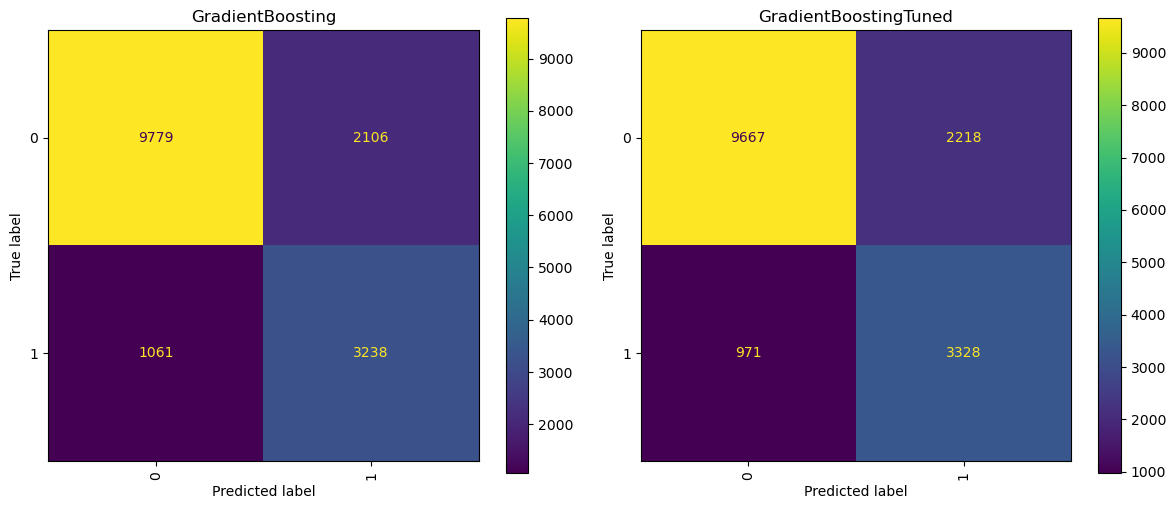

In [86]:
classifiers = {
    "GradientBoosting" : pipeline,
    "GradientBoostingTuned" : pipeline_tuned
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    
    axes[i].set_title(key)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [87]:
class_report = classification_report(y_test, y_pred)
class_report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Test Default: \n', class_report)
print('Classification Report Test Tuned: \n', class_report_tuned)

Classification Report Test Default: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86     11885
           1       0.60      0.77      0.68      4299

    accuracy                           0.80     16184
   macro avg       0.75      0.79      0.77     16184
weighted avg       0.83      0.80      0.81     16184

Classification Report Test Tuned: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86     11885
           1       0.60      0.77      0.68      4299

    accuracy                           0.80     16184
   macro avg       0.75      0.79      0.77     16184
weighted avg       0.83      0.80      0.81     16184



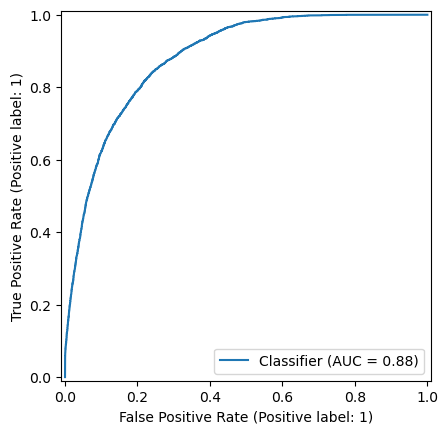

In [88]:
from sklearn.metrics import RocCurveDisplay

# y_pred = pipeline_tuned.predict(X_test)
# y_pred_proba =pipeline_tuned.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba_tuned[:,1])
auc_display =  RocCurveDisplay.from_predictions(y_test, y_pred_proba_tuned[:,1]).roc_auc


<H3>Feature Importances<h3>

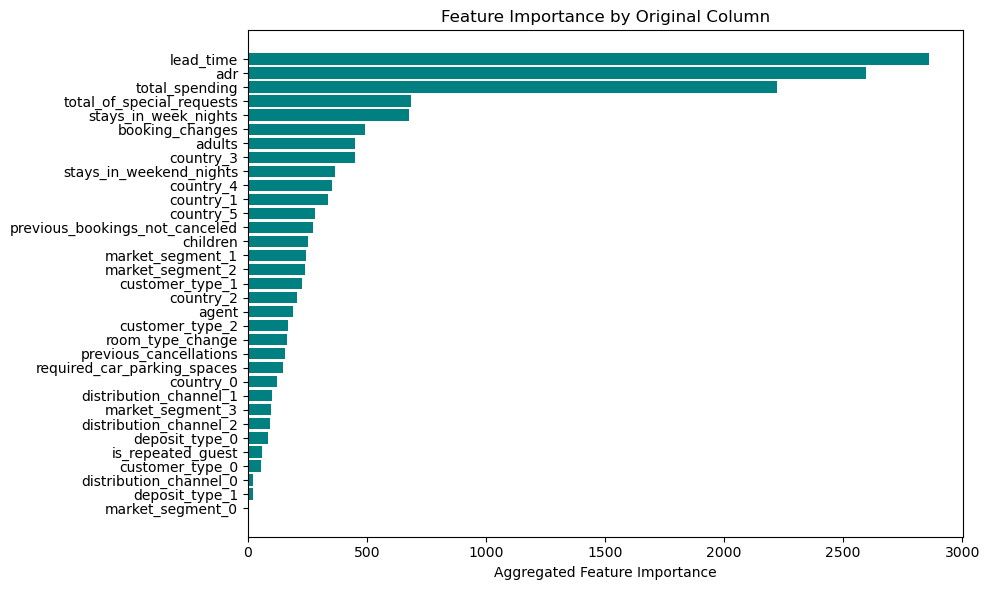

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# 1. Get the best model from grid search
best_model = RD_Tuning.best_estimator_

# 2. Get feature importances (supports tree-based models)
model = best_model.named_steps['Model']

importances = model.feature_importances_

# 3. Get feature names after transformation
# Get categorical and numerical feature names from the transformers
encoder = best_model.named_steps['preprocess'].named_transformers_['cat_preprocessing'].named_steps['encode']
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)

num_features = num_cols_names

# Combine all feature names
feature_names = list(encoded_cat_features) + list(num_features)

# 4. Map encoded feature names back to original column names
encoded_col_map = {}
for original_col, feature_list in zip(categorical_cols, encoder.get_feature_names_out()):
    for f in feature_list:
        encoded_col_map[f] = original_col

# Map and aggregate feature importances
decoded_importance = [(encoded_col_map.get(f, f), imp) for f, imp in zip(feature_names, importances)]

# Aggregate by original feature
agg_importance = defaultdict(float)
for orig, imp in decoded_importance:
    agg_importance[orig] += imp

# Sort by importance
sorted_agg = sorted(agg_importance.items(), key=lambda x: x[1], reverse=True)

# 5. Plot
plt.figure(figsize=(10, 6))
labels, values = zip(*sorted_agg)
plt.barh(labels[::-1], values[::-1], color='teal')
plt.xlabel('Aggregated Feature Importance')
plt.title('Feature Importance by Original Column')
plt.tight_layout()
plt.show()


<h3>Additional Analysis For Recommendation<h3>

In [90]:
import pandas as pd
from scipy.stats import binomtest

# Example binning
bins = [0, 50, 80, 110, 150, 200, new_df['adr'].max()]
labels = ['0-50', '51-80', '81-110', '111-150', '151-200', '200+']
new_df['adr_bin'] = pd.cut(new_df['adr'], bins=bins, labels=labels, include_lowest=True)

# Overall proportion of cancellations
overall_canceled_prop = (new_df['is_canceled'] == 1).mean()

result = []

for bin_label in labels:
    subset = new_df[new_df['adr_bin'] == bin_label]
    n = len(subset)
    canceled = (subset['is_canceled'] == 1).sum()
    prop_canceled = canceled / n
    diff = prop_canceled - overall_canceled_prop
    
    # Binomial test
    p_val = binomtest(canceled, n, overall_canceled_prop).pvalue

    result.append({
        'ADR Bin': bin_label,
        'Total': n,
        'Prop Canceled': prop_canceled,
        'Diff from Overall': diff,
        'p-value': p_val
    })

new_df_result = pd.DataFrame(result)
print(new_df_result.sort_values('Prop Canceled', ascending=False))


   ADR Bin  Total  Prop Canceled  Diff from Overall        p-value
5     200+   3511       0.370550           0.104905   4.243756e-42
4  151-200   9961       0.330489           0.064844   1.631562e-46
3  111-150  18921       0.322552           0.056907   1.669552e-67
2   81-110  21884       0.266176           0.000531   8.602885e-01
1    51-80  17501       0.208674          -0.056971   1.546404e-68
0     0-50   9141       0.144733          -0.120913  1.087706e-170


- Harga kamar yang memiliki tarif kurang dari 50, memiliki tingkat pembatalan pemesanan sebesar 14%.
- Harga kamar yang memiliki tarif lebih dari 200, memiliki tingkat pembatalan pemesanan sebesar 37%.
- Uji statistik menunjukkan bahwa semakin tinggi harga kamar, semakin tinggi juga tingkat pembatalan pemesanan.

In [91]:
import pandas as pd
import numpy as np

# Step 1: Make a copy and reset index
X_test_sim = X_test.copy().reset_index(drop=True)

# Step 2: Predict baseline cancellation probabilities
best_pipeline = RD_Tuning.best_estimator_
baseline_probs = best_pipeline.predict_proba(X_test_sim)[:, 1]  # Probability of cancellation

# Step 3: Identify high ADR bookings
high_adr_mask = (X_test_sim['adr'] > 111) & (X_test_sim['adr'] < 200)

# Step 4: Choose a % of high-ADR bookings to convert
conversion_ratio = 0.5
high_adr_indices = X_test_sim[high_adr_mask].index
to_convert_idx = high_adr_indices.to_series().sample(frac=conversion_ratio, random_state=42)

# Step 5: Simulate action — lower ADR to a typical low-moderate range 
X_test_sim.loc[to_convert_idx, 'adr'] = np.random.uniform(50, 80, size=len(to_convert_idx))

# Step 6: Predict again with modified data
simulated_probs = best_pipeline.predict_proba(X_test_sim)[:, 1]

# Step 7: Calculate average change in cancellation probability
prob_change = baseline_probs[to_convert_idx] - simulated_probs[to_convert_idx]
avg_reduction = prob_change.mean()

total_change = (baseline_probs - simulated_probs).mean()
print(f"Overall avg reduction in cancellation probability across all bookings: {total_change * 100:.2f}%")
print(f"Average predicted reduction in cancellation probability after converting 50% of high-ADR bookings to mid-range ADR: {avg_reduction * 100:.2f}%")


Overall avg reduction in cancellation probability across all bookings: 1.62%
Average predicted reduction in cancellation probability after converting 50% of high-ADR bookings to mid-range ADR: 9.29%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Jika menargetkan kamar yang memiliki tarif diatas 111 sampai 200 dan kita bisa menurunkan menjadi tarif 50-80, dari uji simulasi yang dilakukan pada 50% data tersebut, perkiraan pengurangan rata-rata dalam tingkat pembatalan pemesanan mencapai 8-9%.

In [92]:
# Define lead time bins
bins = [0, 30, 60, 90, 120, 150, 180, 9999]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150', '151-180', '180+']
new_df['lead_time_bin'] = pd.cut(new_df['lead_time'], bins=bins, labels=labels, include_lowest=True)

# Overall cancellation proportion
overall_cancel_rate = new_df['is_canceled'].mean()

# Group by bins and calculate proportions and p-values
summary = new_df.groupby('lead_time_bin')['is_canceled'].agg(['count', 'sum']).reset_index()
summary.columns = ['Lead Time Bin', 'Total', 'Canceled']
summary['Prop Canceled'] = summary['Canceled'] / summary['Total']
summary['Diff from Overall'] = summary['Prop Canceled'] - overall_cancel_rate

# Binomial test for each bin
summary['p-value'] = summary.apply(
    lambda row: binomtest(int(row['Canceled']), int(row['Total']), overall_cancel_rate).pvalue,
    axis=1
)

summary.sort_values('Lead Time Bin', inplace=True)
summary.reset_index(drop=True, inplace=True)
summary.style.format({
    'Prop Canceled': '{:.3f}',
    'Diff from Overall': '{:+.3f}',
    'p-value': '{:.3e}'
})

- Selisih hari pemesanan yang dilakukan jauh hari sampai waktu check-in lebih dari 180 hari memiliki tingkat pembatalan pemesanan sebesar 38%.
- Selisih hari pemesanan yang dilakukan sampai waktu check-in kurang dari 30 hari memiliki tingkat pembatalan sebesar 16%.
- Uji statistik menunjukkan bahwa semakin lama selisih hari pemesanan sampai waktu check-in semakin besar tingkat pembatalan pemesanan.

In [93]:
# Step 1: Make a copy and reset index
X_test_sim = X_test.copy().reset_index(drop=True)

# Step 2: Predict baseline cancellation probabilities
best_pipeline = RD_Tuning.best_estimator_
baseline_probs = best_pipeline.predict_proba(X_test_sim)[:, 1]  # Probability of cancellation

# Step 3: Identify bookings with long lead_time
long_lead_mask = X_test_sim['lead_time'] > 180

# Step 4: Choose a % of long lead bookings to convert
conversion_ratio = 0.5
long_lead_indices = X_test_sim[long_lead_mask].index
to_convert_idx = long_lead_indices.to_series().sample(frac=conversion_ratio, random_state=42)

# Step 5: Simulate action — shorten lead time
X_test_sim.loc[to_convert_idx, 'lead_time'] = np.random.randint(31, 60, size=len(to_convert_idx))

# Step 6: Predict again with modified data
simulated_probs = best_pipeline.predict_proba(X_test_sim)[:, 1]

# Step 7: Calculate average change in cancellation probability
prob_change = baseline_probs[to_convert_idx] - simulated_probs[to_convert_idx]
avg_reduction = prob_change.mean()

total_change = (baseline_probs - simulated_probs).mean()
print(f"Overall avg reduction in cancellation probability across all bookings: {total_change * 100:.2f}%")
print(f"Average predicted reduction in cancellation probability after converting 50% of long-lead bookings to short-lead ones: {avg_reduction * 100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Overall avg reduction in cancellation probability across all bookings: 0.41%
Average predicted reduction in cancellation probability after converting 50% of long-lead bookings to short-lead ones: 8.29%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Jika menargetkan tamu-tamu yang memiliki selisih pemesanan sampai waktu check-in lebih dari 180 hari menjadi 31-60 hari, dari uji simulasi yang dilakukan pada 50% data tersebut, perkiraan pengurangan rata-rata dalam tingkat pembatalan pemesanan mencapai 8-9%.

In [94]:
# Define bins and labels
bins = [0, 100, 300, 500, 750, 1000, 1500, np.inf]
labels = ['0-100', '101-300', '301-500', '501-750', '751-1000', '1001-1500', '1500+']
new_df['spending_bin'] = pd.cut(new_df['total_spending'], bins=bins, labels=labels, right=False)

# Overall cancellation rate
overall_cancel_rate = new_df['is_canceled'].mean()

# Calculate stats per bin
results = []
for label in labels:
    subset = new_df[new_df['spending_bin'] == label]
    total = len(subset)
    canceled = subset['is_canceled'].sum()
    prop_canceled = canceled / total if total > 0 else 0
    diff_from_overall = prop_canceled - overall_cancel_rate
    p_value = binomtest(canceled, total, overall_cancel_rate).pvalue if total > 0 else np.nan

    results.append({
        'Spending Bin': label,
        'Total': total,
        'Prop Canceled': round(prop_canceled, 3),
        'Diff from Overall': round(diff_from_overall, 3),
        'p-value': p_value
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df['Spending Bin'] = pd.Categorical(results_df['Spending Bin'], categories=labels, ordered=True)
results_df = results_df.sort_values('Spending Bin')

# Display result
results_df

Spending Bin  Total  Prop Canceled  Diff from Overall        p-value
0        0-100  12769          0.142             -0.123  2.127418e-248
1      101-300  29492          0.242             -0.024   5.314357e-21
2      301-500  20318          0.300              0.035   3.271337e-28
3      501-750  10686          0.327              0.062   2.084718e-45
4     751-1000   4125          0.371              0.105   2.033323e-49
5    1001-1500   2853          0.400              0.134   2.600797e-54
6        1500+    676          0.419              0.153   9.142694e-18

- Tamu yang mengeluarkan total tarif sampai lebih dari 1500 dalam sekali pemesanan memiliki tingkat pembatalan sebesar 41%.
- Tamu yang mengeluarkan total tarif kurang dari 100 dalam sekali pemesanan memiliki tingkat pembatalan sebesar 14%.
- Uji statistik menunjukkan bahwa semakin besar total tarif yang dikeluarkan, semakin besar tingkat pembatalan pemesanan.

In [95]:
# Step 1: Make a copy and reset index
X_test_sim = X_test.copy().reset_index(drop=True)

# Step 2: Predict baseline cancellation probabilities
best_pipeline = RD_Tuning.best_estimator_
baseline_probs = best_pipeline.predict_proba(X_test_sim)[:, 1]  # Probability of cancellation

# Step 3: Identify bookings with long total_spen
long_total_spend_mask = (X_test_sim['total_spending'] > 751) & (X_test_sim['total_spending'] > 1000)

# Step 4: Choose a % of long total_spend bookings to convert
conversion_ratio = 0.5
long_total_spend_indices = X_test_sim[long_total_spend_mask].index
to_convert_idx = long_total_spend_indices.to_series().sample(frac=conversion_ratio, random_state=42)

# Step 5: Simulate action — middle total_spend time
X_test_sim.loc[to_convert_idx, 'total_spending'] = np.random.randint(300, 500, size=len(to_convert_idx))

# Step 6: Predict again with modified data
simulated_probs = best_pipeline.predict_proba(X_test_sim)[:, 1]

# Step 7: Calculate average change in cancellation probability
prob_change = baseline_probs[to_convert_idx] - simulated_probs[to_convert_idx]
avg_reduction = prob_change.mean()

total_change = (baseline_probs - simulated_probs).mean()
print(f"Overall avg reduction in cancellation probability across all bookings: {total_change * 100:.2f}%")
print(f"Average predicted reduction in cancellation probability after converting 50% of big-total spending bookings to middle-total spending ones: {avg_reduction * 100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Overall avg reduction in cancellation probability across all bookings: 0.02%
Average predicted reduction in cancellation probability after converting 50% of big-total spending bookings to middle-total spending ones: 1.12%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Tamu yang mengeluarkan total tarif lebih dari 1500 menjadi 751-1000, dari uji simulasi yang dilakukan pada 50% data tersebut, perkiraan pengurangan rata-rata dalam tingkat pembatalan pemesanan mencapai 2-3%.

<h2>Conclusion<h2>

In [96]:
print('F1-Score Test Default: ', search_model.best_score_)
print('F1-Score Test Tuned: ', RD_Tuning.best_score_)

F1-Score Test Default:  0.6747795509355259
F1-Score Test Tuned:  0.6770195531277763


In [97]:
from sklearn.metrics import RocCurveDisplay

roc_auc = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC-AUC Score Report Test Tuned: \n', roc_auc)
print('Classification Report Test Tuned: \n', class_report_tuned)

ROC-AUC Score Report Test Tuned: 
 0.8828703449540615
Classification Report Test Tuned: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86     11885
           1       0.60      0.77      0.68      4299

    accuracy                           0.80     16184
   macro avg       0.75      0.79      0.77     16184
weighted avg       0.83      0.80      0.81     16184



Berdasarkan hasil evaluasi model, dapat disimpulkan bahwa kombinasi NeighbourhoodCleaningRule() sebagai metode undersampling dan LGBMClassifier() sebagai classifier merupakan solusi yang efektif untuk menangani masalah prediksi pembatalan booking hotel dengan karakteristik data yang tidak seimbang. 

Model yang telah di-tuning menunjukkan performa yang baik dengan F1-Score sebesar 0.676 (67.6%), yang mengalami peningkatan dari model default (67.5%). Meskipun peningkatannya modest, hal ini menunjukkan bahwa hyperparameter tuning memberikan optimasi yang tepat.

- Kelas 0 (Not Canceled): Model sangat baik dalam mengidentifikasi booking yang tidak dibatalkan dengan precision 91% dan recall 81%
- Kelas 1 (Canceled): Model cukup baik dalam mendeteksi pembatalan dengan precision 60% dan recall 78%, yang menunjukkan kemampuan yang baik untuk kasus imbalance

Hal ini memungkinkan hotel untuk:
- Mengimplementasikan strategi retensi yang tepat sasaran
- Mengoptimalkan revenue
- Mengurangi kerugian akibat pembatalan mendadak

<h2>Recommendation<h2>

<h3>Business Recommendation<h3>

Berdasarkan 3 feature paling penting pada model :
1. ADR

Target segment = ADR > 111 & ADR < 200

Tawarkan diskon dengan waktu terbatas, bundling, atau fasilitas early-bird untuk sedikit mengurangi ADR sambil tetap mempertahankan nilai atau service hotel. Berdasarkan statistik dapat menurunkan 5-9% pembatalan dari 50% target segment tersebut.

2. Lead Time

Target segment = Lead Time > 180

Tawarkan penawaran menit terakhir (misalnya, “Pesan dalam 30 hari = diskon 10%) untuk mendorong reservasi dengan lead time yang lebih pendek. Berdasarkan statistik dapat menurunkan 8-9% tingkat pembatalan dari 50% target segment tersebut.

3. Total Spend

Target segment = Total Spend > 751 & Total Spend < 1000

Tawarkan tingkatan program loyalitas yang disesuaikan dengan segmen ini, Gunakan email untuk pengingat setelah pemesanan dilakukan. Berdasarkan statistik dapat menurunkan 2-3% tingkat pembatalan dari 50% target segment tersebut.

<h3>Model Recommendation<h3>

- Penambahan fitur numerikal lain, melihat fitur numerikal menjadi fitur paling penting berdasarkan hasil feature importances.
- Penggunaan algoritma deep learning seperti neural network untuk meningkatkan performa model
- Penggunaan Fitur Engineering dalam membuat kolom baru yang bisa meningkatkan performa model
- Penggunaan data yang lebih up-to-date, melihat data yang dimiliki adalah data pada tahun 2015 hingga 2017

<h3>Limitasi Model<h3>

- Data booking yang berkisar pada tahun 2015 hingga 2017 saja.

In [98]:
new_df.to_csv('hotel_booking_demands_final.csv', index = False)

In [100]:
# Meng-export model machine learning ke dalam file .pkl untuk digunakan di aplikasi streamlit

import joblib
joblib.dump(pipeline_tuned, 'hotel_model.pkl')

['hotel_model.pkl']